##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# RNN を使って音楽を生成する

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/audio/music_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、単純な RNN（回帰型ニューラルネットワーク）を使用して楽譜を生成する方法を説明します。モデルは、[MAESTRO データセット](https://magenta.tensorflow.org/datasets/maestro)のピアノ MIDI ファイルのコレクションを使ってトレーニングします。ノートのシーケンスを与えられることで、モデルはそのシーケンスの次のノートを予測するように学習します。モデルを繰り返し呼び出すことで、より長いノートのシーケンスを生成できます。

このチュートリアルには、MIDI ファイルを解析して作成するための完全なコードが含まれます。RNN の仕組みについては、[RNN によるテキスト生成](https://www.tensorflow.org/text/tutorials/text_generation)をご覧ください。

## MNIST モデルをビルドする

このチュートリアルでは、MIDI ファイルの作成と解析を行う [`pretty_midi`](https://github.com/craffel/pretty-midi) ライブラリと、Colab でオーディオ再生を生成する [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) を使用します。

In [2]:
!sudo apt install -y fluidsynth

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libparted-fs-resize0 libxmlb2
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  fluid-soundfont-gm libdouble-conversion3 libfluidsynth2 libinstpatch-1.0-2
  libpcre2-16-0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5
  libqt5widgets5 libsdl2-2.0-0 qsynth qt5-gtk-platformtheme
  qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity qt5-image-formats-plugins qtwayland5 jackd
  musescore


The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libdouble-conversion3 libfluidsynth2
  libinstpatch-1.0-2 libpcre2-16-0 libqt5core5a libqt5dbus5 libqt5gui5
  libqt5network5 libqt5svg5 libqt5widgets5 libsdl2-2.0-0 qsynth
  qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont


0 upgraded, 17 newly installed, 0 to remove and 128 not upgraded.


Need to get 136 MB of archives.
After this operation, 202 MB of additional disk space will be used.
0% [Working]

Get:1 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libdouble-conversion3 amd64 3.1.5-4ubuntu1 [37.9 kB]
Get:2 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libpcre2-16-0 amd64 10.34-7ubuntu0.1 [181 kB]
2% [Waiting for headers]

Get:3 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5core5a amd64 5.12.8+dfsg-0ubuntu2.1 [2006 kB]
Get:4 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5dbus5 amd64 5.12.8+dfsg-0ubuntu2.1 [208 kB]
Get:5 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5network5 amd64 5.12.8+dfsg-0ubuntu2.1 [673 kB]
Get:6 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5gui5 amd64 5.12.8+dfsg-0ubuntu2.1 [2971 kB]
8% [6 libqt5gui5 3545 B/2971 kB 0%]

Get:7 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 libqt5widgets5 amd64 5.12.8+dfsg-0ubuntu2.1 [2295 kB]
11% [7 libqt5widgets5 6633 B/2295 kB 0%]

13% [Waiting for headers]

Get:8 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libqt5svg5 amd64 5.12.8-0ubuntu1 [131 kB]
14% [Waiting for headers]

Get:9 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
14% [9 fluid-soundfont-gm 2406 B/119 MB 0%]

28% [9 fluid-soundfont-gm 22.8 MB/119 MB 19%]

46% [9 fluid-soundfont-gm 53.2 MB/119 MB 44%]

65% [9 fluid-soundfont-gm 86.8 MB/119 MB 73%]

82% [9 fluid-soundfont-gm 116 MB/119 MB 97%]

Get:10 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:11 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libsdl2-2.0-0 amd64 2.0.10+dfsg1-3 [407 kB]
Get:12 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5420 kB]
89% [12 timgm6mb-soundfont 31.2 kB/5420 kB 1%]

93% [Waiting for headers]

Get:13 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [198 kB]
94% [Waiting for headers]

Get:14 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 fluidsynth amd64 2.1.1-2 [25.6 kB]
95% [Waiting for headers]

Get:15 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 qsynth amd64 0.6.1-1build1 [245 kB]
95% [15 qsynth 13.7 kB/245 kB 6%]

Get:16 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 qt5-gtk-platformtheme amd64 5.12.8+dfsg-0ubuntu2.1 [124 kB]
Get:17 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 qttranslations5-l10n all 5.12.8-0ubuntu1 [1486 kB]
Fetched 136 MB in 4s (38.8 MB/s)



78

Selecting previously unselected package libdouble-conversion3:amd64.


(Reading database ... 145997 files and directories currently installed.)
Preparing to unpack .../00-libdouble-conversion3_3.1.5-4ubuntu1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  1%] [..........................................................] 8Unpacking libdouble-conversion3:amd64 (3.1.5-4ubuntu1) ...
7Progress: [  3%] [#.........................................................] 8

Selecting previously unselected package libpcre2-16-0:amd64.
Preparing to unpack .../01-libpcre2-16-0_10.34-7ubuntu0.1_amd64.deb ...
7Progress: [  4%] [##........................................................] 8Unpacking libpcre2-16-0:amd64 (10.34-7ubuntu0.1) ...


7Progress: [  6%] [###.......................................................] 8Selecting previously unselected package libqt5core5a:amd64.


Preparing to unpack .../02-libqt5core5a_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [  7%] [####......................................................] 8Unpacking libqt5core5a:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [  9%] [#####.....................................................] 8

Selecting previously unselected package libqt5dbus5:amd64.
Preparing to unpack .../03-libqt5dbus5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 10%] [#####.....................................................] 8Unpacking libqt5dbus5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 12%] [######....................................................] 8Selecting previously unselected package libqt5network5:amd64.
Preparing to unpack .../04-libqt5network5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 13%] [#######...................................................] 8Unpacking libqt5network5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 14%] [########..................................................] 8Selecting previously unselected package libqt5gui5:amd64.


Preparing to unpack .../05-libqt5gui5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 16%] [#########.................................................] 8Unpacking libqt5gui5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 17%] [##########................................................] 8

Selecting previously unselected package libqt5widgets5:amd64.
Preparing to unpack .../06-libqt5widgets5_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 19%] [##########................................................] 8Unpacking libqt5widgets5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 20%] [###########...............................................] 8

Selecting previously unselected package libqt5svg5:amd64.
Preparing to unpack .../07-libqt5svg5_5.12.8-0ubuntu1_amd64.deb ...
7Progress: [ 22%] [############..............................................] 8Unpacking libqt5svg5:amd64 (5.12.8-0ubuntu1) ...


7Progress: [ 23%] [#############.............................................] 8Selecting previously unselected package fluid-soundfont-gm.
Preparing to unpack .../08-fluid-soundfont-gm_3.1-5.1_all.deb ...
7Progress: [ 25%] [##############............................................] 8Unpacking fluid-soundfont-gm (3.1-5.1) ...


7Progress: [ 26%] [###############...........................................] 8Selecting previously unselected package libinstpatch-1.0-2:amd64.
Preparing to unpack .../09-libinstpatch-1.0-2_1.1.2-2build1_amd64.deb ...
7Progress: [ 28%] [###############...........................................] 8Unpacking libinstpatch-1.0-2:amd64 (1.1.2-2build1) ...


7Progress: [ 29%] [################..........................................] 8

Selecting previously unselected package libsdl2-2.0-0:amd64.
Preparing to unpack .../10-libsdl2-2.0-0_2.0.10+dfsg1-3_amd64.deb ...
7Progress: [ 30%] [#################.........................................] 8Unpacking libsdl2-2.0-0:amd64 (2.0.10+dfsg1-3) ...


7Progress: [ 32%] [##################........................................] 8Selecting previously unselected package timgm6mb-soundfont.


Preparing to unpack .../11-timgm6mb-soundfont_1.3-3_all.deb ...
7Progress: [ 33%] [###################.......................................] 8Unpacking timgm6mb-soundfont (1.3-3) ...


7Progress: [ 35%] [####################......................................] 8

Selecting previously unselected package libfluidsynth2:amd64.
Preparing to unpack .../12-libfluidsynth2_2.1.1-2_amd64.deb ...
7Progress: [ 36%] [#####################.....................................] 8Unpacking libfluidsynth2:amd64 (2.1.1-2) ...


7Progress: [ 38%] [#####################.....................................] 8Selecting previously unselected package fluidsynth.


Preparing to unpack .../13-fluidsynth_2.1.1-2_amd64.deb ...
7Progress: [ 39%] [######################....................................] 8Unpacking fluidsynth (2.1.1-2) ...
7Progress: [ 41%] [#######################...................................] 8Selecting previously unselected package qsynth.


Preparing to unpack .../14-qsynth_0.6.1-1build1_amd64.deb ...
7Progress: [ 42%] [########################..................................] 8Unpacking qsynth (0.6.1-1build1) ...


7Progress: [ 43%] [#########################.................................] 8Selecting previously unselected package qt5-gtk-platformtheme:amd64.
Preparing to unpack .../15-qt5-gtk-platformtheme_5.12.8+dfsg-0ubuntu2.1_amd64.deb ...
7Progress: [ 45%] [##########################................................] 8Unpacking qt5-gtk-platformtheme:amd64 (5.12.8+dfsg-0ubuntu2.1) ...


7Progress: [ 46%] [##########################................................] 8Selecting previously unselected package qttranslations5-l10n.
Preparing to unpack .../16-qttranslations5-l10n_5.12.8-0ubuntu1_all.deb ...
7Progress: [ 48%] [###########################...............................] 8

Unpacking qttranslations5-l10n (5.12.8-0ubuntu1) ...


7Progress: [ 49%] [############################..............................] 8

Setting up libdouble-conversion3:amd64 (3.1.5-4ubuntu1) ...
7Progress: [ 51%] [#############################.............................] 87Progress: [ 52%] [##############################............................] 8Setting up libpcre2-16-0:amd64 (10.34-7ubuntu0.1) ...
7Progress: [ 54%] [###############################...........................] 87Progress: [ 55%] [###############################...........................] 8Setting up qttranslations5-l10n (5.12.8-0ubuntu1) ...
7Progress: [ 57%] [################################..........................] 87Progress: [ 58%] [#################################.........................] 8Setting up libqt5core5a:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 59%] [##################################........................] 8

7Progress: [ 61%] [###################################.......................] 8Setting up libqt5dbus5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 62%] [####################################......................] 87Progress: [ 64%] [####################################......................] 8Setting up fluid-soundfont-gm (3.1-5.1) ...
7Progress: [ 65%] [#####################################.....................] 87Progress: [ 67%] [######################################....................] 8Setting up libsdl2-2.0-0:amd64 (2.0.10+dfsg1-3) ...
7Progress: [ 68%] [#######################################...................] 87Progress: [ 70%] [########################################..................] 8Setting up timgm6mb-soundfont (1.3-3) ...
7Progress: [ 71%] [#########################################.................] 8

update-alternatives: using /usr/share/sounds/sf2/TimGM6mb.sf2 to provide /usr/share/sounds/sf2/default-GM.sf2 (default-GM.sf2) in auto mode
update-alternatives: using /usr/share/sounds/sf2/TimGM6mb.sf2 to provide /usr/share/sounds/sf3/default-GM.sf3 (default-GM.sf3) in auto mode
7Progress: [ 72%] [##########################################................] 8Setting up libinstpatch-1.0-2:amd64 (1.1.2-2build1) ...
7Progress: [ 74%] [##########################################................] 87Progress: [ 75%] [###########################################...............] 8Setting up libqt5network5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 77%] [############################################..............] 87Progress: [ 78%] [#############################################.............] 8Setting up libfluidsynth2:amd64 (2.1.1-2) ...
7Progress: [ 80%] [##############################################............] 87Progress: [ 81%] [#############################################

7Progress: [ 84%] [################################################..........] 8Setting up libqt5widgets5:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 86%] [#################################################.........] 87Progress: [ 87%] [##################################################........] 8Setting up qt5-gtk-platformtheme:amd64 (5.12.8+dfsg-0ubuntu2.1) ...
7Progress: [ 88%] [###################################################.......] 87Progress: [ 90%] [####################################################......] 8Setting up fluidsynth (2.1.1-2) ...
7Progress: [ 91%] [####################################################......] 8

Created symlink /etc/systemd/user/multi-user.target.wants/fluidsynth.service → /usr/lib/systemd/user/fluidsynth.service.
7Progress: [ 93%] [#####################################################.....] 8

Setting up libqt5svg5:amd64 (5.12.8-0ubuntu1) ...
7Progress: [ 94%] [######################################################....] 87Progress: [ 96%] [#######################################################...] 8Setting up qsynth (0.6.1-1build1) ...
7Progress: [ 97%] [########################################################..] 87Progress: [ 99%] [#########################################################.] 8Processing triggers for desktop-file-utils (0.24-1ubuntu3) ...
Processing triggers for mime-support (3.64ubuntu1) ...
Processing triggers for hicolor-icon-theme (0.17-2) ...


Processing triggers for gnome-menus (3.36.0-1ubuntu1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.12) ...


Processing triggers for man-db (2.9.1-1) ...



78

In [3]:
!pip install --upgrade pyfluidsynth

In [4]:
!pip install pretty_midi

  Preparing metadata (setup.py) ... -

 done


 \

 |

 done


  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=6321bf8b6673d0b49e792175983deb4af621ae765406fb9417bf086a1642878d
  Stored in directory: /home/kbuilder/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty_midi


In [5]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

2024-01-11 22:00:46.923423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 22:00:46.923467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 22:00:46.925019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Maestro データセットをダウンロードする

In [7]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

    8192/59243107 [..............................] - ETA: 0s

 4202496/59243107 [=>............................] - ETA: 1s

11550720/59243107 [====>.........................] - ETA: 0s

21651456/59243107 [=========>....................] - ETA: 0s

30924800/59243107 [==============>...............] - ETA: 0s

36397056/59243107 [=================>............] - ETA: 0s

41951232/59243107 [====================>.........] - ETA: 0s

46858240/59243107 [======================>.......] - ETA: 0s

50651136/59243107 [========================>.....] - ETA: 0s

53919744/59243107 [==========================>...] - ETA: 0s

56860672/59243107 [===========================>..] - ETA: 0s

59243107/59243107 [==============================] - 1s 0us/step


データセットには、約 1,200 個の MIDI ファイルが含まれます。

In [8]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## MIDI ファイルを処理する

まず、`pretty_midi` を使用して、単一の MIDI ファイルを解析し、ノートのフォーマットを検査します。以下の MIDI ファイルをコンピュータにダウンロードして再生する場合は、Colab で `files.download(sample_file)` を記述してください。


In [9]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2008/MIDI-Unprocessed_15_R1_2008_01-04_ORIG_MID--AUDIO_15_R1_2008_wav--3.midi


サンプル MIDI ファイルの `PrettyMIDI` オブジェクトを生成します。

In [10]:
pm = pretty_midi.PrettyMIDI(sample_file)

サンプルファイルを再生します。再生ウィジェットの読み込みには数秒かかることがあります。

In [11]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [12]:
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


MIDI ファイルを検査します。どのような楽器が使用されていますか？

In [13]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## ノートを抽出する

In [14]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=60, note_name=C4, duration=0.1784
1: pitch=72, note_name=C5, duration=0.1953
2: pitch=72, note_name=C5, duration=0.2344
3: pitch=60, note_name=C4, duration=0.2578
4: pitch=60, note_name=C4, duration=0.0964
5: pitch=72, note_name=C5, duration=0.1393
6: pitch=72, note_name=C5, duration=0.2044
7: pitch=60, note_name=C4, duration=0.2031
8: pitch=72, note_name=C5, duration=0.1497
9: pitch=60, note_name=C4, duration=0.1510


モデルをトレーニングする際に、`pitch`、`step`、`duration` という 3 つの変数を使用してノートを表現します。pitch は、MIDI ノートナンバーとしてのサウンドの知覚的な質です。`step` は、前のノートまたは曲の始めから経過した時間です。`duration` は、ノートの再生秒数で、ノートの終了時間とノートの開始時間の差です。


サンプル MIDI ファイルからノートを抽出します。

In [15]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [16]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     60  1.000000  1.178385  0.000000  0.178385
1     72  1.000000  1.195312  0.000000  0.195312
2     72  1.421875  1.656250  0.421875  0.234375
3     60  1.433594  1.691406  0.011719  0.257812
4     72  2.141927  2.281250  0.708333  0.139323

ピッチよりもノート名を解釈する方が簡単な場合があるため、以下の関数を使用して数値のピッチ値からノート名に変換します。ノート名は、ノートの種類、臨時記号、およびオクターブ番号（例: C#4）を示します。 

In [17]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C4', 'C5', 'C5', 'C4', 'C5', 'C4', 'C5', 'C4', 'C5', 'C4'],
      dtype='<U3')

曲を視覚化するために、ノートピッチとトラック全体（ピアノロール）の開始と終了をプロットします。最初の 100 個のノートから始めます。

In [18]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

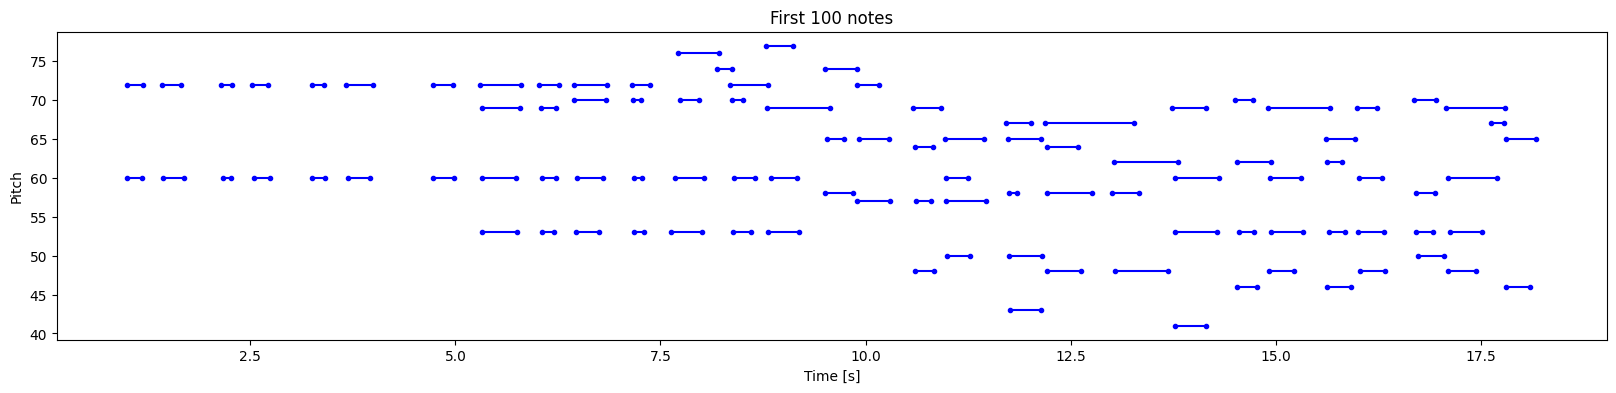

In [19]:
plot_piano_roll(raw_notes, count=100)

トラック全体のノートをプロットします。

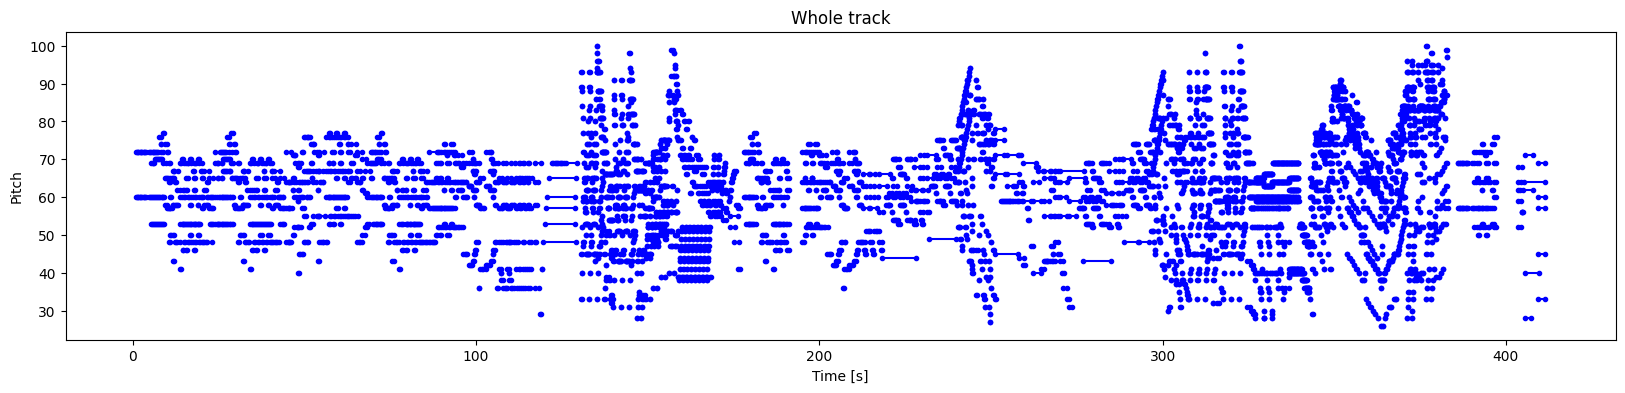

In [20]:
plot_piano_roll(raw_notes)

各ノート変数の分布を確認します。

In [21]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

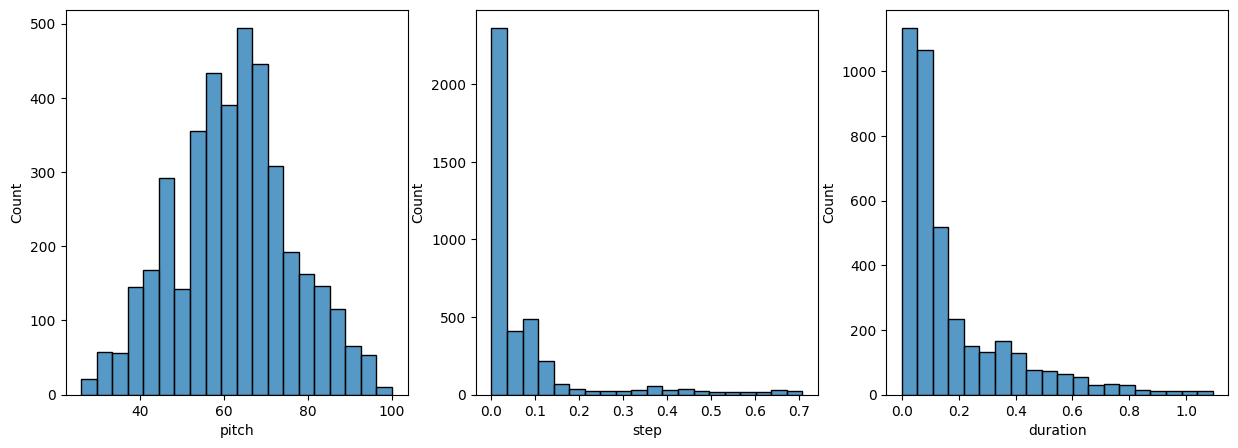

In [22]:
plot_distributions(raw_notes)

## MIDI ファイルを作成する

以下の関数を使用して、ノートのリストから独自の MIDI を生成できます。

In [23]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [24]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

生成した MIDI ファイルを再生し、何らかの違いがないか確認します。

In [25]:
display_audio(example_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


前と同様に、`files.download(example_file)` を記述すると、このファイルをダウンロードして再生できます。

## トレーニングデータセットを作成する


MIDI ファイルからノートを抽出して、トレーニングデータセットを作成します。まず、少数のファイルを使って作業を開始し、後の方でさらに他のファイルを使用して実験することができます。これには数分かかることがあります。

In [26]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [27]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 16633


次に、解析したノートから [tf.data.Dataset](https://www.tensorflow.org/datasets) を作成します。

In [28]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [29]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

バッチ化されたノートのシーケンスに対してモデルをトレーニングします。各 Example では、入力特徴量としてノートのシーケンス、ラベルとして次のノートが使用されます。このようにすることで、モデルはシーケンスの次のノートを予測するようにトレーニングされます。このプロセスを説明した図（およびその他の詳細）は、[RNN によるテキスト分類](https://www.tensorflow.org/text/tutorials/text_generation)をご覧ください。

このフォーマットで特徴量とラベルを作成するには、便利な [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) 関数とサイズ `seq_length` を使用できます。

In [30]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

各 Example のシーケンスの長さを設定します。さまざまな長さ（50、100, 150 など）を試してデータに最適なものを確認するか、[ハイパーパラメータのチューニング](https://www.tensorflow.org/tutorials/keras/keras_tuner)を行います。語彙のサイズ（`vocab_size`）は 128 で、`pretty_midi` がサポートするすべてのピッチを表します。

In [31]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

データセットの形状は `(100,1)` で、モデルは 100 個のノートを入力として取り、出力として移行のノートの予測を学習します。

In [32]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5390625  0.         2.37239583]
 [0.390625   0.01302083 1.30859375]
 [0.5078125  0.00390625 0.77604167]
 [0.484375   0.00520833 0.42708333]
 [0.46875    0.76041667 0.48046875]
 [0.5        0.0234375  0.67838542]
 [0.484375   0.82291667 1.03515625]
 [0.4609375  0.00390625 1.09635417]
 [0.40625    0.02213542 1.02473958]
 [0.53125    0.70182292 0.37239583]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=76.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.016927083333333925>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.33984375>}


Example をバッチ処理し、パフォーマンスを得られるようにデータセットを構成します。

In [33]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [34]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## モデルを作成してトレーニングする

このモデルには、ノート変数あたり 1 つの出力、計 3 つの出力があります。`step` と `duration` については、モデルが負でない値を出力するように、平均二条誤差に基づくカスタム損失関数を使用します。

In [35]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [36]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            


 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             


 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                


 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                


 step (Dense)                (None, 1)                    129       ['lstm[0][0]']                


Total params: 84354 (329.51 KB)


Trainable params: 84354 (329.51 KB)


Non-trainable params: 0 (0.00 Byte)


__________________________________________________________________________________________________


`model.evaluate` 関数をテストすると、`pitch` の損失が `step` と `duration` の損失を大きく上回ることがわかります。`loss` はその他すべての損失を合計して算出された合計損失であり、現在 `pitch` 損失に占有されていることに注意してください。

In [37]:
losses = model.evaluate(train_ds, return_dict=True)
losses

      1/Unknown - 3s 3s/step - loss: 5.1505 - duration_loss: 0.2831 - pitch_loss: 4.8471 - step_loss: 0.0202

     18/Unknown - 3s 3ms/step - loss: 5.1070 - duration_loss: 0.2196 - pitch_loss: 4.8493 - step_loss: 0.0381

     36/Unknown - 3s 3ms/step - loss: 5.1185 - duration_loss: 0.2235 - pitch_loss: 4.8484 - step_loss: 0.0466

     54/Unknown - 3s 3ms/step - loss: 5.0916 - duration_loss: 0.2001 - pitch_loss: 4.8481 - step_loss: 0.0434

     72/Unknown - 3s 3ms/step - loss: 5.1067 - duration_loss: 0.2147 - pitch_loss: 4.8484 - step_loss: 0.0437

     91/Unknown - 3s 3ms/step - loss: 5.1055 - duration_loss: 0.2088 - pitch_loss: 4.8485 - step_loss: 0.0482

    110/Unknown - 3s 3ms/step - loss: 5.1294 - duration_loss: 0.2290 - pitch_loss: 4.8485 - step_loss: 0.0518

    129/Unknown - 3s 3ms/step - loss: 5.1352 - duration_loss: 0.2356 - pitch_loss: 4.8486 - step_loss: 0.0509

    148/Unknown - 3s 3ms/step - loss: 5.1324 - duration_loss: 0.2272 - pitch_loss: 4.8489 - step_loss: 0.0563

    167/Unknown - 4s 3ms/step - loss: 5.1338 - duration_loss: 0.2233 - pitch_loss: 4.8491 - step_loss: 0.0614

    186/Unknown - 4s 3ms/step - loss: 5.1331 - duration_loss: 0.2258 - pitch_loss: 4.8491 - step_loss: 0.0583

    204/Unknown - 4s 3ms/step - loss: 5.1331 - duration_loss: 0.2265 - pitch_loss: 4.8491 - step_loss: 0.0575

    223/Unknown - 4s 3ms/step - loss: 5.1309 - duration_loss: 0.2250 - pitch_loss: 4.8492 - step_loss: 0.0567

    243/Unknown - 4s 3ms/step - loss: 5.1370 - duration_loss: 0.2332 - pitch_loss: 4.8491 - step_loss: 0.0546

259/259 [==============================] - 4s 3ms/step - loss: 5.1320 - duration_loss: 0.2264 - pitch_loss: 4.8492 - step_loss: 0.0565


{'loss': 5.132046222686768,
 'duration_loss': 0.2263597846031189,
 'pitch_loss': 4.849214553833008,
 'step_loss': 0.056468527764081955}

これを平衡化する方法として、`loss_weights` 引数を使用してコンパイルする方法が挙げられます。

In [38]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

これにより、`loss` は個別の損失の重み付き合計になります。

In [39]:
model.evaluate(train_ds, return_dict=True)

      1/Unknown - 1s 801ms/step - loss: 0.5457 - duration_loss: 0.2831 - pitch_loss: 4.8471 - step_loss: 0.0202

     20/Unknown - 1s 3ms/step - loss: 0.4960 - duration_loss: 0.2104 - pitch_loss: 4.8486 - step_loss: 0.0432  

     39/Unknown - 1s 3ms/step - loss: 0.5079 - duration_loss: 0.2200 - pitch_loss: 4.8484 - step_loss: 0.0455

     58/Unknown - 1s 3ms/step - loss: 0.4843 - duration_loss: 0.1987 - pitch_loss: 4.8482 - step_loss: 0.0431

     77/Unknown - 1s 3ms/step - loss: 0.4994 - duration_loss: 0.2101 - pitch_loss: 4.8484 - step_loss: 0.0468

     96/Unknown - 1s 3ms/step - loss: 0.4964 - duration_loss: 0.2066 - pitch_loss: 4.8485 - step_loss: 0.0474

    115/Unknown - 1s 3ms/step - loss: 0.5375 - duration_loss: 0.2432 - pitch_loss: 4.8487 - step_loss: 0.0518

    134/Unknown - 1s 3ms/step - loss: 0.5274 - duration_loss: 0.2314 - pitch_loss: 4.8488 - step_loss: 0.0535

    153/Unknown - 1s 3ms/step - loss: 0.5218 - duration_loss: 0.2240 - pitch_loss: 4.8489 - step_loss: 0.0554

    172/Unknown - 1s 3ms/step - loss: 0.5261 - duration_loss: 0.2231 - pitch_loss: 4.8490 - step_loss: 0.0605

    190/Unknown - 1s 3ms/step - loss: 0.5258 - duration_loss: 0.2241 - pitch_loss: 4.8490 - step_loss: 0.0593

    209/Unknown - 1s 3ms/step - loss: 0.5287 - duration_loss: 0.2293 - pitch_loss: 4.8491 - step_loss: 0.0569

    228/Unknown - 1s 3ms/step - loss: 0.5341 - duration_loss: 0.2356 - pitch_loss: 4.8492 - step_loss: 0.0560

    247/Unknown - 1s 3ms/step - loss: 0.5322 - duration_loss: 0.2327 - pitch_loss: 4.8492 - step_loss: 0.0571

259/259 [==============================] - 2s 3ms/step - loss: 0.5253 - duration_loss: 0.2264 - pitch_loss: 4.8492 - step_loss: 0.0565


{'loss': 0.5252891778945923,
 'duration_loss': 0.2263597846031189,
 'pitch_loss': 4.849214553833008,
 'step_loss': 0.056468527764081955}

モデルをトレーニングする。

In [40]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [41]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50


I0000 00:00:1705010474.343264  988398 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      1/Unknown - 3s 3s/step - loss: 0.5457 - duration_loss: 0.2831 - pitch_loss: 4.8471 - step_loss: 0.0202

     12/Unknown - 3s 5ms/step - loss: 0.4808 - duration_loss: 0.2060 - pitch_loss: 4.7753 - step_loss: 0.0361

     24/Unknown - 3s 4ms/step - loss: 0.4319 - duration_loss: 0.1616 - pitch_loss: 4.7208 - step_loss: 0.0343

     36/Unknown - 3s 4ms/step - loss: 0.4274 - duration_loss: 0.1566 - pitch_loss: 4.6553 - step_loss: 0.0380

     48/Unknown - 3s 4ms/step - loss: 0.4013 - duration_loss: 0.1351 - pitch_loss: 4.5851 - step_loss: 0.0369

     60/Unknown - 3s 4ms/step - loss: 0.3829 - duration_loss: 0.1237 - pitch_loss: 4.4980 - step_loss: 0.0343

     72/Unknown - 3s 4ms/step - loss: 0.3965 - duration_loss: 0.1388 - pitch_loss: 4.4226 - step_loss: 0.0365

     84/Unknown - 3s 4ms/step - loss: 0.3951 - duration_loss: 0.1348 - pitch_loss: 4.3758 - step_loss: 0.0415

     97/Unknown - 3s 4ms/step - loss: 0.4013 - duration_loss: 0.1452 - pitch_loss: 4.3291 - step_loss: 0.0396

    109/Unknown - 3s 4ms/step - loss: 0.4169 - duration_loss: 0.1603 - pitch_loss: 4.2896 - step_loss: 0.0422

    121/Unknown - 3s 4ms/step - loss: 0.4180 - duration_loss: 0.1635 - pitch_loss: 4.2497 - step_loss: 0.0420

    133/Unknown - 3s 4ms/step - loss: 0.4132 - duration_loss: 0.1573 - pitch_loss: 4.2260 - step_loss: 0.0446

    145/Unknown - 3s 4ms/step - loss: 0.4089 - duration_loss: 0.1508 - pitch_loss: 4.2091 - step_loss: 0.0476

    157/Unknown - 4s 4ms/step - loss: 0.4108 - duration_loss: 0.1489 - pitch_loss: 4.1918 - step_loss: 0.0523

    170/Unknown - 4s 4ms/step - loss: 0.4068 - duration_loss: 0.1472 - pitch_loss: 4.1731 - step_loss: 0.0510

    183/Unknown - 4s 4ms/step - loss: 0.4015 - duration_loss: 0.1447 - pitch_loss: 4.1513 - step_loss: 0.0493

    196/Unknown - 4s 4ms/step - loss: 0.3997 - duration_loss: 0.1442 - pitch_loss: 4.1344 - step_loss: 0.0487

    208/Unknown - 4s 4ms/step - loss: 0.3985 - duration_loss: 0.1452 - pitch_loss: 4.1163 - step_loss: 0.0474

    220/Unknown - 4s 4ms/step - loss: 0.3937 - duration_loss: 0.1416 - pitch_loss: 4.1008 - step_loss: 0.0471

    232/Unknown - 4s 4ms/step - loss: 0.3919 - duration_loss: 0.1411 - pitch_loss: 4.0879 - step_loss: 0.0463

    244/Unknown - 4s 4ms/step - loss: 0.3887 - duration_loss: 0.1397 - pitch_loss: 4.0787 - step_loss: 0.0451

    256/Unknown - 4s 4ms/step - loss: 0.3905 - duration_loss: 0.1405 - pitch_loss: 4.0666 - step_loss: 0.0466

259/259 [==============================] - 4s 5ms/step - loss: 0.3892 - duration_loss: 0.1395 - pitch_loss: 4.0668 - step_loss: 0.0464


Epoch 2/50


  1/259 [..............................] - ETA: 1s - loss: 0.3841 - duration_loss: 0.1728 - pitch_loss: 3.7764 - step_loss: 0.0225

 13/259 [>.............................] - ETA: 1s - loss: 0.3836 - duration_loss: 0.1546 - pitch_loss: 3.8721 - step_loss: 0.0353

 25/259 [=>............................] - ETA: 0s - loss: 0.3654 - duration_loss: 0.1398 - pitch_loss: 3.8474 - step_loss: 0.0332

 37/259 [===>..........................] - ETA: 0s - loss: 0.3615 - duration_loss: 0.1320 - pitch_loss: 3.8604 - step_loss: 0.0365

 50/259 [====>.........................] - ETA: 0s - loss: 0.3447 - duration_loss: 0.1163 - pitch_loss: 3.8652 - step_loss: 0.0352

 63/259 [======>.......................] - ETA: 0s - loss: 0.3367 - duration_loss: 0.1091 - pitch_loss: 3.8676 - step_loss: 0.0342

 75/259 [=======>......................] - ETA: 0s - loss: 0.3495 - duration_loss: 0.1222 - pitch_loss: 3.8707 - step_loss: 0.0337

 87/259 [=========>....................] - ETA: 0s - loss: 0.3546 - duration_loss: 0.1233 - pitch_loss: 3.8625 - step_loss: 0.0382

 99/259 [==========>...................] - ETA: 0s - loss: 0.3697 - duration_loss: 0.1393 - pitch_loss: 3.8650 - step_loss: 0.0372

111/259 [===========>..................] - ETA: 0s - loss: 0.3765 - duration_loss: 0.1443 - pitch_loss: 3.8608 - step_loss: 0.0391

123/259 [=============>................] - ETA: 0s - loss: 0.3792 - duration_loss: 0.1473 - pitch_loss: 3.8592 - step_loss: 0.0389

135/259 [==============>...............] - ETA: 0s - loss: 0.3756 - duration_loss: 0.1422 - pitch_loss: 3.8616 - step_loss: 0.0404

147/259 [================>.............] - ETA: 0s - loss: 0.3738 - duration_loss: 0.1371 - pitch_loss: 3.8585 - step_loss: 0.0438

159/259 [=================>............] - ETA: 0s - loss: 0.3787 - duration_loss: 0.1372 - pitch_loss: 3.8586 - step_loss: 0.0486

172/259 [==================>...........] - ETA: 0s - loss: 0.3764 - duration_loss: 0.1356 - pitch_loss: 3.8615 - step_loss: 0.0477

184/259 [====================>.........] - ETA: 0s - loss: 0.3721 - duration_loss: 0.1330 - pitch_loss: 3.8595 - step_loss: 0.0461

196/259 [=====================>........] - ETA: 0s - loss: 0.3719 - duration_loss: 0.1330 - pitch_loss: 3.8594 - step_loss: 0.0459

209/259 [=======================>......] - ETA: 0s - loss: 0.3715 - duration_loss: 0.1341 - pitch_loss: 3.8552 - step_loss: 0.0447

222/259 [========================>.....] - ETA: 0s - loss: 0.3684 - duration_loss: 0.1312 - pitch_loss: 3.8538 - step_loss: 0.0445

235/259 [==========================>...] - ETA: 0s - loss: 0.3664 - duration_loss: 0.1303 - pitch_loss: 3.8518 - step_loss: 0.0435

247/259 [===========================>..] - ETA: 0s - loss: 0.3671 - duration_loss: 0.1297 - pitch_loss: 3.8529 - step_loss: 0.0448

259/259 [==============================] - ETA: 0s - loss: 0.3665 - duration_loss: 0.1298 - pitch_loss: 3.8530 - step_loss: 0.0440

259/259 [==============================] - 1s 4ms/step - loss: 0.3665 - duration_loss: 0.1298 - pitch_loss: 3.8530 - step_loss: 0.0440


Epoch 3/50


  1/259 [..............................] - ETA: 1s - loss: 0.3797 - duration_loss: 0.1655 - pitch_loss: 3.7536 - step_loss: 0.0265

 13/259 [>.............................] - ETA: 1s - loss: 0.3785 - duration_loss: 0.1503 - pitch_loss: 3.8494 - step_loss: 0.0357

 25/259 [=>............................] - ETA: 0s - loss: 0.3614 - duration_loss: 0.1362 - pitch_loss: 3.8258 - step_loss: 0.0339

 37/259 [===>..........................] - ETA: 0s - loss: 0.3573 - duration_loss: 0.1285 - pitch_loss: 3.8381 - step_loss: 0.0368

 49/259 [====>.........................] - ETA: 0s - loss: 0.3433 - duration_loss: 0.1152 - pitch_loss: 3.8441 - step_loss: 0.0358

 62/259 [======>.......................] - ETA: 0s - loss: 0.3315 - duration_loss: 0.1057 - pitch_loss: 3.8489 - step_loss: 0.0334

 75/259 [=======>......................] - ETA: 0s - loss: 0.3452 - duration_loss: 0.1191 - pitch_loss: 3.8515 - step_loss: 0.0335

 87/259 [=========>....................] - ETA: 0s - loss: 0.3512 - duration_loss: 0.1209 - pitch_loss: 3.8440 - step_loss: 0.0381

 99/259 [==========>...................] - ETA: 0s - loss: 0.3659 - duration_loss: 0.1366 - pitch_loss: 3.8476 - step_loss: 0.0369

111/259 [===========>..................] - ETA: 0s - loss: 0.3735 - duration_loss: 0.1427 - pitch_loss: 3.8442 - step_loss: 0.0386

123/259 [=============>................] - ETA: 0s - loss: 0.3764 - duration_loss: 0.1459 - pitch_loss: 3.8433 - step_loss: 0.0384

135/259 [==============>...............] - ETA: 0s - loss: 0.3730 - duration_loss: 0.1409 - pitch_loss: 3.8458 - step_loss: 0.0398

148/259 [================>.............] - ETA: 0s - loss: 0.3717 - duration_loss: 0.1364 - pitch_loss: 3.8434 - step_loss: 0.0431

161/259 [=================>............] - ETA: 0s - loss: 0.3754 - duration_loss: 0.1351 - pitch_loss: 3.8446 - step_loss: 0.0481

174/259 [===================>..........] - ETA: 0s - loss: 0.3726 - duration_loss: 0.1335 - pitch_loss: 3.8469 - step_loss: 0.0468

187/259 [====================>.........] - ETA: 0s - loss: 0.3701 - duration_loss: 0.1323 - pitch_loss: 3.8460 - step_loss: 0.0455

200/259 [======================>.......] - ETA: 0s - loss: 0.3671 - duration_loss: 0.1299 - pitch_loss: 3.8446 - step_loss: 0.0450

212/259 [=======================>......] - ETA: 0s - loss: 0.3676 - duration_loss: 0.1316 - pitch_loss: 3.8417 - step_loss: 0.0440

224/259 [========================>.....] - ETA: 0s - loss: 0.3671 - duration_loss: 0.1311 - pitch_loss: 3.8404 - step_loss: 0.0440

236/259 [==========================>...] - ETA: 0s - loss: 0.3633 - duration_loss: 0.1285 - pitch_loss: 3.8380 - step_loss: 0.0430

248/259 [===========================>..] - ETA: 0s - loss: 0.3645 - duration_loss: 0.1282 - pitch_loss: 3.8388 - step_loss: 0.0444

259/259 [==============================] - 1s 4ms/step - loss: 0.3638 - duration_loss: 0.1282 - pitch_loss: 3.8394 - step_loss: 0.0437


Epoch 4/50


  1/259 [..............................] - ETA: 1s - loss: 0.3662 - duration_loss: 0.1551 - pitch_loss: 3.7490 - step_loss: 0.0236

 13/259 [>.............................] - ETA: 1s - loss: 0.3733 - duration_loss: 0.1469 - pitch_loss: 3.8399 - step_loss: 0.0344

 25/259 [=>............................] - ETA: 0s - loss: 0.3576 - duration_loss: 0.1341 - pitch_loss: 3.8155 - step_loss: 0.0328

 37/259 [===>..........................] - ETA: 0s - loss: 0.3533 - duration_loss: 0.1259 - pitch_loss: 3.8269 - step_loss: 0.0361

 49/259 [====>.........................] - ETA: 0s - loss: 0.3401 - duration_loss: 0.1131 - pitch_loss: 3.8332 - step_loss: 0.0353

 61/259 [======>.......................] - ETA: 0s - loss: 0.3294 - duration_loss: 0.1044 - pitch_loss: 3.8395 - step_loss: 0.0331

 73/259 [=======>......................] - ETA: 0s - loss: 0.3432 - duration_loss: 0.1185 - pitch_loss: 3.8387 - step_loss: 0.0328

 86/259 [========>.....................] - ETA: 0s - loss: 0.3436 - duration_loss: 0.1140 - pitch_loss: 3.8340 - step_loss: 0.0379

 98/259 [==========>...................] - ETA: 0s - loss: 0.3635 - duration_loss: 0.1349 - pitch_loss: 3.8352 - step_loss: 0.0368

110/259 [===========>..................] - ETA: 0s - loss: 0.3715 - duration_loss: 0.1414 - pitch_loss: 3.8350 - step_loss: 0.0384

122/259 [=============>................] - ETA: 0s - loss: 0.3747 - duration_loss: 0.1449 - pitch_loss: 3.8322 - step_loss: 0.0382

135/259 [==============>...............] - ETA: 0s - loss: 0.3705 - duration_loss: 0.1393 - pitch_loss: 3.8349 - step_loss: 0.0394

148/259 [================>.............] - ETA: 0s - loss: 0.3692 - duration_loss: 0.1348 - pitch_loss: 3.8327 - step_loss: 0.0428

160/259 [=================>............] - ETA: 0s - loss: 0.3731 - duration_loss: 0.1341 - pitch_loss: 3.8327 - step_loss: 0.0474

173/259 [===================>..........] - ETA: 0s - loss: 0.3709 - duration_loss: 0.1328 - pitch_loss: 3.8359 - step_loss: 0.0463

185/259 [====================>.........] - ETA: 0s - loss: 0.3673 - duration_loss: 0.1307 - pitch_loss: 3.8349 - step_loss: 0.0449

197/259 [=====================>........] - ETA: 0s - loss: 0.3663 - duration_loss: 0.1298 - pitch_loss: 3.8342 - step_loss: 0.0447

209/259 [=======================>......] - ETA: 0s - loss: 0.3666 - duration_loss: 0.1313 - pitch_loss: 3.8309 - step_loss: 0.0437

221/259 [========================>.....] - ETA: 0s - loss: 0.3638 - duration_loss: 0.1288 - pitch_loss: 3.8296 - step_loss: 0.0435

233/259 [=========================>....] - ETA: 0s - loss: 0.3618 - duration_loss: 0.1276 - pitch_loss: 3.8274 - step_loss: 0.0428

245/259 [===========================>..] - ETA: 0s - loss: 0.3599 - duration_loss: 0.1267 - pitch_loss: 3.8288 - step_loss: 0.0418

257/259 [============================>.] - ETA: 0s - loss: 0.3620 - duration_loss: 0.1273 - pitch_loss: 3.8272 - step_loss: 0.0433

259/259 [==============================] - 1s 4ms/step - loss: 0.3615 - duration_loss: 0.1269 - pitch_loss: 3.8292 - step_loss: 0.0431


Epoch 5/50


  1/259 [..............................] - ETA: 1s - loss: 0.3640 - duration_loss: 0.1516 - pitch_loss: 3.7477 - step_loss: 0.0250

 13/259 [>.............................] - ETA: 1s - loss: 0.3731 - duration_loss: 0.1466 - pitch_loss: 3.8334 - step_loss: 0.0348

 25/259 [=>............................] - ETA: 0s - loss: 0.3563 - duration_loss: 0.1334 - pitch_loss: 3.8083 - step_loss: 0.0325

 38/259 [===>..........................] - ETA: 0s - loss: 0.3486 - duration_loss: 0.1223 - pitch_loss: 3.8197 - step_loss: 0.0354

 50/259 [====>.........................] - ETA: 0s - loss: 0.3356 - duration_loss: 0.1100 - pitch_loss: 3.8250 - step_loss: 0.0344

 62/259 [======>.......................] - ETA: 0s - loss: 0.3260 - duration_loss: 0.1019 - pitch_loss: 3.8299 - step_loss: 0.0325

 74/259 [=======>......................] - ETA: 0s - loss: 0.3399 - duration_loss: 0.1159 - pitch_loss: 3.8325 - step_loss: 0.0325

 86/259 [========>.....................] - ETA: 0s - loss: 0.3413 - duration_loss: 0.1127 - pitch_loss: 3.8251 - step_loss: 0.0374

 98/259 [==========>...................] - ETA: 0s - loss: 0.3615 - duration_loss: 0.1339 - pitch_loss: 3.8264 - step_loss: 0.0363

110/259 [===========>..................] - ETA: 0s - loss: 0.3692 - duration_loss: 0.1403 - pitch_loss: 3.8257 - step_loss: 0.0376

122/259 [=============>................] - ETA: 0s - loss: 0.3727 - duration_loss: 0.1442 - pitch_loss: 3.8224 - step_loss: 0.0374

134/259 [==============>...............] - ETA: 0s - loss: 0.3701 - duration_loss: 0.1398 - pitch_loss: 3.8256 - step_loss: 0.0390

146/259 [===============>..............] - ETA: 0s - loss: 0.3680 - duration_loss: 0.1345 - pitch_loss: 3.8233 - step_loss: 0.0423

158/259 [=================>............] - ETA: 0s - loss: 0.3706 - duration_loss: 0.1328 - pitch_loss: 3.8226 - step_loss: 0.0467

170/259 [==================>...........] - ETA: 0s - loss: 0.3695 - duration_loss: 0.1324 - pitch_loss: 3.8252 - step_loss: 0.0458

182/259 [====================>.........] - ETA: 0s - loss: 0.3663 - duration_loss: 0.1309 - pitch_loss: 3.8230 - step_loss: 0.0442

194/259 [=====================>........] - ETA: 0s - loss: 0.3638 - duration_loss: 0.1285 - pitch_loss: 3.8255 - step_loss: 0.0441

206/259 [======================>.......] - ETA: 0s - loss: 0.3667 - duration_loss: 0.1324 - pitch_loss: 3.8212 - step_loss: 0.0432

218/259 [========================>.....] - ETA: 0s - loss: 0.3631 - duration_loss: 0.1291 - pitch_loss: 3.8194 - step_loss: 0.0431

230/259 [=========================>....] - ETA: 0s - loss: 0.3617 - duration_loss: 0.1285 - pitch_loss: 3.8188 - step_loss: 0.0423

242/259 [===========================>..] - ETA: 0s - loss: 0.3595 - duration_loss: 0.1273 - pitch_loss: 3.8191 - step_loss: 0.0412

254/259 [============================>.] - ETA: 0s - loss: 0.3612 - duration_loss: 0.1273 - pitch_loss: 3.8177 - step_loss: 0.0430

259/259 [==============================] - 1s 4ms/step - loss: 0.3601 - duration_loss: 0.1266 - pitch_loss: 3.8196 - step_loss: 0.0425


Epoch 6/50


  1/259 [..............................] - ETA: 1s - loss: 0.3632 - duration_loss: 0.1487 - pitch_loss: 3.7386 - step_loss: 0.0275

 13/259 [>.............................] - ETA: 1s - loss: 0.3746 - duration_loss: 0.1484 - pitch_loss: 3.8201 - step_loss: 0.0351

 26/259 [==>...........................] - ETA: 0s - loss: 0.3581 - duration_loss: 0.1296 - pitch_loss: 3.7957 - step_loss: 0.0387

 38/259 [===>..........................] - ETA: 0s - loss: 0.3470 - duration_loss: 0.1212 - pitch_loss: 3.8077 - step_loss: 0.0354

 51/259 [====>.........................] - ETA: 0s - loss: 0.3319 - duration_loss: 0.1078 - pitch_loss: 3.8108 - step_loss: 0.0336

 64/259 [======>.......................] - ETA: 0s - loss: 0.3232 - duration_loss: 0.0999 - pitch_loss: 3.8190 - step_loss: 0.0324

 77/259 [=======>......................] - ETA: 0s - loss: 0.3404 - duration_loss: 0.1149 - pitch_loss: 3.8178 - step_loss: 0.0347

 90/259 [=========>....................] - ETA: 0s - loss: 0.3423 - duration_loss: 0.1161 - pitch_loss: 3.8098 - step_loss: 0.0357

103/259 [==========>...................] - ETA: 0s - loss: 0.3565 - duration_loss: 0.1313 - pitch_loss: 3.8110 - step_loss: 0.0346

116/259 [============>.................] - ETA: 0s - loss: 0.3738 - duration_loss: 0.1468 - pitch_loss: 3.8113 - step_loss: 0.0365

129/259 [=============>................] - ETA: 0s - loss: 0.3671 - duration_loss: 0.1408 - pitch_loss: 3.8098 - step_loss: 0.0358

142/259 [===============>..............] - ETA: 0s - loss: 0.3621 - duration_loss: 0.1344 - pitch_loss: 3.8092 - step_loss: 0.0373

154/259 [================>.............] - ETA: 0s - loss: 0.3685 - duration_loss: 0.1318 - pitch_loss: 3.8082 - step_loss: 0.0463

167/259 [==================>...........] - ETA: 0s - loss: 0.3648 - duration_loss: 0.1291 - pitch_loss: 3.8121 - step_loss: 0.0451

180/259 [===================>..........] - ETA: 0s - loss: 0.3645 - duration_loss: 0.1305 - pitch_loss: 3.8109 - step_loss: 0.0434

193/259 [=====================>........] - ETA: 0s - loss: 0.3601 - duration_loss: 0.1264 - pitch_loss: 3.8128 - step_loss: 0.0430

206/259 [======================>.......] - ETA: 0s - loss: 0.3630 - duration_loss: 0.1305 - pitch_loss: 3.8081 - step_loss: 0.0421

218/259 [========================>.....] - ETA: 0s - loss: 0.3595 - duration_loss: 0.1272 - pitch_loss: 3.8061 - step_loss: 0.0420

231/259 [=========================>....] - ETA: 0s - loss: 0.3578 - duration_loss: 0.1265 - pitch_loss: 3.8051 - step_loss: 0.0411

243/259 [===========================>..] - ETA: 0s - loss: 0.3560 - duration_loss: 0.1255 - pitch_loss: 3.8059 - step_loss: 0.0402

255/259 [============================>.] - ETA: 0s - loss: 0.3576 - duration_loss: 0.1256 - pitch_loss: 3.8037 - step_loss: 0.0418

259/259 [==============================] - 1s 4ms/step - loss: 0.3568 - duration_loss: 0.1251 - pitch_loss: 3.8059 - step_loss: 0.0414


Epoch 7/50


  1/259 [..............................] - ETA: 1s - loss: 0.4059 - duration_loss: 0.1732 - pitch_loss: 3.7484 - step_loss: 0.0453

 14/259 [>.............................] - ETA: 0s - loss: 0.3713 - duration_loss: 0.1481 - pitch_loss: 3.7876 - step_loss: 0.0338

 27/259 [==>...........................] - ETA: 0s - loss: 0.3559 - duration_loss: 0.1290 - pitch_loss: 3.7770 - step_loss: 0.0381

 40/259 [===>..........................] - ETA: 0s - loss: 0.3514 - duration_loss: 0.1267 - pitch_loss: 3.7926 - step_loss: 0.0350

 53/259 [=====>........................] - ETA: 0s - loss: 0.3285 - duration_loss: 0.1056 - pitch_loss: 3.8013 - step_loss: 0.0329

 66/259 [======>.......................] - ETA: 0s - loss: 0.3215 - duration_loss: 0.0999 - pitch_loss: 3.8039 - step_loss: 0.0314

 79/259 [========>.....................] - ETA: 0s - loss: 0.3370 - duration_loss: 0.1133 - pitch_loss: 3.8011 - step_loss: 0.0337

 92/259 [=========>....................] - ETA: 0s - loss: 0.3450 - duration_loss: 0.1209 - pitch_loss: 3.7960 - step_loss: 0.0343

105/259 [===========>..................] - ETA: 0s - loss: 0.3534 - duration_loss: 0.1302 - pitch_loss: 3.7946 - step_loss: 0.0334

118/259 [============>.................] - ETA: 0s - loss: 0.3682 - duration_loss: 0.1436 - pitch_loss: 3.7927 - step_loss: 0.0350

131/259 [==============>...............] - ETA: 0s - loss: 0.3620 - duration_loss: 0.1376 - pitch_loss: 3.7933 - step_loss: 0.0347

144/259 [===============>..............] - ETA: 0s - loss: 0.3615 - duration_loss: 0.1316 - pitch_loss: 3.7900 - step_loss: 0.0404

157/259 [=================>............] - ETA: 0s - loss: 0.3654 - duration_loss: 0.1314 - pitch_loss: 3.7890 - step_loss: 0.0446

170/259 [==================>...........] - ETA: 0s - loss: 0.3638 - duration_loss: 0.1307 - pitch_loss: 3.7911 - step_loss: 0.0436

183/259 [====================>.........] - ETA: 0s - loss: 0.3600 - duration_loss: 0.1284 - pitch_loss: 3.7893 - step_loss: 0.0421

196/259 [=====================>........] - ETA: 0s - loss: 0.3588 - duration_loss: 0.1274 - pitch_loss: 3.7882 - step_loss: 0.0419

208/259 [=======================>......] - ETA: 0s - loss: 0.3586 - duration_loss: 0.1283 - pitch_loss: 3.7852 - step_loss: 0.0411

220/259 [========================>.....] - ETA: 0s - loss: 0.3553 - duration_loss: 0.1253 - pitch_loss: 3.7820 - step_loss: 0.0409

233/259 [=========================>....] - ETA: 0s - loss: 0.3532 - duration_loss: 0.1240 - pitch_loss: 3.7793 - step_loss: 0.0402

246/259 [===========================>..] - ETA: 0s - loss: 0.3518 - duration_loss: 0.1234 - pitch_loss: 3.7793 - step_loss: 0.0395

259/259 [==============================] - ETA: 0s - loss: 0.3527 - duration_loss: 0.1233 - pitch_loss: 3.7797 - step_loss: 0.0404

259/259 [==============================] - 1s 4ms/step - loss: 0.3527 - duration_loss: 0.1233 - pitch_loss: 3.7797 - step_loss: 0.0404


Epoch 8/50


  1/259 [..............................] - ETA: 1s - loss: 0.3560 - duration_loss: 0.1441 - pitch_loss: 3.7026 - step_loss: 0.0267

 13/259 [>.............................] - ETA: 1s - loss: 0.3691 - duration_loss: 0.1511 - pitch_loss: 3.7777 - step_loss: 0.0292

 26/259 [==>...........................] - ETA: 0s - loss: 0.3533 - duration_loss: 0.1302 - pitch_loss: 3.7420 - step_loss: 0.0359

 39/259 [===>..........................] - ETA: 0s - loss: 0.3421 - duration_loss: 0.1217 - pitch_loss: 3.7536 - step_loss: 0.0327

 52/259 [=====>........................] - ETA: 0s - loss: 0.3232 - duration_loss: 0.1045 - pitch_loss: 3.7558 - step_loss: 0.0309

 65/259 [======>.......................] - ETA: 0s - loss: 0.3156 - duration_loss: 0.0982 - pitch_loss: 3.7618 - step_loss: 0.0293

 78/259 [========>.....................] - ETA: 0s - loss: 0.3328 - duration_loss: 0.1128 - pitch_loss: 3.7604 - step_loss: 0.0319

 90/259 [=========>....................] - ETA: 0s - loss: 0.3352 - duration_loss: 0.1146 - pitch_loss: 3.7511 - step_loss: 0.0330

103/259 [==========>...................] - ETA: 0s - loss: 0.3478 - duration_loss: 0.1282 - pitch_loss: 3.7523 - step_loss: 0.0319

115/259 [============>.................] - ETA: 0s - loss: 0.3634 - duration_loss: 0.1418 - pitch_loss: 3.7547 - step_loss: 0.0338

127/259 [=============>................] - ETA: 0s - loss: 0.3588 - duration_loss: 0.1377 - pitch_loss: 3.7572 - step_loss: 0.0332

139/259 [===============>..............] - ETA: 0s - loss: 0.3537 - duration_loss: 0.1309 - pitch_loss: 3.7609 - step_loss: 0.0347

151/259 [================>.............] - ETA: 0s - loss: 0.3534 - duration_loss: 0.1273 - pitch_loss: 3.7631 - step_loss: 0.0380

163/259 [=================>............] - ETA: 0s - loss: 0.3590 - duration_loss: 0.1279 - pitch_loss: 3.7670 - step_loss: 0.0428

175/259 [===================>..........] - ETA: 0s - loss: 0.3568 - duration_loss: 0.1270 - pitch_loss: 3.7704 - step_loss: 0.0413

187/259 [====================>.........] - ETA: 0s - loss: 0.3535 - duration_loss: 0.1246 - pitch_loss: 3.7714 - step_loss: 0.0403

199/259 [======================>.......] - ETA: 0s - loss: 0.3520 - duration_loss: 0.1233 - pitch_loss: 3.7705 - step_loss: 0.0402

211/259 [=======================>......] - ETA: 0s - loss: 0.3525 - duration_loss: 0.1246 - pitch_loss: 3.7677 - step_loss: 0.0395

223/259 [========================>.....] - ETA: 0s - loss: 0.3505 - duration_loss: 0.1225 - pitch_loss: 3.7668 - step_loss: 0.0397

236/259 [==========================>...] - ETA: 0s - loss: 0.3476 - duration_loss: 0.1207 - pitch_loss: 3.7641 - step_loss: 0.0387

249/259 [===========================>..] - ETA: 0s - loss: 0.3477 - duration_loss: 0.1198 - pitch_loss: 3.7627 - step_loss: 0.0397

259/259 [==============================] - 1s 4ms/step - loss: 0.3483 - duration_loss: 0.1209 - pitch_loss: 3.7633 - step_loss: 0.0392


Epoch 9/50


  1/259 [..............................] - ETA: 1s - loss: 0.3463 - duration_loss: 0.1356 - pitch_loss: 3.7124 - step_loss: 0.0251

 13/259 [>.............................] - ETA: 1s - loss: 0.3695 - duration_loss: 0.1528 - pitch_loss: 3.7618 - step_loss: 0.0286

 25/259 [=>............................] - ETA: 0s - loss: 0.3501 - duration_loss: 0.1351 - pitch_loss: 3.7255 - step_loss: 0.0287

 37/259 [===>..........................] - ETA: 0s - loss: 0.3409 - duration_loss: 0.1212 - pitch_loss: 3.7359 - step_loss: 0.0329

 49/259 [====>.........................] - ETA: 0s - loss: 0.3273 - duration_loss: 0.1081 - pitch_loss: 3.7424 - step_loss: 0.0321

 61/259 [======>.......................] - ETA: 0s - loss: 0.3163 - duration_loss: 0.0996 - pitch_loss: 3.7464 - step_loss: 0.0294

 74/259 [=======>......................] - ETA: 0s - loss: 0.3291 - duration_loss: 0.1127 - pitch_loss: 3.7499 - step_loss: 0.0289

 87/259 [=========>....................] - ETA: 0s - loss: 0.3344 - duration_loss: 0.1140 - pitch_loss: 3.7389 - step_loss: 0.0335

 99/259 [==========>...................] - ETA: 0s - loss: 0.3443 - duration_loss: 0.1255 - pitch_loss: 3.7376 - step_loss: 0.0320

112/259 [===========>..................] - ETA: 0s - loss: 0.3487 - duration_loss: 0.1285 - pitch_loss: 3.7372 - step_loss: 0.0333

125/259 [=============>................] - ETA: 0s - loss: 0.3518 - duration_loss: 0.1317 - pitch_loss: 3.7417 - step_loss: 0.0331

137/259 [==============>...............] - ETA: 0s - loss: 0.3516 - duration_loss: 0.1296 - pitch_loss: 3.7470 - step_loss: 0.0346

150/259 [================>.............] - ETA: 0s - loss: 0.3506 - duration_loss: 0.1253 - pitch_loss: 3.7483 - step_loss: 0.0379

163/259 [=================>............] - ETA: 0s - loss: 0.3565 - duration_loss: 0.1260 - pitch_loss: 3.7523 - step_loss: 0.0429

175/259 [===================>..........] - ETA: 0s - loss: 0.3546 - duration_loss: 0.1254 - pitch_loss: 3.7561 - step_loss: 0.0414

187/259 [====================>.........] - ETA: 0s - loss: 0.3519 - duration_loss: 0.1236 - pitch_loss: 3.7576 - step_loss: 0.0404

200/259 [======================>.......] - ETA: 0s - loss: 0.3496 - duration_loss: 0.1215 - pitch_loss: 3.7571 - step_loss: 0.0403

212/259 [=======================>......] - ETA: 0s - loss: 0.3499 - duration_loss: 0.1228 - pitch_loss: 3.7547 - step_loss: 0.0394

224/259 [========================>.....] - ETA: 0s - loss: 0.3501 - duration_loss: 0.1228 - pitch_loss: 3.7537 - step_loss: 0.0396

237/259 [==========================>...] - ETA: 0s - loss: 0.3458 - duration_loss: 0.1195 - pitch_loss: 3.7520 - step_loss: 0.0387

249/259 [===========================>..] - ETA: 0s - loss: 0.3466 - duration_loss: 0.1192 - pitch_loss: 3.7505 - step_loss: 0.0399

259/259 [==============================] - 1s 4ms/step - loss: 0.3463 - duration_loss: 0.1194 - pitch_loss: 3.7512 - step_loss: 0.0394


Epoch 10/50


  1/259 [..............................] - ETA: 1s - loss: 0.3469 - duration_loss: 0.1407 - pitch_loss: 3.7135 - step_loss: 0.0205

 13/259 [>.............................] - ETA: 1s - loss: 0.3627 - duration_loss: 0.1477 - pitch_loss: 3.7556 - step_loss: 0.0273

 25/259 [=>............................] - ETA: 0s - loss: 0.3474 - duration_loss: 0.1328 - pitch_loss: 3.7145 - step_loss: 0.0289

 38/259 [===>..........................] - ETA: 0s - loss: 0.3349 - duration_loss: 0.1168 - pitch_loss: 3.7250 - step_loss: 0.0319

 51/259 [====>.........................] - ETA: 0s - loss: 0.3192 - duration_loss: 0.1022 - pitch_loss: 3.7286 - step_loss: 0.0305

 63/259 [======>.......................] - ETA: 0s - loss: 0.3133 - duration_loss: 0.0969 - pitch_loss: 3.7373 - step_loss: 0.0295

 76/259 [=======>......................] - ETA: 0s - loss: 0.3303 - duration_loss: 0.1118 - pitch_loss: 3.7436 - step_loss: 0.0314

 88/259 [=========>....................] - ETA: 0s - loss: 0.3343 - duration_loss: 0.1141 - pitch_loss: 3.7310 - step_loss: 0.0337

100/259 [==========>...................] - ETA: 0s - loss: 0.3458 - duration_loss: 0.1269 - pitch_loss: 3.7315 - step_loss: 0.0324

113/259 [============>.................] - ETA: 0s - loss: 0.3580 - duration_loss: 0.1374 - pitch_loss: 3.7318 - step_loss: 0.0340

125/259 [=============>................] - ETA: 0s - loss: 0.3507 - duration_loss: 0.1301 - pitch_loss: 3.7358 - step_loss: 0.0339

138/259 [==============>...............] - ETA: 0s - loss: 0.3500 - duration_loss: 0.1276 - pitch_loss: 3.7417 - step_loss: 0.0354

150/259 [================>.............] - ETA: 0s - loss: 0.3496 - duration_loss: 0.1239 - pitch_loss: 3.7439 - step_loss: 0.0385

162/259 [=================>............] - ETA: 0s - loss: 0.3552 - duration_loss: 0.1248 - pitch_loss: 3.7473 - step_loss: 0.0431

174/259 [===================>..........] - ETA: 0s - loss: 0.3538 - duration_loss: 0.1244 - pitch_loss: 3.7527 - step_loss: 0.0418

186/259 [====================>.........] - ETA: 0s - loss: 0.3488 - duration_loss: 0.1206 - pitch_loss: 3.7542 - step_loss: 0.0405

198/259 [=====================>........] - ETA: 0s - loss: 0.3481 - duration_loss: 0.1198 - pitch_loss: 3.7549 - step_loss: 0.0406

211/259 [=======================>......] - ETA: 0s - loss: 0.3482 - duration_loss: 0.1210 - pitch_loss: 3.7513 - step_loss: 0.0397

223/259 [========================>.....] - ETA: 0s - loss: 0.3464 - duration_loss: 0.1191 - pitch_loss: 3.7505 - step_loss: 0.0398

236/259 [==========================>...] - ETA: 0s - loss: 0.3441 - duration_loss: 0.1178 - pitch_loss: 3.7497 - step_loss: 0.0389

248/259 [===========================>..] - ETA: 0s - loss: 0.3448 - duration_loss: 0.1174 - pitch_loss: 3.7498 - step_loss: 0.0399

259/259 [==============================] - 1s 4ms/step - loss: 0.3438 - duration_loss: 0.1170 - pitch_loss: 3.7499 - step_loss: 0.0393


Epoch 11/50


  1/259 [..............................] - ETA: 1s - loss: 0.3389 - duration_loss: 0.1296 - pitch_loss: 3.7209 - step_loss: 0.0232

 13/259 [>.............................] - ETA: 1s - loss: 0.3615 - duration_loss: 0.1458 - pitch_loss: 3.7551 - step_loss: 0.0279

 25/259 [=>............................] - ETA: 0s - loss: 0.3465 - duration_loss: 0.1320 - pitch_loss: 3.7276 - step_loss: 0.0281

 38/259 [===>..........................] - ETA: 0s - loss: 0.3360 - duration_loss: 0.1169 - pitch_loss: 3.7478 - step_loss: 0.0318

 51/259 [====>.........................] - ETA: 0s - loss: 0.3205 - duration_loss: 0.1023 - pitch_loss: 3.7519 - step_loss: 0.0306

 64/259 [======>.......................] - ETA: 0s - loss: 0.3133 - duration_loss: 0.0957 - pitch_loss: 3.7620 - step_loss: 0.0295

 77/259 [=======>......................] - ETA: 0s - loss: 0.3307 - duration_loss: 0.1109 - pitch_loss: 3.7592 - step_loss: 0.0319

 90/259 [=========>....................] - ETA: 0s - loss: 0.3328 - duration_loss: 0.1121 - pitch_loss: 3.7464 - step_loss: 0.0334

103/259 [==========>...................] - ETA: 0s - loss: 0.3450 - duration_loss: 0.1255 - pitch_loss: 3.7429 - step_loss: 0.0324

116/259 [============>.................] - ETA: 0s - loss: 0.3592 - duration_loss: 0.1379 - pitch_loss: 3.7425 - step_loss: 0.0342

129/259 [=============>................] - ETA: 0s - loss: 0.3544 - duration_loss: 0.1337 - pitch_loss: 3.7426 - step_loss: 0.0336

141/259 [===============>..............] - ETA: 0s - loss: 0.3499 - duration_loss: 0.1279 - pitch_loss: 3.7425 - step_loss: 0.0348

154/259 [================>.............] - ETA: 0s - loss: 0.3557 - duration_loss: 0.1256 - pitch_loss: 3.7423 - step_loss: 0.0430

167/259 [==================>...........] - ETA: 0s - loss: 0.3528 - duration_loss: 0.1236 - pitch_loss: 3.7458 - step_loss: 0.0420

180/259 [===================>..........] - ETA: 0s - loss: 0.3518 - duration_loss: 0.1243 - pitch_loss: 3.7453 - step_loss: 0.0403

193/259 [=====================>........] - ETA: 0s - loss: 0.3471 - duration_loss: 0.1199 - pitch_loss: 3.7478 - step_loss: 0.0398

206/259 [======================>.......] - ETA: 0s - loss: 0.3493 - duration_loss: 0.1228 - pitch_loss: 3.7433 - step_loss: 0.0393

219/259 [========================>.....] - ETA: 0s - loss: 0.3462 - duration_loss: 0.1198 - pitch_loss: 3.7414 - step_loss: 0.0393

232/259 [=========================>....] - ETA: 0s - loss: 0.3432 - duration_loss: 0.1175 - pitch_loss: 3.7408 - step_loss: 0.0387

245/259 [===========================>..] - ETA: 0s - loss: 0.3409 - duration_loss: 0.1162 - pitch_loss: 3.7418 - step_loss: 0.0376

258/259 [============================>.] - ETA: 0s - loss: 0.3421 - duration_loss: 0.1163 - pitch_loss: 3.7404 - step_loss: 0.0387

259/259 [==============================] - 1s 4ms/step - loss: 0.3418 - duration_loss: 0.1162 - pitch_loss: 3.7412 - step_loss: 0.0386


Epoch 12/50


  1/259 [..............................] - ETA: 1s - loss: 0.3521 - duration_loss: 0.1392 - pitch_loss: 3.7265 - step_loss: 0.0266

 14/259 [>.............................] - ETA: 0s - loss: 0.3607 - duration_loss: 0.1424 - pitch_loss: 3.7232 - step_loss: 0.0322

 27/259 [==>...........................] - ETA: 0s - loss: 0.3486 - duration_loss: 0.1268 - pitch_loss: 3.7178 - step_loss: 0.0359

 40/259 [===>..........................] - ETA: 0s - loss: 0.3375 - duration_loss: 0.1181 - pitch_loss: 3.7360 - step_loss: 0.0327

 53/259 [=====>........................] - ETA: 0s - loss: 0.3162 - duration_loss: 0.0988 - pitch_loss: 3.7396 - step_loss: 0.0304

 65/259 [======>.......................] - ETA: 0s - loss: 0.3115 - duration_loss: 0.0951 - pitch_loss: 3.7394 - step_loss: 0.0294

 78/259 [========>.....................] - ETA: 0s - loss: 0.3284 - duration_loss: 0.1097 - pitch_loss: 3.7377 - step_loss: 0.0318

 91/259 [=========>....................] - ETA: 0s - loss: 0.3338 - duration_loss: 0.1145 - pitch_loss: 3.7268 - step_loss: 0.0330

104/259 [===========>..................] - ETA: 0s - loss: 0.3416 - duration_loss: 0.1237 - pitch_loss: 3.7223 - step_loss: 0.0318

117/259 [============>.................] - ETA: 0s - loss: 0.3547 - duration_loss: 0.1352 - pitch_loss: 3.7226 - step_loss: 0.0334

130/259 [==============>...............] - ETA: 0s - loss: 0.3503 - duration_loss: 0.1309 - pitch_loss: 3.7248 - step_loss: 0.0332

143/259 [===============>..............] - ETA: 0s - loss: 0.3494 - duration_loss: 0.1253 - pitch_loss: 3.7228 - step_loss: 0.0379

156/259 [=================>............] - ETA: 0s - loss: 0.3517 - duration_loss: 0.1238 - pitch_loss: 3.7226 - step_loss: 0.0418

168/259 [==================>...........] - ETA: 0s - loss: 0.3485 - duration_loss: 0.1214 - pitch_loss: 3.7267 - step_loss: 0.0408

181/259 [===================>..........] - ETA: 0s - loss: 0.3469 - duration_loss: 0.1214 - pitch_loss: 3.7287 - step_loss: 0.0391

194/259 [=====================>........] - ETA: 0s - loss: 0.3428 - duration_loss: 0.1175 - pitch_loss: 3.7316 - step_loss: 0.0388

207/259 [======================>.......] - ETA: 0s - loss: 0.3429 - duration_loss: 0.1184 - pitch_loss: 3.7286 - step_loss: 0.0381

220/259 [========================>.....] - ETA: 0s - loss: 0.3398 - duration_loss: 0.1151 - pitch_loss: 3.7275 - step_loss: 0.0384

232/259 [=========================>....] - ETA: 0s - loss: 0.3376 - duration_loss: 0.1134 - pitch_loss: 3.7261 - step_loss: 0.0379

244/259 [===========================>..] - ETA: 0s - loss: 0.3360 - duration_loss: 0.1127 - pitch_loss: 3.7272 - step_loss: 0.0370

257/259 [============================>.] - ETA: 0s - loss: 0.3367 - duration_loss: 0.1123 - pitch_loss: 3.7260 - step_loss: 0.0381

259/259 [==============================] - 1s 4ms/step - loss: 0.3363 - duration_loss: 0.1120 - pitch_loss: 3.7274 - step_loss: 0.0379


Epoch 13/50


  1/259 [..............................] - ETA: 1s - loss: 0.3284 - duration_loss: 0.1277 - pitch_loss: 3.6884 - step_loss: 0.0163

 13/259 [>.............................] - ETA: 1s - loss: 0.3533 - duration_loss: 0.1399 - pitch_loss: 3.7198 - step_loss: 0.0274

 25/259 [=>............................] - ETA: 1s - loss: 0.3414 - duration_loss: 0.1290 - pitch_loss: 3.6991 - step_loss: 0.0275

 38/259 [===>..........................] - ETA: 0s - loss: 0.3287 - duration_loss: 0.1107 - pitch_loss: 3.7182 - step_loss: 0.0321

 50/259 [====>.........................] - ETA: 0s - loss: 0.3155 - duration_loss: 0.0978 - pitch_loss: 3.7223 - step_loss: 0.0315

 63/259 [======>.......................] - ETA: 0s - loss: 0.3093 - duration_loss: 0.0930 - pitch_loss: 3.7234 - step_loss: 0.0302

 75/259 [=======>......................] - ETA: 0s - loss: 0.3233 - duration_loss: 0.1069 - pitch_loss: 3.7277 - step_loss: 0.0300

 88/259 [=========>....................] - ETA: 0s - loss: 0.3326 - duration_loss: 0.1126 - pitch_loss: 3.7156 - step_loss: 0.0342

101/259 [==========>...................] - ETA: 0s - loss: 0.3428 - duration_loss: 0.1244 - pitch_loss: 3.7164 - step_loss: 0.0326

114/259 [============>.................] - ETA: 0s - loss: 0.3545 - duration_loss: 0.1348 - pitch_loss: 3.7146 - step_loss: 0.0341

127/259 [=============>................] - ETA: 0s - loss: 0.3507 - duration_loss: 0.1314 - pitch_loss: 3.7165 - step_loss: 0.0335

140/259 [===============>..............] - ETA: 0s - loss: 0.3444 - duration_loss: 0.1241 - pitch_loss: 3.7210 - step_loss: 0.0342

153/259 [================>.............] - ETA: 0s - loss: 0.3444 - duration_loss: 0.1212 - pitch_loss: 3.7197 - step_loss: 0.0372

166/259 [==================>...........] - ETA: 0s - loss: 0.3466 - duration_loss: 0.1194 - pitch_loss: 3.7227 - step_loss: 0.0410

178/259 [===================>..........] - ETA: 0s - loss: 0.3455 - duration_loss: 0.1199 - pitch_loss: 3.7224 - step_loss: 0.0396

191/259 [=====================>........] - ETA: 0s - loss: 0.3418 - duration_loss: 0.1164 - pitch_loss: 3.7248 - step_loss: 0.0391

204/259 [======================>.......] - ETA: 0s - loss: 0.3389 - duration_loss: 0.1146 - pitch_loss: 3.7231 - step_loss: 0.0382

217/259 [========================>.....] - ETA: 0s - loss: 0.3369 - duration_loss: 0.1127 - pitch_loss: 3.7201 - step_loss: 0.0381

230/259 [=========================>....] - ETA: 0s - loss: 0.3360 - duration_loss: 0.1125 - pitch_loss: 3.7205 - step_loss: 0.0375

243/259 [===========================>..] - ETA: 0s - loss: 0.3349 - duration_loss: 0.1122 - pitch_loss: 3.7207 - step_loss: 0.0367

256/259 [============================>.] - ETA: 0s - loss: 0.3354 - duration_loss: 0.1114 - pitch_loss: 3.7195 - step_loss: 0.0380

259/259 [==============================] - 1s 4ms/step - loss: 0.3345 - duration_loss: 0.1107 - pitch_loss: 3.7219 - step_loss: 0.0377


Epoch 14/50


  1/259 [..............................] - ETA: 1s - loss: 0.3398 - duration_loss: 0.1430 - pitch_loss: 3.6884 - step_loss: 0.0124

 14/259 [>.............................] - ETA: 1s - loss: 0.3598 - duration_loss: 0.1477 - pitch_loss: 3.7181 - step_loss: 0.0262

 27/259 [==>...........................] - ETA: 0s - loss: 0.3451 - duration_loss: 0.1262 - pitch_loss: 3.7095 - step_loss: 0.0334

 40/259 [===>..........................] - ETA: 0s - loss: 0.3366 - duration_loss: 0.1189 - pitch_loss: 3.7258 - step_loss: 0.0314

 53/259 [=====>........................] - ETA: 0s - loss: 0.3147 - duration_loss: 0.0987 - pitch_loss: 3.7273 - step_loss: 0.0297

 66/259 [======>.......................] - ETA: 0s - loss: 0.3094 - duration_loss: 0.0946 - pitch_loss: 3.7296 - step_loss: 0.0283

 79/259 [========>.....................] - ETA: 0s - loss: 0.3254 - duration_loss: 0.1077 - pitch_loss: 3.7278 - step_loss: 0.0313

 92/259 [=========>....................] - ETA: 0s - loss: 0.3352 - duration_loss: 0.1167 - pitch_loss: 3.7170 - step_loss: 0.0327

105/259 [===========>..................] - ETA: 0s - loss: 0.3375 - duration_loss: 0.1202 - pitch_loss: 3.7149 - step_loss: 0.0315

118/259 [============>.................] - ETA: 0s - loss: 0.3511 - duration_loss: 0.1321 - pitch_loss: 3.7190 - step_loss: 0.0331

130/259 [==============>...............] - ETA: 0s - loss: 0.3472 - duration_loss: 0.1283 - pitch_loss: 3.7228 - step_loss: 0.0327

143/259 [===============>..............] - ETA: 0s - loss: 0.3459 - duration_loss: 0.1222 - pitch_loss: 3.7221 - step_loss: 0.0375

155/259 [================>.............] - ETA: 0s - loss: 0.3466 - duration_loss: 0.1198 - pitch_loss: 3.7215 - step_loss: 0.0407

168/259 [==================>...........] - ETA: 0s - loss: 0.3429 - duration_loss: 0.1171 - pitch_loss: 3.7249 - step_loss: 0.0396

181/259 [===================>..........] - ETA: 0s - loss: 0.3415 - duration_loss: 0.1171 - pitch_loss: 3.7249 - step_loss: 0.0382

193/259 [=====================>........] - ETA: 0s - loss: 0.3376 - duration_loss: 0.1135 - pitch_loss: 3.7269 - step_loss: 0.0378

206/259 [======================>.......] - ETA: 0s - loss: 0.3359 - duration_loss: 0.1128 - pitch_loss: 3.7230 - step_loss: 0.0369

219/259 [========================>.....] - ETA: 0s - loss: 0.3358 - duration_loss: 0.1124 - pitch_loss: 3.7200 - step_loss: 0.0374

232/259 [=========================>....] - ETA: 0s - loss: 0.3329 - duration_loss: 0.1100 - pitch_loss: 3.7184 - step_loss: 0.0369

245/259 [===========================>..] - ETA: 0s - loss: 0.3314 - duration_loss: 0.1095 - pitch_loss: 3.7188 - step_loss: 0.0360

258/259 [============================>.] - ETA: 0s - loss: 0.3302 - duration_loss: 0.1074 - pitch_loss: 3.7182 - step_loss: 0.0369

259/259 [==============================] - 1s 4ms/step - loss: 0.3302 - duration_loss: 0.1074 - pitch_loss: 3.7192 - step_loss: 0.0368


Epoch 15/50


  1/259 [..............................] - ETA: 1s - loss: 0.3105 - duration_loss: 0.1111 - pitch_loss: 3.6818 - step_loss: 0.0153

 14/259 [>.............................] - ETA: 1s - loss: 0.3492 - duration_loss: 0.1378 - pitch_loss: 3.7004 - step_loss: 0.0263

 27/259 [==>...........................] - ETA: 0s - loss: 0.3415 - duration_loss: 0.1233 - pitch_loss: 3.7015 - step_loss: 0.0331

 40/259 [===>..........................] - ETA: 0s - loss: 0.3358 - duration_loss: 0.1177 - pitch_loss: 3.7179 - step_loss: 0.0322

 53/259 [=====>........................] - ETA: 0s - loss: 0.3138 - duration_loss: 0.0972 - pitch_loss: 3.7204 - step_loss: 0.0306

 66/259 [======>.......................] - ETA: 0s - loss: 0.3086 - duration_loss: 0.0932 - pitch_loss: 3.7228 - step_loss: 0.0293

 79/259 [========>.....................] - ETA: 0s - loss: 0.3239 - duration_loss: 0.1060 - pitch_loss: 3.7215 - step_loss: 0.0318

 92/259 [=========>....................] - ETA: 0s - loss: 0.3334 - duration_loss: 0.1147 - pitch_loss: 3.7106 - step_loss: 0.0332

105/259 [===========>..................] - ETA: 0s - loss: 0.3367 - duration_loss: 0.1191 - pitch_loss: 3.7081 - step_loss: 0.0322

118/259 [============>.................] - ETA: 0s - loss: 0.3488 - duration_loss: 0.1295 - pitch_loss: 3.7100 - step_loss: 0.0338

131/259 [==============>...............] - ETA: 0s - loss: 0.3449 - duration_loss: 0.1253 - pitch_loss: 3.7148 - step_loss: 0.0339

143/259 [===============>..............] - ETA: 0s - loss: 0.3463 - duration_loss: 0.1217 - pitch_loss: 3.7159 - step_loss: 0.0388

156/259 [=================>............] - ETA: 0s - loss: 0.3476 - duration_loss: 0.1195 - pitch_loss: 3.7174 - step_loss: 0.0422

169/259 [==================>...........] - ETA: 0s - loss: 0.3465 - duration_loss: 0.1195 - pitch_loss: 3.7201 - step_loss: 0.0410

182/259 [====================>.........] - ETA: 0s - loss: 0.3415 - duration_loss: 0.1161 - pitch_loss: 3.7190 - step_loss: 0.0394

195/259 [=====================>........] - ETA: 0s - loss: 0.3389 - duration_loss: 0.1136 - pitch_loss: 3.7210 - step_loss: 0.0392

208/259 [=======================>......] - ETA: 0s - loss: 0.3365 - duration_loss: 0.1125 - pitch_loss: 3.7181 - step_loss: 0.0381

221/259 [========================>.....] - ETA: 0s - loss: 0.3345 - duration_loss: 0.1106 - pitch_loss: 3.7164 - step_loss: 0.0381

234/259 [==========================>...] - ETA: 0s - loss: 0.3305 - duration_loss: 0.1075 - pitch_loss: 3.7133 - step_loss: 0.0373

247/259 [===========================>..] - ETA: 0s - loss: 0.3316 - duration_loss: 0.1079 - pitch_loss: 3.7142 - step_loss: 0.0380

259/259 [==============================] - 1s 4ms/step - loss: 0.3291 - duration_loss: 0.1060 - pitch_loss: 3.7143 - step_loss: 0.0373


Epoch 16/50


  1/259 [..............................] - ETA: 1s - loss: 0.3414 - duration_loss: 0.1334 - pitch_loss: 3.7011 - step_loss: 0.0229

 14/259 [>.............................] - ETA: 0s - loss: 0.3471 - duration_loss: 0.1319 - pitch_loss: 3.7110 - step_loss: 0.0296

 27/259 [==>...........................] - ETA: 0s - loss: 0.3385 - duration_loss: 0.1194 - pitch_loss: 3.7013 - step_loss: 0.0340

 40/259 [===>..........................] - ETA: 0s - loss: 0.3276 - duration_loss: 0.1099 - pitch_loss: 3.7110 - step_loss: 0.0321

 53/259 [=====>........................] - ETA: 0s - loss: 0.3074 - duration_loss: 0.0914 - pitch_loss: 3.7135 - step_loss: 0.0303

 66/259 [======>.......................] - ETA: 0s - loss: 0.3022 - duration_loss: 0.0876 - pitch_loss: 3.7139 - step_loss: 0.0289

 79/259 [========>.....................] - ETA: 0s - loss: 0.3183 - duration_loss: 0.1009 - pitch_loss: 3.7133 - step_loss: 0.0317

 92/259 [=========>....................] - ETA: 0s - loss: 0.3253 - duration_loss: 0.1076 - pitch_loss: 3.7014 - step_loss: 0.0327

105/259 [===========>..................] - ETA: 0s - loss: 0.3262 - duration_loss: 0.1096 - pitch_loss: 3.7004 - step_loss: 0.0315

118/259 [============>.................] - ETA: 0s - loss: 0.3384 - duration_loss: 0.1203 - pitch_loss: 3.7025 - step_loss: 0.0329

131/259 [==============>...............] - ETA: 0s - loss: 0.3355 - duration_loss: 0.1172 - pitch_loss: 3.7051 - step_loss: 0.0331

144/259 [===============>..............] - ETA: 0s - loss: 0.3343 - duration_loss: 0.1118 - pitch_loss: 3.7042 - step_loss: 0.0373

157/259 [=================>............] - ETA: 0s - loss: 0.3372 - duration_loss: 0.1109 - pitch_loss: 3.7043 - step_loss: 0.0411

170/259 [==================>...........] - ETA: 0s - loss: 0.3360 - duration_loss: 0.1107 - pitch_loss: 3.7069 - step_loss: 0.0400

183/259 [====================>.........] - ETA: 0s - loss: 0.3313 - duration_loss: 0.1073 - pitch_loss: 3.7072 - step_loss: 0.0386

196/259 [=====================>........] - ETA: 0s - loss: 0.3283 - duration_loss: 0.1046 - pitch_loss: 3.7077 - step_loss: 0.0383

209/259 [=======================>......] - ETA: 0s - loss: 0.3256 - duration_loss: 0.1029 - pitch_loss: 3.7046 - step_loss: 0.0375

222/259 [========================>.....] - ETA: 0s - loss: 0.3243 - duration_loss: 0.1015 - pitch_loss: 3.7048 - step_loss: 0.0376

235/259 [==========================>...] - ETA: 0s - loss: 0.3207 - duration_loss: 0.0987 - pitch_loss: 3.7024 - step_loss: 0.0368

248/259 [===========================>..] - ETA: 0s - loss: 0.3212 - duration_loss: 0.0987 - pitch_loss: 3.7029 - step_loss: 0.0374

259/259 [==============================] - 1s 4ms/step - loss: 0.3187 - duration_loss: 0.0967 - pitch_loss: 3.7033 - step_loss: 0.0368


Epoch 17/50


  1/259 [..............................] - ETA: 1s - loss: 0.3339 - duration_loss: 0.1296 - pitch_loss: 3.7057 - step_loss: 0.0190

 14/259 [>.............................] - ETA: 1s - loss: 0.3388 - duration_loss: 0.1260 - pitch_loss: 3.7028 - step_loss: 0.0276

 27/259 [==>...........................] - ETA: 0s - loss: 0.3341 - duration_loss: 0.1158 - pitch_loss: 3.6947 - step_loss: 0.0336

 40/259 [===>..........................] - ETA: 0s - loss: 0.3272 - duration_loss: 0.1107 - pitch_loss: 3.7041 - step_loss: 0.0313

 53/259 [=====>........................] - ETA: 0s - loss: 0.3066 - duration_loss: 0.0919 - pitch_loss: 3.7072 - step_loss: 0.0293

 66/259 [======>.......................] - ETA: 0s - loss: 0.3006 - duration_loss: 0.0874 - pitch_loss: 3.7083 - step_loss: 0.0278

 79/259 [========>.....................] - ETA: 0s - loss: 0.3159 - duration_loss: 0.0999 - pitch_loss: 3.7077 - step_loss: 0.0307

 92/259 [=========>....................] - ETA: 0s - loss: 0.3244 - duration_loss: 0.1080 - pitch_loss: 3.6961 - step_loss: 0.0316

105/259 [===========>..................] - ETA: 0s - loss: 0.3305 - duration_loss: 0.1149 - pitch_loss: 3.6936 - step_loss: 0.0309

118/259 [============>.................] - ETA: 0s - loss: 0.3426 - duration_loss: 0.1252 - pitch_loss: 3.6951 - step_loss: 0.0327

131/259 [==============>...............] - ETA: 0s - loss: 0.3396 - duration_loss: 0.1222 - pitch_loss: 3.6969 - step_loss: 0.0326

144/259 [===============>..............] - ETA: 0s - loss: 0.3377 - duration_loss: 0.1164 - pitch_loss: 3.6954 - step_loss: 0.0366

157/259 [=================>............] - ETA: 0s - loss: 0.3410 - duration_loss: 0.1163 - pitch_loss: 3.6978 - step_loss: 0.0398

170/259 [==================>...........] - ETA: 0s - loss: 0.3392 - duration_loss: 0.1152 - pitch_loss: 3.7019 - step_loss: 0.0389

183/259 [====================>.........] - ETA: 0s - loss: 0.3335 - duration_loss: 0.1108 - pitch_loss: 3.7030 - step_loss: 0.0375

196/259 [=====================>........] - ETA: 0s - loss: 0.3300 - duration_loss: 0.1075 - pitch_loss: 3.7033 - step_loss: 0.0373

209/259 [=======================>......] - ETA: 0s - loss: 0.3266 - duration_loss: 0.1051 - pitch_loss: 3.7000 - step_loss: 0.0365

222/259 [========================>.....] - ETA: 0s - loss: 0.3248 - duration_loss: 0.1033 - pitch_loss: 3.7000 - step_loss: 0.0366

235/259 [==========================>...] - ETA: 0s - loss: 0.3211 - duration_loss: 0.1005 - pitch_loss: 3.6975 - step_loss: 0.0357

248/259 [===========================>..] - ETA: 0s - loss: 0.3214 - duration_loss: 0.1001 - pitch_loss: 3.6983 - step_loss: 0.0364

259/259 [==============================] - 1s 4ms/step - loss: 0.3190 - duration_loss: 0.0981 - pitch_loss: 3.6986 - step_loss: 0.0359


Epoch 18/50


  1/259 [..............................] - ETA: 1s - loss: 0.3298 - duration_loss: 0.1223 - pitch_loss: 3.7014 - step_loss: 0.0224

 14/259 [>.............................] - ETA: 1s - loss: 0.3321 - duration_loss: 0.1174 - pitch_loss: 3.6884 - step_loss: 0.0302

 27/259 [==>...........................] - ETA: 0s - loss: 0.3330 - duration_loss: 0.1138 - pitch_loss: 3.6835 - step_loss: 0.0351

 40/259 [===>..........................] - ETA: 0s - loss: 0.3254 - duration_loss: 0.1071 - pitch_loss: 3.6974 - step_loss: 0.0334

 53/259 [=====>........................] - ETA: 0s - loss: 0.3065 - duration_loss: 0.0904 - pitch_loss: 3.7014 - step_loss: 0.0310

 65/259 [======>.......................] - ETA: 0s - loss: 0.3008 - duration_loss: 0.0860 - pitch_loss: 3.7027 - step_loss: 0.0297

 78/259 [========>.....................] - ETA: 0s - loss: 0.3174 - duration_loss: 0.1001 - pitch_loss: 3.7024 - step_loss: 0.0322

 91/259 [=========>....................] - ETA: 0s - loss: 0.3176 - duration_loss: 0.0991 - pitch_loss: 3.6926 - step_loss: 0.0339

104/259 [===========>..................] - ETA: 0s - loss: 0.3267 - duration_loss: 0.1094 - pitch_loss: 3.6900 - step_loss: 0.0328

116/259 [============>.................] - ETA: 0s - loss: 0.3399 - duration_loss: 0.1210 - pitch_loss: 3.6936 - step_loss: 0.0343

129/259 [=============>................] - ETA: 0s - loss: 0.3368 - duration_loss: 0.1190 - pitch_loss: 3.6935 - step_loss: 0.0332

142/259 [===============>..............] - ETA: 0s - loss: 0.3307 - duration_loss: 0.1125 - pitch_loss: 3.6946 - step_loss: 0.0335

155/259 [================>.............] - ETA: 0s - loss: 0.3361 - duration_loss: 0.1111 - pitch_loss: 3.6938 - step_loss: 0.0403

168/259 [==================>...........] - ETA: 0s - loss: 0.3337 - duration_loss: 0.1094 - pitch_loss: 3.6991 - step_loss: 0.0393

181/259 [===================>..........] - ETA: 0s - loss: 0.3318 - duration_loss: 0.1092 - pitch_loss: 3.7007 - step_loss: 0.0376

194/259 [=====================>........] - ETA: 0s - loss: 0.3276 - duration_loss: 0.1054 - pitch_loss: 3.7022 - step_loss: 0.0372

206/259 [======================>.......] - ETA: 0s - loss: 0.3255 - duration_loss: 0.1041 - pitch_loss: 3.6994 - step_loss: 0.0364

219/259 [========================>.....] - ETA: 0s - loss: 0.3227 - duration_loss: 0.1011 - pitch_loss: 3.6979 - step_loss: 0.0367

232/259 [=========================>....] - ETA: 0s - loss: 0.3199 - duration_loss: 0.0989 - pitch_loss: 3.6976 - step_loss: 0.0361

245/259 [===========================>..] - ETA: 0s - loss: 0.3182 - duration_loss: 0.0980 - pitch_loss: 3.6987 - step_loss: 0.0352

257/259 [============================>.] - ETA: 0s - loss: 0.3176 - duration_loss: 0.0966 - pitch_loss: 3.6971 - step_loss: 0.0362

259/259 [==============================] - 1s 4ms/step - loss: 0.3174 - duration_loss: 0.0965 - pitch_loss: 3.6983 - step_loss: 0.0360


Epoch 19/50


  1/259 [..............................] - ETA: 1s - loss: 0.3126 - duration_loss: 0.1134 - pitch_loss: 3.7175 - step_loss: 0.0134

 14/259 [>.............................] - ETA: 0s - loss: 0.3275 - duration_loss: 0.1141 - pitch_loss: 3.6842 - step_loss: 0.0292

 27/259 [==>...........................] - ETA: 0s - loss: 0.3320 - duration_loss: 0.1120 - pitch_loss: 3.6851 - step_loss: 0.0358

 40/259 [===>..........................] - ETA: 0s - loss: 0.3212 - duration_loss: 0.1032 - pitch_loss: 3.7005 - step_loss: 0.0330

 52/259 [=====>........................] - ETA: 0s - loss: 0.3034 - duration_loss: 0.0877 - pitch_loss: 3.6974 - step_loss: 0.0309

 65/259 [======>.......................] - ETA: 0s - loss: 0.2953 - duration_loss: 0.0814 - pitch_loss: 3.7040 - step_loss: 0.0287

 78/259 [========>.....................] - ETA: 0s - loss: 0.3109 - duration_loss: 0.0946 - pitch_loss: 3.7031 - step_loss: 0.0311

 91/259 [=========>....................] - ETA: 0s - loss: 0.3104 - duration_loss: 0.0930 - pitch_loss: 3.6938 - step_loss: 0.0327

103/259 [==========>...................] - ETA: 0s - loss: 0.3205 - duration_loss: 0.1042 - pitch_loss: 3.6903 - step_loss: 0.0317

116/259 [============>.................] - ETA: 0s - loss: 0.3324 - duration_loss: 0.1148 - pitch_loss: 3.6911 - step_loss: 0.0331

129/259 [=============>................] - ETA: 0s - loss: 0.3306 - duration_loss: 0.1136 - pitch_loss: 3.6911 - step_loss: 0.0325

142/259 [===============>..............] - ETA: 0s - loss: 0.3245 - duration_loss: 0.1071 - pitch_loss: 3.6916 - step_loss: 0.0328

155/259 [================>.............] - ETA: 0s - loss: 0.3284 - duration_loss: 0.1045 - pitch_loss: 3.6908 - step_loss: 0.0394

168/259 [==================>...........] - ETA: 0s - loss: 0.3249 - duration_loss: 0.1019 - pitch_loss: 3.6936 - step_loss: 0.0383

181/259 [===================>..........] - ETA: 0s - loss: 0.3233 - duration_loss: 0.1018 - pitch_loss: 3.6940 - step_loss: 0.0368

194/259 [=====================>........] - ETA: 0s - loss: 0.3200 - duration_loss: 0.0989 - pitch_loss: 3.6958 - step_loss: 0.0364

207/259 [======================>.......] - ETA: 0s - loss: 0.3170 - duration_loss: 0.0969 - pitch_loss: 3.6928 - step_loss: 0.0354

220/259 [========================>.....] - ETA: 0s - loss: 0.3156 - duration_loss: 0.0954 - pitch_loss: 3.6921 - step_loss: 0.0357

233/259 [=========================>....] - ETA: 0s - loss: 0.3136 - duration_loss: 0.0938 - pitch_loss: 3.6916 - step_loss: 0.0352

246/259 [===========================>..] - ETA: 0s - loss: 0.3133 - duration_loss: 0.0940 - pitch_loss: 3.6942 - step_loss: 0.0345

258/259 [============================>.] - ETA: 0s - loss: 0.3120 - duration_loss: 0.0920 - pitch_loss: 3.6939 - step_loss: 0.0353

259/259 [==============================] - 1s 4ms/step - loss: 0.3120 - duration_loss: 0.0920 - pitch_loss: 3.6950 - step_loss: 0.0352


Epoch 20/50


  1/259 [..............................] - ETA: 1s - loss: 0.3204 - duration_loss: 0.1068 - pitch_loss: 3.6808 - step_loss: 0.0295

 13/259 [>.............................] - ETA: 1s - loss: 0.3300 - duration_loss: 0.1149 - pitch_loss: 3.6965 - step_loss: 0.0303

 25/259 [=>............................] - ETA: 1s - loss: 0.3298 - duration_loss: 0.1153 - pitch_loss: 3.6813 - step_loss: 0.0305

 38/259 [===>..........................] - ETA: 0s - loss: 0.3193 - duration_loss: 0.1010 - pitch_loss: 3.6917 - step_loss: 0.0336

 51/259 [====>.........................] - ETA: 0s - loss: 0.3055 - duration_loss: 0.0893 - pitch_loss: 3.6949 - step_loss: 0.0314

 64/259 [======>.......................] - ETA: 0s - loss: 0.2990 - duration_loss: 0.0839 - pitch_loss: 3.7059 - step_loss: 0.0298

 77/259 [=======>......................] - ETA: 0s - loss: 0.3149 - duration_loss: 0.0976 - pitch_loss: 3.7052 - step_loss: 0.0321

 90/259 [=========>....................] - ETA: 0s - loss: 0.3161 - duration_loss: 0.0982 - pitch_loss: 3.6928 - step_loss: 0.0333

103/259 [==========>...................] - ETA: 0s - loss: 0.3260 - duration_loss: 0.1093 - pitch_loss: 3.6937 - step_loss: 0.0321

116/259 [============>.................] - ETA: 0s - loss: 0.3385 - duration_loss: 0.1201 - pitch_loss: 3.6954 - step_loss: 0.0337

129/259 [=============>................] - ETA: 0s - loss: 0.3365 - duration_loss: 0.1189 - pitch_loss: 3.6936 - step_loss: 0.0329

142/259 [===============>..............] - ETA: 0s - loss: 0.3305 - duration_loss: 0.1126 - pitch_loss: 3.6929 - step_loss: 0.0333

155/259 [================>.............] - ETA: 0s - loss: 0.3335 - duration_loss: 0.1091 - pitch_loss: 3.6905 - step_loss: 0.0399

168/259 [==================>...........] - ETA: 0s - loss: 0.3295 - duration_loss: 0.1061 - pitch_loss: 3.6930 - step_loss: 0.0388

181/259 [===================>..........] - ETA: 0s - loss: 0.3276 - duration_loss: 0.1056 - pitch_loss: 3.6931 - step_loss: 0.0373

194/259 [=====================>........] - ETA: 0s - loss: 0.3238 - duration_loss: 0.1022 - pitch_loss: 3.6941 - step_loss: 0.0368

207/259 [======================>.......] - ETA: 0s - loss: 0.3194 - duration_loss: 0.0990 - pitch_loss: 3.6901 - step_loss: 0.0359

220/259 [========================>.....] - ETA: 0s - loss: 0.3172 - duration_loss: 0.0967 - pitch_loss: 3.6896 - step_loss: 0.0360

233/259 [=========================>....] - ETA: 0s - loss: 0.3153 - duration_loss: 0.0956 - pitch_loss: 3.6874 - step_loss: 0.0353

245/259 [===========================>..] - ETA: 0s - loss: 0.3141 - duration_loss: 0.0953 - pitch_loss: 3.6873 - step_loss: 0.0345

257/259 [============================>.] - ETA: 0s - loss: 0.3133 - duration_loss: 0.0936 - pitch_loss: 3.6863 - step_loss: 0.0354

259/259 [==============================] - 1s 4ms/step - loss: 0.3130 - duration_loss: 0.0934 - pitch_loss: 3.6875 - step_loss: 0.0352


Epoch 21/50


  1/259 [..............................] - ETA: 1s - loss: 0.3110 - duration_loss: 0.1163 - pitch_loss: 3.6833 - step_loss: 0.0105

 13/259 [>.............................] - ETA: 1s - loss: 0.3231 - duration_loss: 0.1147 - pitch_loss: 3.6807 - step_loss: 0.0244

 26/259 [==>...........................] - ETA: 0s - loss: 0.3292 - duration_loss: 0.1121 - pitch_loss: 3.6686 - step_loss: 0.0336

 39/259 [===>..........................] - ETA: 0s - loss: 0.3145 - duration_loss: 0.0989 - pitch_loss: 3.6831 - step_loss: 0.0314

 52/259 [=====>........................] - ETA: 0s - loss: 0.2981 - duration_loss: 0.0847 - pitch_loss: 3.6863 - step_loss: 0.0291

 65/259 [======>.......................] - ETA: 0s - loss: 0.2906 - duration_loss: 0.0785 - pitch_loss: 3.6943 - step_loss: 0.0273

 78/259 [========>.....................] - ETA: 0s - loss: 0.3054 - duration_loss: 0.0906 - pitch_loss: 3.6929 - step_loss: 0.0301

 90/259 [=========>....................] - ETA: 0s - loss: 0.3039 - duration_loss: 0.0882 - pitch_loss: 3.6812 - step_loss: 0.0316

102/259 [==========>...................] - ETA: 0s - loss: 0.3114 - duration_loss: 0.0965 - pitch_loss: 3.6802 - step_loss: 0.0309

115/259 [============>.................] - ETA: 0s - loss: 0.3250 - duration_loss: 0.1084 - pitch_loss: 3.6791 - step_loss: 0.0327

128/259 [=============>................] - ETA: 0s - loss: 0.3253 - duration_loss: 0.1092 - pitch_loss: 3.6802 - step_loss: 0.0321

141/259 [===============>..............] - ETA: 0s - loss: 0.3191 - duration_loss: 0.1029 - pitch_loss: 3.6808 - step_loss: 0.0322

154/259 [================>.............] - ETA: 0s - loss: 0.3230 - duration_loss: 0.1006 - pitch_loss: 3.6807 - step_loss: 0.0384

167/259 [==================>...........] - ETA: 0s - loss: 0.3190 - duration_loss: 0.0974 - pitch_loss: 3.6830 - step_loss: 0.0374

180/259 [===================>..........] - ETA: 0s - loss: 0.3172 - duration_loss: 0.0970 - pitch_loss: 3.6825 - step_loss: 0.0361

193/259 [=====================>........] - ETA: 0s - loss: 0.3138 - duration_loss: 0.0938 - pitch_loss: 3.6851 - step_loss: 0.0357

206/259 [======================>.......] - ETA: 0s - loss: 0.3100 - duration_loss: 0.0912 - pitch_loss: 3.6800 - step_loss: 0.0348

219/259 [========================>.....] - ETA: 0s - loss: 0.3075 - duration_loss: 0.0890 - pitch_loss: 3.6781 - step_loss: 0.0346

232/259 [=========================>....] - ETA: 0s - loss: 0.3050 - duration_loss: 0.0870 - pitch_loss: 3.6766 - step_loss: 0.0341

245/259 [===========================>..] - ETA: 0s - loss: 0.3039 - duration_loss: 0.0867 - pitch_loss: 3.6766 - step_loss: 0.0334

258/259 [============================>.] - ETA: 0s - loss: 0.3029 - duration_loss: 0.0849 - pitch_loss: 3.6759 - step_loss: 0.0342

259/259 [==============================] - 1s 4ms/step - loss: 0.3028 - duration_loss: 0.0849 - pitch_loss: 3.6768 - step_loss: 0.0341


Epoch 22/50


  1/259 [..............................] - ETA: 1s - loss: 0.2958 - duration_loss: 0.1018 - pitch_loss: 3.6623 - step_loss: 0.0108

 13/259 [>.............................] - ETA: 1s - loss: 0.2984 - duration_loss: 0.0897 - pitch_loss: 3.6743 - step_loss: 0.0250

 26/259 [==>...........................] - ETA: 0s - loss: 0.3162 - duration_loss: 0.0973 - pitch_loss: 3.6651 - step_loss: 0.0356

 39/259 [===>..........................] - ETA: 0s - loss: 0.3015 - duration_loss: 0.0858 - pitch_loss: 3.6786 - step_loss: 0.0317

 52/259 [=====>........................] - ETA: 0s - loss: 0.2900 - duration_loss: 0.0758 - pitch_loss: 3.6821 - step_loss: 0.0300

 65/259 [======>.......................] - ETA: 0s - loss: 0.2841 - duration_loss: 0.0715 - pitch_loss: 3.6915 - step_loss: 0.0280

 78/259 [========>.....................] - ETA: 0s - loss: 0.2986 - duration_loss: 0.0836 - pitch_loss: 3.6912 - step_loss: 0.0304

 91/259 [=========>....................] - ETA: 0s - loss: 0.2972 - duration_loss: 0.0815 - pitch_loss: 3.6813 - step_loss: 0.0316

104/259 [===========>..................] - ETA: 0s - loss: 0.3033 - duration_loss: 0.0890 - pitch_loss: 3.6779 - step_loss: 0.0303

117/259 [============>.................] - ETA: 0s - loss: 0.3169 - duration_loss: 0.1013 - pitch_loss: 3.6786 - step_loss: 0.0316

130/259 [==============>...............] - ETA: 0s - loss: 0.3168 - duration_loss: 0.1011 - pitch_loss: 3.6789 - step_loss: 0.0317

143/259 [===============>..............] - ETA: 0s - loss: 0.3151 - duration_loss: 0.0958 - pitch_loss: 3.6764 - step_loss: 0.0355

156/259 [=================>............] - ETA: 0s - loss: 0.3165 - duration_loss: 0.0947 - pitch_loss: 3.6748 - step_loss: 0.0381

169/259 [==================>...........] - ETA: 0s - loss: 0.3153 - duration_loss: 0.0944 - pitch_loss: 3.6768 - step_loss: 0.0371

182/259 [====================>.........] - ETA: 0s - loss: 0.3105 - duration_loss: 0.0909 - pitch_loss: 3.6768 - step_loss: 0.0357

195/259 [=====================>........] - ETA: 0s - loss: 0.3077 - duration_loss: 0.0881 - pitch_loss: 3.6789 - step_loss: 0.0356

207/259 [======================>.......] - ETA: 0s - loss: 0.3040 - duration_loss: 0.0854 - pitch_loss: 3.6752 - step_loss: 0.0349

220/259 [========================>.....] - ETA: 0s - loss: 0.3021 - duration_loss: 0.0835 - pitch_loss: 3.6743 - step_loss: 0.0349

233/259 [=========================>....] - ETA: 0s - loss: 0.2996 - duration_loss: 0.0815 - pitch_loss: 3.6721 - step_loss: 0.0345

246/259 [===========================>..] - ETA: 0s - loss: 0.2993 - duration_loss: 0.0819 - pitch_loss: 3.6719 - step_loss: 0.0338

258/259 [============================>.] - ETA: 0s - loss: 0.2986 - duration_loss: 0.0802 - pitch_loss: 3.6715 - step_loss: 0.0348

259/259 [==============================] - 1s 4ms/step - loss: 0.2985 - duration_loss: 0.0802 - pitch_loss: 3.6725 - step_loss: 0.0347


Epoch 23/50


  1/259 [..............................] - ETA: 1s - loss: 0.3201 - duration_loss: 0.1163 - pitch_loss: 3.6670 - step_loss: 0.0204

 14/259 [>.............................] - ETA: 1s - loss: 0.2971 - duration_loss: 0.0863 - pitch_loss: 3.6674 - step_loss: 0.0273

 27/259 [==>...........................] - ETA: 0s - loss: 0.3093 - duration_loss: 0.0920 - pitch_loss: 3.6640 - step_loss: 0.0340

 40/259 [===>..........................] - ETA: 0s - loss: 0.3028 - duration_loss: 0.0876 - pitch_loss: 3.6782 - step_loss: 0.0313

 53/259 [=====>........................] - ETA: 0s - loss: 0.2881 - duration_loss: 0.0752 - pitch_loss: 3.6797 - step_loss: 0.0289

 66/259 [======>.......................] - ETA: 0s - loss: 0.2838 - duration_loss: 0.0723 - pitch_loss: 3.6835 - step_loss: 0.0272

 78/259 [========>.....................] - ETA: 0s - loss: 0.2973 - duration_loss: 0.0833 - pitch_loss: 3.6838 - step_loss: 0.0298

 90/259 [=========>....................] - ETA: 0s - loss: 0.2967 - duration_loss: 0.0818 - pitch_loss: 3.6732 - step_loss: 0.0313

102/259 [==========>...................] - ETA: 0s - loss: 0.3008 - duration_loss: 0.0871 - pitch_loss: 3.6731 - step_loss: 0.0300

114/259 [============>.................] - ETA: 0s - loss: 0.3174 - duration_loss: 0.1026 - pitch_loss: 3.6726 - step_loss: 0.0312

127/259 [=============>................] - ETA: 0s - loss: 0.3187 - duration_loss: 0.1041 - pitch_loss: 3.6724 - step_loss: 0.0310

140/259 [===============>..............] - ETA: 0s - loss: 0.3126 - duration_loss: 0.0978 - pitch_loss: 3.6742 - step_loss: 0.0311

153/259 [================>.............] - ETA: 0s - loss: 0.3138 - duration_loss: 0.0961 - pitch_loss: 3.6724 - step_loss: 0.0341

166/259 [==================>...........] - ETA: 0s - loss: 0.3138 - duration_loss: 0.0939 - pitch_loss: 3.6764 - step_loss: 0.0361

179/259 [===================>..........] - ETA: 0s - loss: 0.3129 - duration_loss: 0.0940 - pitch_loss: 3.6766 - step_loss: 0.0351

191/259 [=====================>........] - ETA: 0s - loss: 0.3100 - duration_loss: 0.0913 - pitch_loss: 3.6784 - step_loss: 0.0348

204/259 [======================>.......] - ETA: 0s - loss: 0.3058 - duration_loss: 0.0880 - pitch_loss: 3.6768 - step_loss: 0.0340

217/259 [========================>.....] - ETA: 0s - loss: 0.3036 - duration_loss: 0.0859 - pitch_loss: 3.6747 - step_loss: 0.0339

229/259 [=========================>....] - ETA: 0s - loss: 0.3008 - duration_loss: 0.0840 - pitch_loss: 3.6745 - step_loss: 0.0331

242/259 [===========================>..] - ETA: 0s - loss: 0.3003 - duration_loss: 0.0843 - pitch_loss: 3.6727 - step_loss: 0.0323

254/259 [============================>.] - ETA: 0s - loss: 0.2997 - duration_loss: 0.0828 - pitch_loss: 3.6713 - step_loss: 0.0334

259/259 [==============================] - 1s 4ms/step - loss: 0.2990 - duration_loss: 0.0824 - pitch_loss: 3.6729 - step_loss: 0.0330


Epoch 24/50


  1/259 [..............................] - ETA: 1s - loss: 0.2882 - duration_loss: 0.0918 - pitch_loss: 3.6791 - step_loss: 0.0124

 13/259 [>.............................] - ETA: 1s - loss: 0.2910 - duration_loss: 0.0820 - pitch_loss: 3.6846 - step_loss: 0.0248

 25/259 [=>............................] - ETA: 0s - loss: 0.3033 - duration_loss: 0.0939 - pitch_loss: 3.6680 - step_loss: 0.0261

 37/259 [===>..........................] - ETA: 0s - loss: 0.2987 - duration_loss: 0.0848 - pitch_loss: 3.6745 - step_loss: 0.0302

 49/259 [====>.........................] - ETA: 0s - loss: 0.2896 - duration_loss: 0.0770 - pitch_loss: 3.6783 - step_loss: 0.0287

 61/259 [======>.......................] - ETA: 0s - loss: 0.2838 - duration_loss: 0.0734 - pitch_loss: 3.6825 - step_loss: 0.0262

 73/259 [=======>......................] - ETA: 0s - loss: 0.2945 - duration_loss: 0.0837 - pitch_loss: 3.6838 - step_loss: 0.0266

 85/259 [========>.....................] - ETA: 0s - loss: 0.2943 - duration_loss: 0.0788 - pitch_loss: 3.6766 - step_loss: 0.0316

 97/259 [==========>...................] - ETA: 0s - loss: 0.2972 - duration_loss: 0.0835 - pitch_loss: 3.6738 - step_loss: 0.0300

110/259 [===========>..................] - ETA: 0s - loss: 0.3040 - duration_loss: 0.0896 - pitch_loss: 3.6722 - step_loss: 0.0308

123/259 [=============>................] - ETA: 0s - loss: 0.3104 - duration_loss: 0.0960 - pitch_loss: 3.6702 - step_loss: 0.0309

136/259 [==============>...............] - ETA: 0s - loss: 0.3091 - duration_loss: 0.0943 - pitch_loss: 3.6740 - step_loss: 0.0311

149/259 [================>.............] - ETA: 0s - loss: 0.3100 - duration_loss: 0.0922 - pitch_loss: 3.6757 - step_loss: 0.0339

162/259 [=================>............] - ETA: 0s - loss: 0.3102 - duration_loss: 0.0907 - pitch_loss: 3.6772 - step_loss: 0.0356

174/259 [===================>..........] - ETA: 0s - loss: 0.3097 - duration_loss: 0.0910 - pitch_loss: 3.6808 - step_loss: 0.0347

187/259 [====================>.........] - ETA: 0s - loss: 0.3058 - duration_loss: 0.0878 - pitch_loss: 3.6803 - step_loss: 0.0340

199/259 [======================>.......] - ETA: 0s - loss: 0.3023 - duration_loss: 0.0849 - pitch_loss: 3.6802 - step_loss: 0.0334

212/259 [=======================>......] - ETA: 0s - loss: 0.2990 - duration_loss: 0.0825 - pitch_loss: 3.6761 - step_loss: 0.0327

224/259 [========================>.....] - ETA: 0s - loss: 0.2979 - duration_loss: 0.0812 - pitch_loss: 3.6761 - step_loss: 0.0329

236/259 [==========================>...] - ETA: 0s - loss: 0.2954 - duration_loss: 0.0795 - pitch_loss: 3.6720 - step_loss: 0.0323

248/259 [===========================>..] - ETA: 0s - loss: 0.2964 - duration_loss: 0.0799 - pitch_loss: 3.6704 - step_loss: 0.0329

259/259 [==============================] - 1s 4ms/step - loss: 0.2947 - duration_loss: 0.0786 - pitch_loss: 3.6707 - step_loss: 0.0325


Epoch 25/50


  1/259 [..............................] - ETA: 1s - loss: 0.2809 - duration_loss: 0.0858 - pitch_loss: 3.6784 - step_loss: 0.0112

 13/259 [>.............................] - ETA: 1s - loss: 0.2964 - duration_loss: 0.0812 - pitch_loss: 3.6782 - step_loss: 0.0313

 25/259 [=>............................] - ETA: 0s - loss: 0.3043 - duration_loss: 0.0894 - pitch_loss: 3.6683 - step_loss: 0.0315

 38/259 [===>..........................] - ETA: 0s - loss: 0.2915 - duration_loss: 0.0742 - pitch_loss: 3.6804 - step_loss: 0.0333

 51/259 [====>.........................] - ETA: 0s - loss: 0.2824 - duration_loss: 0.0677 - pitch_loss: 3.6781 - step_loss: 0.0308

 63/259 [======>.......................] - ETA: 0s - loss: 0.2793 - duration_loss: 0.0664 - pitch_loss: 3.6842 - step_loss: 0.0287

 75/259 [=======>......................] - ETA: 0s - loss: 0.2880 - duration_loss: 0.0753 - pitch_loss: 3.6879 - step_loss: 0.0283

 87/259 [=========>....................] - ETA: 0s - loss: 0.2889 - duration_loss: 0.0731 - pitch_loss: 3.6774 - step_loss: 0.0320

 99/259 [==========>...................] - ETA: 0s - loss: 0.2887 - duration_loss: 0.0742 - pitch_loss: 3.6774 - step_loss: 0.0306

111/259 [===========>..................] - ETA: 0s - loss: 0.2931 - duration_loss: 0.0780 - pitch_loss: 3.6719 - step_loss: 0.0315

124/259 [=============>................] - ETA: 0s - loss: 0.2995 - duration_loss: 0.0845 - pitch_loss: 3.6716 - step_loss: 0.0314

137/259 [==============>...............] - ETA: 0s - loss: 0.2977 - duration_loss: 0.0828 - pitch_loss: 3.6766 - step_loss: 0.0311

150/259 [================>.............] - ETA: 0s - loss: 0.3002 - duration_loss: 0.0821 - pitch_loss: 3.6767 - step_loss: 0.0343

162/259 [=================>............] - ETA: 0s - loss: 0.3049 - duration_loss: 0.0839 - pitch_loss: 3.6780 - step_loss: 0.0370

174/259 [===================>..........] - ETA: 0s - loss: 0.3042 - duration_loss: 0.0842 - pitch_loss: 3.6826 - step_loss: 0.0359

187/259 [====================>.........] - ETA: 0s - loss: 0.3011 - duration_loss: 0.0820 - pitch_loss: 3.6830 - step_loss: 0.0350

200/259 [======================>.......] - ETA: 0s - loss: 0.2982 - duration_loss: 0.0795 - pitch_loss: 3.6835 - step_loss: 0.0345

212/259 [=======================>......] - ETA: 0s - loss: 0.2956 - duration_loss: 0.0778 - pitch_loss: 3.6797 - step_loss: 0.0339

224/259 [========================>.....] - ETA: 0s - loss: 0.2948 - duration_loss: 0.0769 - pitch_loss: 3.6799 - step_loss: 0.0339

236/259 [==========================>...] - ETA: 0s - loss: 0.2926 - duration_loss: 0.0756 - pitch_loss: 3.6761 - step_loss: 0.0332

248/259 [===========================>..] - ETA: 0s - loss: 0.2942 - duration_loss: 0.0767 - pitch_loss: 3.6745 - step_loss: 0.0338

259/259 [==============================] - 1s 4ms/step - loss: 0.2924 - duration_loss: 0.0754 - pitch_loss: 3.6746 - step_loss: 0.0333


Epoch 26/50


  1/259 [..............................] - ETA: 1s - loss: 0.2815 - duration_loss: 0.0835 - pitch_loss: 3.6877 - step_loss: 0.0136

 13/259 [>.............................] - ETA: 1s - loss: 0.2859 - duration_loss: 0.0772 - pitch_loss: 3.6693 - step_loss: 0.0252

 25/259 [=>............................] - ETA: 0s - loss: 0.2975 - duration_loss: 0.0878 - pitch_loss: 3.6545 - step_loss: 0.0269

 37/259 [===>..........................] - ETA: 0s - loss: 0.2909 - duration_loss: 0.0772 - pitch_loss: 3.6632 - step_loss: 0.0305

 49/259 [====>.........................] - ETA: 0s - loss: 0.2828 - duration_loss: 0.0704 - pitch_loss: 3.6669 - step_loss: 0.0290

 61/259 [======>.......................] - ETA: 0s - loss: 0.2780 - duration_loss: 0.0680 - pitch_loss: 3.6709 - step_loss: 0.0265

 74/259 [=======>......................] - ETA: 0s - loss: 0.2883 - duration_loss: 0.0779 - pitch_loss: 3.6757 - step_loss: 0.0266

 86/259 [========>.....................] - ETA: 0s - loss: 0.2890 - duration_loss: 0.0742 - pitch_loss: 3.6644 - step_loss: 0.0316

 98/259 [==========>...................] - ETA: 0s - loss: 0.3031 - duration_loss: 0.0893 - pitch_loss: 3.6641 - step_loss: 0.0307

110/259 [===========>..................] - ETA: 0s - loss: 0.3067 - duration_loss: 0.0918 - pitch_loss: 3.6644 - step_loss: 0.0316

122/259 [=============>................] - ETA: 0s - loss: 0.3120 - duration_loss: 0.0973 - pitch_loss: 3.6630 - step_loss: 0.0316

135/259 [==============>...............] - ETA: 0s - loss: 0.3122 - duration_loss: 0.0968 - pitch_loss: 3.6698 - step_loss: 0.0319

147/259 [================>.............] - ETA: 0s - loss: 0.3133 - duration_loss: 0.0944 - pitch_loss: 3.6703 - step_loss: 0.0354

159/259 [=================>............] - ETA: 0s - loss: 0.3147 - duration_loss: 0.0943 - pitch_loss: 3.6705 - step_loss: 0.0369

171/259 [==================>...........] - ETA: 0s - loss: 0.3135 - duration_loss: 0.0938 - pitch_loss: 3.6752 - step_loss: 0.0360

183/259 [====================>.........] - ETA: 0s - loss: 0.3090 - duration_loss: 0.0906 - pitch_loss: 3.6744 - step_loss: 0.0347

195/259 [=====================>........] - ETA: 0s - loss: 0.3062 - duration_loss: 0.0880 - pitch_loss: 3.6757 - step_loss: 0.0345

207/259 [======================>.......] - ETA: 0s - loss: 0.3036 - duration_loss: 0.0863 - pitch_loss: 3.6721 - step_loss: 0.0337

219/259 [========================>.....] - ETA: 0s - loss: 0.3015 - duration_loss: 0.0844 - pitch_loss: 3.6697 - step_loss: 0.0336

231/259 [=========================>....] - ETA: 0s - loss: 0.2988 - duration_loss: 0.0824 - pitch_loss: 3.6700 - step_loss: 0.0329

243/259 [===========================>..] - ETA: 0s - loss: 0.2985 - duration_loss: 0.0827 - pitch_loss: 3.6689 - step_loss: 0.0323

255/259 [============================>.] - ETA: 0s - loss: 0.2974 - duration_loss: 0.0810 - pitch_loss: 3.6667 - step_loss: 0.0331

259/259 [==============================] - 1s 4ms/step - loss: 0.2966 - duration_loss: 0.0804 - pitch_loss: 3.6682 - step_loss: 0.0328


Epoch 27/50


  1/259 [..............................] - ETA: 1s - loss: 0.2904 - duration_loss: 0.0971 - pitch_loss: 3.6716 - step_loss: 0.0098

 13/259 [>.............................] - ETA: 1s - loss: 0.2780 - duration_loss: 0.0723 - pitch_loss: 3.6589 - step_loss: 0.0228

 25/259 [=>............................] - ETA: 0s - loss: 0.2926 - duration_loss: 0.0840 - pitch_loss: 3.6490 - step_loss: 0.0261

 37/259 [===>..........................] - ETA: 0s - loss: 0.2840 - duration_loss: 0.0717 - pitch_loss: 3.6595 - step_loss: 0.0294

 49/259 [====>.........................] - ETA: 0s - loss: 0.2789 - duration_loss: 0.0666 - pitch_loss: 3.6661 - step_loss: 0.0290

 62/259 [======>.......................] - ETA: 0s - loss: 0.2754 - duration_loss: 0.0649 - pitch_loss: 3.6708 - step_loss: 0.0269

 75/259 [=======>......................] - ETA: 0s - loss: 0.2837 - duration_loss: 0.0724 - pitch_loss: 3.6758 - step_loss: 0.0274

 88/259 [=========>....................] - ETA: 0s - loss: 0.2834 - duration_loss: 0.0690 - pitch_loss: 3.6616 - step_loss: 0.0313

100/259 [==========>...................] - ETA: 0s - loss: 0.2860 - duration_loss: 0.0727 - pitch_loss: 3.6616 - step_loss: 0.0303

113/259 [============>.................] - ETA: 0s - loss: 0.2972 - duration_loss: 0.0830 - pitch_loss: 3.6619 - step_loss: 0.0311

126/259 [=============>................] - ETA: 0s - loss: 0.2965 - duration_loss: 0.0823 - pitch_loss: 3.6609 - step_loss: 0.0311

138/259 [==============>...............] - ETA: 0s - loss: 0.2976 - duration_loss: 0.0836 - pitch_loss: 3.6675 - step_loss: 0.0307

150/259 [================>.............] - ETA: 0s - loss: 0.3015 - duration_loss: 0.0839 - pitch_loss: 3.6703 - step_loss: 0.0341

162/259 [=================>............] - ETA: 0s - loss: 0.3049 - duration_loss: 0.0849 - pitch_loss: 3.6726 - step_loss: 0.0364

174/259 [===================>..........] - ETA: 0s - loss: 0.3052 - duration_loss: 0.0861 - pitch_loss: 3.6773 - step_loss: 0.0353

186/259 [====================>.........] - ETA: 0s - loss: 0.3011 - duration_loss: 0.0827 - pitch_loss: 3.6774 - step_loss: 0.0345

198/259 [=====================>........] - ETA: 0s - loss: 0.2987 - duration_loss: 0.0803 - pitch_loss: 3.6790 - step_loss: 0.0344

210/259 [=======================>......] - ETA: 0s - loss: 0.2959 - duration_loss: 0.0783 - pitch_loss: 3.6745 - step_loss: 0.0339

222/259 [========================>.....] - ETA: 0s - loss: 0.2955 - duration_loss: 0.0777 - pitch_loss: 3.6746 - step_loss: 0.0341

234/259 [==========================>...] - ETA: 0s - loss: 0.2925 - duration_loss: 0.0756 - pitch_loss: 3.6695 - step_loss: 0.0335

246/259 [===========================>..] - ETA: 0s - loss: 0.2932 - duration_loss: 0.0769 - pitch_loss: 3.6694 - step_loss: 0.0329

259/259 [==============================] - ETA: 0s - loss: 0.2922 - duration_loss: 0.0753 - pitch_loss: 3.6686 - step_loss: 0.0335

259/259 [==============================] - 1s 4ms/step - loss: 0.2922 - duration_loss: 0.0753 - pitch_loss: 3.6686 - step_loss: 0.0335


Epoch 28/50


  1/259 [..............................] - ETA: 1s - loss: 0.2906 - duration_loss: 0.0968 - pitch_loss: 3.6410 - step_loss: 0.0118

 13/259 [>.............................] - ETA: 1s - loss: 0.2879 - duration_loss: 0.0784 - pitch_loss: 3.6462 - step_loss: 0.0271

 25/259 [=>............................] - ETA: 0s - loss: 0.2997 - duration_loss: 0.0904 - pitch_loss: 3.6388 - step_loss: 0.0274

 38/259 [===>..........................] - ETA: 0s - loss: 0.2915 - duration_loss: 0.0781 - pitch_loss: 3.6516 - step_loss: 0.0308

 50/259 [====>.........................] - ETA: 0s - loss: 0.2824 - duration_loss: 0.0699 - pitch_loss: 3.6572 - step_loss: 0.0297

 63/259 [======>.......................] - ETA: 0s - loss: 0.2793 - duration_loss: 0.0686 - pitch_loss: 3.6633 - step_loss: 0.0276

 76/259 [=======>......................] - ETA: 0s - loss: 0.2866 - duration_loss: 0.0732 - pitch_loss: 3.6711 - step_loss: 0.0298

 89/259 [=========>....................] - ETA: 0s - loss: 0.2833 - duration_loss: 0.0695 - pitch_loss: 3.6565 - step_loss: 0.0310

101/259 [==========>...................] - ETA: 0s - loss: 0.2875 - duration_loss: 0.0746 - pitch_loss: 3.6563 - step_loss: 0.0301

113/259 [============>.................] - ETA: 0s - loss: 0.2987 - duration_loss: 0.0837 - pitch_loss: 3.6542 - step_loss: 0.0323

126/259 [=============>................] - ETA: 0s - loss: 0.2971 - duration_loss: 0.0817 - pitch_loss: 3.6587 - step_loss: 0.0324

138/259 [==============>...............] - ETA: 0s - loss: 0.2974 - duration_loss: 0.0823 - pitch_loss: 3.6653 - step_loss: 0.0318

150/259 [================>.............] - ETA: 0s - loss: 0.3006 - duration_loss: 0.0821 - pitch_loss: 3.6687 - step_loss: 0.0350

162/259 [=================>............] - ETA: 0s - loss: 0.3028 - duration_loss: 0.0828 - pitch_loss: 3.6720 - step_loss: 0.0364

175/259 [===================>..........] - ETA: 0s - loss: 0.3019 - duration_loss: 0.0829 - pitch_loss: 3.6765 - step_loss: 0.0352

187/259 [====================>.........] - ETA: 0s - loss: 0.2991 - duration_loss: 0.0808 - pitch_loss: 3.6769 - step_loss: 0.0344

200/259 [======================>.......] - ETA: 0s - loss: 0.2958 - duration_loss: 0.0780 - pitch_loss: 3.6780 - step_loss: 0.0339

213/259 [=======================>......] - ETA: 0s - loss: 0.2939 - duration_loss: 0.0769 - pitch_loss: 3.6747 - step_loss: 0.0333

226/259 [=========================>....] - ETA: 0s - loss: 0.2938 - duration_loss: 0.0769 - pitch_loss: 3.6757 - step_loss: 0.0331

239/259 [==========================>...] - ETA: 0s - loss: 0.2918 - duration_loss: 0.0755 - pitch_loss: 3.6743 - step_loss: 0.0326

252/259 [============================>.] - ETA: 0s - loss: 0.2928 - duration_loss: 0.0759 - pitch_loss: 3.6723 - step_loss: 0.0333

259/259 [==============================] - 1s 4ms/step - loss: 0.2920 - duration_loss: 0.0754 - pitch_loss: 3.6733 - step_loss: 0.0329


Epoch 29/50


  1/259 [..............................] - ETA: 1s - loss: 0.2799 - duration_loss: 0.0863 - pitch_loss: 3.6887 - step_loss: 0.0092

 13/259 [>.............................] - ETA: 1s - loss: 0.3040 - duration_loss: 0.0951 - pitch_loss: 3.6721 - step_loss: 0.0253

 25/259 [=>............................] - ETA: 0s - loss: 0.3077 - duration_loss: 0.0968 - pitch_loss: 3.6530 - step_loss: 0.0282

 38/259 [===>..........................] - ETA: 0s - loss: 0.2958 - duration_loss: 0.0807 - pitch_loss: 3.6659 - step_loss: 0.0318

 50/259 [====>.........................] - ETA: 0s - loss: 0.2848 - duration_loss: 0.0712 - pitch_loss: 3.6703 - step_loss: 0.0301

 63/259 [======>.......................] - ETA: 0s - loss: 0.2816 - duration_loss: 0.0698 - pitch_loss: 3.6731 - step_loss: 0.0281

 76/259 [=======>......................] - ETA: 0s - loss: 0.2867 - duration_loss: 0.0728 - pitch_loss: 3.6781 - step_loss: 0.0300

 88/259 [=========>....................] - ETA: 0s - loss: 0.2878 - duration_loss: 0.0727 - pitch_loss: 3.6634 - step_loss: 0.0319

101/259 [==========>...................] - ETA: 0s - loss: 0.2972 - duration_loss: 0.0830 - pitch_loss: 3.6628 - step_loss: 0.0310

114/259 [============>.................] - ETA: 0s - loss: 0.3031 - duration_loss: 0.0880 - pitch_loss: 3.6598 - step_loss: 0.0321

126/259 [=============>................] - ETA: 0s - loss: 0.3000 - duration_loss: 0.0852 - pitch_loss: 3.6630 - step_loss: 0.0316

138/259 [==============>...............] - ETA: 0s - loss: 0.2960 - duration_loss: 0.0817 - pitch_loss: 3.6679 - step_loss: 0.0309

150/259 [================>.............] - ETA: 0s - loss: 0.2996 - duration_loss: 0.0822 - pitch_loss: 3.6695 - step_loss: 0.0339

163/259 [=================>............] - ETA: 0s - loss: 0.3005 - duration_loss: 0.0818 - pitch_loss: 3.6725 - step_loss: 0.0351

176/259 [===================>..........] - ETA: 0s - loss: 0.2988 - duration_loss: 0.0812 - pitch_loss: 3.6744 - step_loss: 0.0339

189/259 [====================>.........] - ETA: 0s - loss: 0.2973 - duration_loss: 0.0799 - pitch_loss: 3.6754 - step_loss: 0.0336

201/259 [======================>.......] - ETA: 0s - loss: 0.2941 - duration_loss: 0.0775 - pitch_loss: 3.6741 - step_loss: 0.0330

214/259 [=======================>......] - ETA: 0s - loss: 0.2929 - duration_loss: 0.0764 - pitch_loss: 3.6697 - step_loss: 0.0330

226/259 [=========================>....] - ETA: 0s - loss: 0.2919 - duration_loss: 0.0761 - pitch_loss: 3.6698 - step_loss: 0.0323

239/259 [==========================>...] - ETA: 0s - loss: 0.2897 - duration_loss: 0.0749 - pitch_loss: 3.6675 - step_loss: 0.0315

252/259 [============================>.] - ETA: 0s - loss: 0.2909 - duration_loss: 0.0751 - pitch_loss: 3.6659 - step_loss: 0.0325

259/259 [==============================] - 1s 4ms/step - loss: 0.2899 - duration_loss: 0.0745 - pitch_loss: 3.6665 - step_loss: 0.0320


Epoch 30/50


  1/259 [..............................] - ETA: 1s - loss: 0.2754 - duration_loss: 0.0788 - pitch_loss: 3.6602 - step_loss: 0.0136

 13/259 [>.............................] - ETA: 1s - loss: 0.2913 - duration_loss: 0.0849 - pitch_loss: 3.6559 - step_loss: 0.0236

 25/259 [=>............................] - ETA: 1s - loss: 0.3012 - duration_loss: 0.0912 - pitch_loss: 3.6415 - step_loss: 0.0280

 38/259 [===>..........................] - ETA: 0s - loss: 0.2900 - duration_loss: 0.0762 - pitch_loss: 3.6534 - step_loss: 0.0311

 50/259 [====>.........................] - ETA: 0s - loss: 0.2831 - duration_loss: 0.0701 - pitch_loss: 3.6611 - step_loss: 0.0300

 63/259 [======>.......................] - ETA: 0s - loss: 0.2869 - duration_loss: 0.0729 - pitch_loss: 3.6650 - step_loss: 0.0308

 75/259 [=======>......................] - ETA: 0s - loss: 0.2888 - duration_loss: 0.0747 - pitch_loss: 3.6718 - step_loss: 0.0305

 88/259 [=========>....................] - ETA: 0s - loss: 0.2917 - duration_loss: 0.0750 - pitch_loss: 3.6597 - step_loss: 0.0338

101/259 [==========>...................] - ETA: 0s - loss: 0.2984 - duration_loss: 0.0834 - pitch_loss: 3.6609 - step_loss: 0.0320

113/259 [============>.................] - ETA: 0s - loss: 0.3040 - duration_loss: 0.0882 - pitch_loss: 3.6566 - step_loss: 0.0330

125/259 [=============>................] - ETA: 0s - loss: 0.3016 - duration_loss: 0.0861 - pitch_loss: 3.6579 - step_loss: 0.0326

138/259 [==============>...............] - ETA: 0s - loss: 0.3000 - duration_loss: 0.0844 - pitch_loss: 3.6595 - step_loss: 0.0326

151/259 [================>.............] - ETA: 0s - loss: 0.3018 - duration_loss: 0.0833 - pitch_loss: 3.6594 - step_loss: 0.0356

164/259 [=================>............] - ETA: 0s - loss: 0.3031 - duration_loss: 0.0832 - pitch_loss: 3.6614 - step_loss: 0.0368

176/259 [===================>..........] - ETA: 0s - loss: 0.3012 - duration_loss: 0.0826 - pitch_loss: 3.6620 - step_loss: 0.0356

189/259 [====================>.........] - ETA: 0s - loss: 0.2985 - duration_loss: 0.0802 - pitch_loss: 3.6634 - step_loss: 0.0352

202/259 [======================>.......] - ETA: 0s - loss: 0.2962 - duration_loss: 0.0781 - pitch_loss: 3.6614 - step_loss: 0.0350

215/259 [=======================>......] - ETA: 0s - loss: 0.2947 - duration_loss: 0.0769 - pitch_loss: 3.6579 - step_loss: 0.0349

228/259 [=========================>....] - ETA: 0s - loss: 0.2925 - duration_loss: 0.0756 - pitch_loss: 3.6575 - step_loss: 0.0341

241/259 [==========================>...] - ETA: 0s - loss: 0.2901 - duration_loss: 0.0741 - pitch_loss: 3.6551 - step_loss: 0.0332

254/259 [============================>.] - ETA: 0s - loss: 0.2920 - duration_loss: 0.0752 - pitch_loss: 3.6545 - step_loss: 0.0340

259/259 [==============================] - 1s 4ms/step - loss: 0.2909 - duration_loss: 0.0745 - pitch_loss: 3.6554 - step_loss: 0.0337


Epoch 31/50


  1/259 [..............................] - ETA: 1s - loss: 0.2634 - duration_loss: 0.0738 - pitch_loss: 3.6424 - step_loss: 0.0075

 13/259 [>.............................] - ETA: 1s - loss: 0.2891 - duration_loss: 0.0819 - pitch_loss: 3.6455 - step_loss: 0.0250

 25/259 [=>............................] - ETA: 0s - loss: 0.2985 - duration_loss: 0.0917 - pitch_loss: 3.6252 - step_loss: 0.0256

 37/259 [===>..........................] - ETA: 0s - loss: 0.2977 - duration_loss: 0.0862 - pitch_loss: 3.6397 - step_loss: 0.0295

 49/259 [====>.........................] - ETA: 0s - loss: 0.2888 - duration_loss: 0.0781 - pitch_loss: 3.6486 - step_loss: 0.0283

 61/259 [======>.......................] - ETA: 0s - loss: 0.2836 - duration_loss: 0.0747 - pitch_loss: 3.6561 - step_loss: 0.0261

 74/259 [=======>......................] - ETA: 0s - loss: 0.2848 - duration_loss: 0.0759 - pitch_loss: 3.6630 - step_loss: 0.0257

 87/259 [=========>....................] - ETA: 0s - loss: 0.2859 - duration_loss: 0.0732 - pitch_loss: 3.6516 - step_loss: 0.0301

100/259 [==========>...................] - ETA: 0s - loss: 0.2933 - duration_loss: 0.0817 - pitch_loss: 3.6491 - step_loss: 0.0291

113/259 [============>.................] - ETA: 0s - loss: 0.2978 - duration_loss: 0.0858 - pitch_loss: 3.6446 - step_loss: 0.0297

126/259 [=============>................] - ETA: 0s - loss: 0.2961 - duration_loss: 0.0844 - pitch_loss: 3.6451 - step_loss: 0.0295

138/259 [==============>...............] - ETA: 0s - loss: 0.2938 - duration_loss: 0.0824 - pitch_loss: 3.6470 - step_loss: 0.0290

150/259 [================>.............] - ETA: 0s - loss: 0.2959 - duration_loss: 0.0816 - pitch_loss: 3.6471 - step_loss: 0.0319

163/259 [=================>............] - ETA: 0s - loss: 0.2978 - duration_loss: 0.0815 - pitch_loss: 3.6486 - step_loss: 0.0339

175/259 [===================>..........] - ETA: 0s - loss: 0.2974 - duration_loss: 0.0820 - pitch_loss: 3.6526 - step_loss: 0.0327

188/259 [====================>.........] - ETA: 0s - loss: 0.2953 - duration_loss: 0.0805 - pitch_loss: 3.6552 - step_loss: 0.0321

200/259 [======================>.......] - ETA: 0s - loss: 0.2923 - duration_loss: 0.0777 - pitch_loss: 3.6559 - step_loss: 0.0318

213/259 [=======================>......] - ETA: 0s - loss: 0.2899 - duration_loss: 0.0759 - pitch_loss: 3.6527 - step_loss: 0.0314

226/259 [=========================>....] - ETA: 0s - loss: 0.2890 - duration_loss: 0.0750 - pitch_loss: 3.6524 - step_loss: 0.0313

239/259 [==========================>...] - ETA: 0s - loss: 0.2867 - duration_loss: 0.0736 - pitch_loss: 3.6502 - step_loss: 0.0306

251/259 [============================>.] - ETA: 0s - loss: 0.2874 - duration_loss: 0.0738 - pitch_loss: 3.6484 - step_loss: 0.0312

259/259 [==============================] - 1s 4ms/step - loss: 0.2863 - duration_loss: 0.0729 - pitch_loss: 3.6492 - step_loss: 0.0310


Epoch 32/50


  1/259 [..............................] - ETA: 1s - loss: 0.2652 - duration_loss: 0.0757 - pitch_loss: 3.6316 - step_loss: 0.0079

 14/259 [>.............................] - ETA: 1s - loss: 0.2755 - duration_loss: 0.0684 - pitch_loss: 3.6215 - step_loss: 0.0260

 26/259 [==>...........................] - ETA: 0s - loss: 0.2934 - duration_loss: 0.0802 - pitch_loss: 3.6130 - step_loss: 0.0326

 39/259 [===>..........................] - ETA: 0s - loss: 0.2780 - duration_loss: 0.0669 - pitch_loss: 3.6281 - step_loss: 0.0297

 51/259 [====>.........................] - ETA: 0s - loss: 0.2697 - duration_loss: 0.0601 - pitch_loss: 3.6337 - step_loss: 0.0279

 63/259 [======>.......................] - ETA: 0s - loss: 0.2669 - duration_loss: 0.0587 - pitch_loss: 3.6429 - step_loss: 0.0261

 75/259 [=======>......................] - ETA: 0s - loss: 0.2689 - duration_loss: 0.0603 - pitch_loss: 3.6497 - step_loss: 0.0261

 87/259 [=========>....................] - ETA: 0s - loss: 0.2683 - duration_loss: 0.0564 - pitch_loss: 3.6411 - step_loss: 0.0299

 99/259 [==========>...................] - ETA: 0s - loss: 0.2732 - duration_loss: 0.0622 - pitch_loss: 3.6427 - step_loss: 0.0289

111/259 [===========>..................] - ETA: 0s - loss: 0.2786 - duration_loss: 0.0673 - pitch_loss: 3.6393 - step_loss: 0.0294

123/259 [=============>................] - ETA: 0s - loss: 0.2786 - duration_loss: 0.0675 - pitch_loss: 3.6383 - step_loss: 0.0292

135/259 [==============>...............] - ETA: 0s - loss: 0.2767 - duration_loss: 0.0661 - pitch_loss: 3.6413 - step_loss: 0.0286

147/259 [================>.............] - ETA: 0s - loss: 0.2793 - duration_loss: 0.0655 - pitch_loss: 3.6397 - step_loss: 0.0318

159/259 [=================>............] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0660 - pitch_loss: 3.6394 - step_loss: 0.0329

171/259 [==================>...........] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0665 - pitch_loss: 3.6453 - step_loss: 0.0322

183/259 [====================>.........] - ETA: 0s - loss: 0.2791 - duration_loss: 0.0656 - pitch_loss: 3.6468 - step_loss: 0.0312

196/259 [=====================>........] - ETA: 0s - loss: 0.2770 - duration_loss: 0.0637 - pitch_loss: 3.6481 - step_loss: 0.0309

209/259 [=======================>......] - ETA: 0s - loss: 0.2752 - duration_loss: 0.0624 - pitch_loss: 3.6459 - step_loss: 0.0304

222/259 [========================>.....] - ETA: 0s - loss: 0.2749 - duration_loss: 0.0620 - pitch_loss: 3.6461 - step_loss: 0.0306

234/259 [==========================>...] - ETA: 0s - loss: 0.2731 - duration_loss: 0.0610 - pitch_loss: 3.6417 - step_loss: 0.0300

246/259 [===========================>..] - ETA: 0s - loss: 0.2739 - duration_loss: 0.0623 - pitch_loss: 3.6421 - step_loss: 0.0295

258/259 [============================>.] - ETA: 0s - loss: 0.2731 - duration_loss: 0.0611 - pitch_loss: 3.6411 - step_loss: 0.0300

259/259 [==============================] - 1s 4ms/step - loss: 0.2731 - duration_loss: 0.0611 - pitch_loss: 3.6419 - step_loss: 0.0299


Epoch 33/50


  1/259 [..............................] - ETA: 1s - loss: 0.2599 - duration_loss: 0.0708 - pitch_loss: 3.6297 - step_loss: 0.0076

 13/259 [>.............................] - ETA: 1s - loss: 0.2674 - duration_loss: 0.0620 - pitch_loss: 3.6615 - step_loss: 0.0223

 25/259 [=>............................] - ETA: 0s - loss: 0.2791 - duration_loss: 0.0728 - pitch_loss: 3.6307 - step_loss: 0.0248

 37/259 [===>..........................] - ETA: 0s - loss: 0.2754 - duration_loss: 0.0638 - pitch_loss: 3.6389 - step_loss: 0.0297

 50/259 [====>.........................] - ETA: 0s - loss: 0.2676 - duration_loss: 0.0569 - pitch_loss: 3.6450 - step_loss: 0.0284

 63/259 [======>.......................] - ETA: 0s - loss: 0.2653 - duration_loss: 0.0564 - pitch_loss: 3.6496 - step_loss: 0.0264

 75/259 [=======>......................] - ETA: 0s - loss: 0.2677 - duration_loss: 0.0581 - pitch_loss: 3.6553 - step_loss: 0.0268

 87/259 [=========>....................] - ETA: 0s - loss: 0.2668 - duration_loss: 0.0543 - pitch_loss: 3.6455 - step_loss: 0.0303

 99/259 [==========>...................] - ETA: 0s - loss: 0.2706 - duration_loss: 0.0594 - pitch_loss: 3.6446 - step_loss: 0.0290

112/259 [===========>..................] - ETA: 0s - loss: 0.2760 - duration_loss: 0.0646 - pitch_loss: 3.6392 - step_loss: 0.0295

124/259 [=============>................] - ETA: 0s - loss: 0.2777 - duration_loss: 0.0662 - pitch_loss: 3.6380 - step_loss: 0.0295

136/259 [==============>...............] - ETA: 0s - loss: 0.2749 - duration_loss: 0.0641 - pitch_loss: 3.6412 - step_loss: 0.0287

148/259 [================>.............] - ETA: 0s - loss: 0.2790 - duration_loss: 0.0650 - pitch_loss: 3.6417 - step_loss: 0.0319

160/259 [=================>............] - ETA: 0s - loss: 0.2827 - duration_loss: 0.0677 - pitch_loss: 3.6416 - step_loss: 0.0329

172/259 [==================>...........] - ETA: 0s - loss: 0.2862 - duration_loss: 0.0711 - pitch_loss: 3.6516 - step_loss: 0.0324

184/259 [====================>.........] - ETA: 0s - loss: 0.2842 - duration_loss: 0.0699 - pitch_loss: 3.6558 - step_loss: 0.0315

196/259 [=====================>........] - ETA: 0s - loss: 0.2841 - duration_loss: 0.0696 - pitch_loss: 3.6578 - step_loss: 0.0316

208/259 [=======================>......] - ETA: 0s - loss: 0.2825 - duration_loss: 0.0685 - pitch_loss: 3.6562 - step_loss: 0.0312

220/259 [========================>.....] - ETA: 0s - loss: 0.2823 - duration_loss: 0.0680 - pitch_loss: 3.6562 - step_loss: 0.0315

232/259 [=========================>....] - ETA: 0s - loss: 0.2803 - duration_loss: 0.0665 - pitch_loss: 3.6547 - step_loss: 0.0311

244/259 [===========================>..] - ETA: 0s - loss: 0.2809 - duration_loss: 0.0678 - pitch_loss: 3.6553 - step_loss: 0.0303

256/259 [============================>.] - ETA: 0s - loss: 0.2811 - duration_loss: 0.0671 - pitch_loss: 3.6530 - step_loss: 0.0314

259/259 [==============================] - 1s 4ms/step - loss: 0.2809 - duration_loss: 0.0669 - pitch_loss: 3.6548 - step_loss: 0.0312


Epoch 34/50


  1/259 [..............................] - ETA: 1s - loss: 0.2841 - duration_loss: 0.0883 - pitch_loss: 3.6558 - step_loss: 0.0130

 13/259 [>.............................] - ETA: 1s - loss: 0.2872 - duration_loss: 0.0790 - pitch_loss: 3.6450 - step_loss: 0.0260

 25/259 [=>............................] - ETA: 1s - loss: 0.2912 - duration_loss: 0.0807 - pitch_loss: 3.6315 - step_loss: 0.0289

 37/259 [===>..........................] - ETA: 0s - loss: 0.2800 - duration_loss: 0.0664 - pitch_loss: 3.6437 - step_loss: 0.0314

 50/259 [====>.........................] - ETA: 0s - loss: 0.2732 - duration_loss: 0.0613 - pitch_loss: 3.6520 - step_loss: 0.0293

 63/259 [======>.......................] - ETA: 0s - loss: 0.2700 - duration_loss: 0.0600 - pitch_loss: 3.6576 - step_loss: 0.0272

 76/259 [=======>......................] - ETA: 0s - loss: 0.2754 - duration_loss: 0.0628 - pitch_loss: 3.6644 - step_loss: 0.0293

 88/259 [=========>....................] - ETA: 0s - loss: 0.2733 - duration_loss: 0.0600 - pitch_loss: 3.6515 - step_loss: 0.0307

100/259 [==========>...................] - ETA: 0s - loss: 0.2744 - duration_loss: 0.0625 - pitch_loss: 3.6520 - step_loss: 0.0293

112/259 [===========>..................] - ETA: 0s - loss: 0.2780 - duration_loss: 0.0658 - pitch_loss: 3.6491 - step_loss: 0.0297

125/259 [=============>................] - ETA: 0s - loss: 0.2858 - duration_loss: 0.0733 - pitch_loss: 3.6529 - step_loss: 0.0299

137/259 [==============>...............] - ETA: 0s - loss: 0.2875 - duration_loss: 0.0755 - pitch_loss: 3.6575 - step_loss: 0.0292

149/259 [================>.............] - ETA: 0s - loss: 0.2911 - duration_loss: 0.0749 - pitch_loss: 3.6579 - step_loss: 0.0333

161/259 [=================>............] - ETA: 0s - loss: 0.2925 - duration_loss: 0.0751 - pitch_loss: 3.6600 - step_loss: 0.0344

173/259 [===================>..........] - ETA: 0s - loss: 0.2929 - duration_loss: 0.0762 - pitch_loss: 3.6630 - step_loss: 0.0336

185/259 [====================>.........] - ETA: 0s - loss: 0.2898 - duration_loss: 0.0738 - pitch_loss: 3.6645 - step_loss: 0.0328

197/259 [=====================>........] - ETA: 0s - loss: 0.2885 - duration_loss: 0.0722 - pitch_loss: 3.6648 - step_loss: 0.0330

210/259 [=======================>......] - ETA: 0s - loss: 0.2863 - duration_loss: 0.0707 - pitch_loss: 3.6622 - step_loss: 0.0326

223/259 [========================>.....] - ETA: 0s - loss: 0.2857 - duration_loss: 0.0698 - pitch_loss: 3.6621 - step_loss: 0.0328

235/259 [==========================>...] - ETA: 0s - loss: 0.2839 - duration_loss: 0.0688 - pitch_loss: 3.6578 - step_loss: 0.0323

248/259 [===========================>..] - ETA: 0s - loss: 0.2847 - duration_loss: 0.0691 - pitch_loss: 3.6566 - step_loss: 0.0327

259/259 [==============================] - 1s 4ms/step - loss: 0.2838 - duration_loss: 0.0686 - pitch_loss: 3.6560 - step_loss: 0.0323


Epoch 35/50


  1/259 [..............................] - ETA: 1s - loss: 0.3095 - duration_loss: 0.1102 - pitch_loss: 3.6513 - step_loss: 0.0166

 13/259 [>.............................] - ETA: 1s - loss: 0.2747 - duration_loss: 0.0672 - pitch_loss: 3.6516 - step_loss: 0.0250

 25/259 [=>............................] - ETA: 0s - loss: 0.2779 - duration_loss: 0.0711 - pitch_loss: 3.6275 - step_loss: 0.0255

 37/259 [===>..........................] - ETA: 0s - loss: 0.2730 - duration_loss: 0.0616 - pitch_loss: 3.6383 - step_loss: 0.0295

 49/259 [====>.........................] - ETA: 0s - loss: 0.2667 - duration_loss: 0.0561 - pitch_loss: 3.6481 - step_loss: 0.0282

 61/259 [======>.......................] - ETA: 0s - loss: 0.2646 - duration_loss: 0.0562 - pitch_loss: 3.6549 - step_loss: 0.0257

 73/259 [=======>......................] - ETA: 0s - loss: 0.2665 - duration_loss: 0.0582 - pitch_loss: 3.6583 - step_loss: 0.0254

 85/259 [========>.....................] - ETA: 0s - loss: 0.2677 - duration_loss: 0.0551 - pitch_loss: 3.6517 - step_loss: 0.0300

 97/259 [==========>...................] - ETA: 0s - loss: 0.2692 - duration_loss: 0.0582 - pitch_loss: 3.6493 - step_loss: 0.0285

110/259 [===========>..................] - ETA: 0s - loss: 0.2769 - duration_loss: 0.0647 - pitch_loss: 3.6485 - step_loss: 0.0297

123/259 [=============>................] - ETA: 0s - loss: 0.2776 - duration_loss: 0.0662 - pitch_loss: 3.6446 - step_loss: 0.0291

135/259 [==============>...............] - ETA: 0s - loss: 0.2805 - duration_loss: 0.0694 - pitch_loss: 3.6466 - step_loss: 0.0287

147/259 [================>.............] - ETA: 0s - loss: 0.2825 - duration_loss: 0.0680 - pitch_loss: 3.6457 - step_loss: 0.0321

159/259 [=================>............] - ETA: 0s - loss: 0.2846 - duration_loss: 0.0686 - pitch_loss: 3.6471 - step_loss: 0.0336

171/259 [==================>...........] - ETA: 0s - loss: 0.2856 - duration_loss: 0.0699 - pitch_loss: 3.6533 - step_loss: 0.0330

183/259 [====================>.........] - ETA: 0s - loss: 0.2828 - duration_loss: 0.0682 - pitch_loss: 3.6537 - step_loss: 0.0319

195/259 [=====================>........] - ETA: 0s - loss: 0.2813 - duration_loss: 0.0666 - pitch_loss: 3.6551 - step_loss: 0.0319

207/259 [======================>.......] - ETA: 0s - loss: 0.2789 - duration_loss: 0.0650 - pitch_loss: 3.6519 - step_loss: 0.0313

219/259 [========================>.....] - ETA: 0s - loss: 0.2779 - duration_loss: 0.0640 - pitch_loss: 3.6498 - step_loss: 0.0313

231/259 [=========================>....] - ETA: 0s - loss: 0.2766 - duration_loss: 0.0634 - pitch_loss: 3.6490 - step_loss: 0.0308

243/259 [===========================>..] - ETA: 0s - loss: 0.2771 - duration_loss: 0.0645 - pitch_loss: 3.6476 - step_loss: 0.0302

255/259 [============================>.] - ETA: 0s - loss: 0.2765 - duration_loss: 0.0633 - pitch_loss: 3.6456 - step_loss: 0.0309

259/259 [==============================] - 1s 4ms/step - loss: 0.2760 - duration_loss: 0.0630 - pitch_loss: 3.6470 - step_loss: 0.0307


Epoch 36/50


  1/259 [..............................] - ETA: 1s - loss: 0.2686 - duration_loss: 0.0750 - pitch_loss: 3.6428 - step_loss: 0.0114

 13/259 [>.............................] - ETA: 1s - loss: 0.2679 - duration_loss: 0.0621 - pitch_loss: 3.6170 - step_loss: 0.0249

 26/259 [==>...........................] - ETA: 0s - loss: 0.2860 - duration_loss: 0.0709 - pitch_loss: 3.6082 - step_loss: 0.0347

 39/259 [===>..........................] - ETA: 0s - loss: 0.2708 - duration_loss: 0.0588 - pitch_loss: 3.6221 - step_loss: 0.0309

 52/259 [=====>........................] - ETA: 0s - loss: 0.2652 - duration_loss: 0.0533 - pitch_loss: 3.6306 - step_loss: 0.0303

 65/259 [======>.......................] - ETA: 0s - loss: 0.2628 - duration_loss: 0.0531 - pitch_loss: 3.6403 - step_loss: 0.0277

 78/259 [========>.....................] - ETA: 0s - loss: 0.2671 - duration_loss: 0.0547 - pitch_loss: 3.6448 - step_loss: 0.0302

 91/259 [=========>....................] - ETA: 0s - loss: 0.2636 - duration_loss: 0.0513 - pitch_loss: 3.6341 - step_loss: 0.0306

103/259 [==========>...................] - ETA: 0s - loss: 0.2616 - duration_loss: 0.0507 - pitch_loss: 3.6317 - step_loss: 0.0293

115/259 [============>.................] - ETA: 0s - loss: 0.2699 - duration_loss: 0.0587 - pitch_loss: 3.6291 - step_loss: 0.0297

127/259 [=============>................] - ETA: 0s - loss: 0.2723 - duration_loss: 0.0615 - pitch_loss: 3.6283 - step_loss: 0.0293

140/259 [===============>..............] - ETA: 0s - loss: 0.2687 - duration_loss: 0.0586 - pitch_loss: 3.6317 - step_loss: 0.0285

153/259 [================>.............] - ETA: 0s - loss: 0.2730 - duration_loss: 0.0602 - pitch_loss: 3.6301 - step_loss: 0.0313

166/259 [==================>...........] - ETA: 0s - loss: 0.2733 - duration_loss: 0.0599 - pitch_loss: 3.6347 - step_loss: 0.0317

178/259 [===================>..........] - ETA: 0s - loss: 0.2734 - duration_loss: 0.0608 - pitch_loss: 3.6356 - step_loss: 0.0309

191/259 [=====================>........] - ETA: 0s - loss: 0.2717 - duration_loss: 0.0592 - pitch_loss: 3.6391 - step_loss: 0.0306

204/259 [======================>.......] - ETA: 0s - loss: 0.2695 - duration_loss: 0.0575 - pitch_loss: 3.6379 - step_loss: 0.0301

217/259 [========================>.....] - ETA: 0s - loss: 0.2690 - duration_loss: 0.0570 - pitch_loss: 3.6361 - step_loss: 0.0302

230/259 [=========================>....] - ETA: 0s - loss: 0.2674 - duration_loss: 0.0561 - pitch_loss: 3.6349 - step_loss: 0.0296

243/259 [===========================>..] - ETA: 0s - loss: 0.2679 - duration_loss: 0.0573 - pitch_loss: 3.6336 - step_loss: 0.0290

256/259 [============================>.] - ETA: 0s - loss: 0.2672 - duration_loss: 0.0561 - pitch_loss: 3.6314 - step_loss: 0.0296

259/259 [==============================] - 1s 4ms/step - loss: 0.2671 - duration_loss: 0.0561 - pitch_loss: 3.6333 - step_loss: 0.0294


Epoch 37/50


  1/259 [..............................] - ETA: 1s - loss: 0.2756 - duration_loss: 0.0717 - pitch_loss: 3.6369 - step_loss: 0.0221

 14/259 [>.............................] - ETA: 0s - loss: 0.2422 - duration_loss: 0.0380 - pitch_loss: 3.6083 - step_loss: 0.0237

 27/259 [==>...........................] - ETA: 0s - loss: 0.2683 - duration_loss: 0.0545 - pitch_loss: 3.6122 - step_loss: 0.0332

 40/259 [===>..........................] - ETA: 0s - loss: 0.2605 - duration_loss: 0.0495 - pitch_loss: 3.6272 - step_loss: 0.0296

 53/259 [=====>........................] - ETA: 0s - loss: 0.2540 - duration_loss: 0.0447 - pitch_loss: 3.6348 - step_loss: 0.0276

 66/259 [======>.......................] - ETA: 0s - loss: 0.2541 - duration_loss: 0.0465 - pitch_loss: 3.6420 - step_loss: 0.0255

 79/259 [========>.....................] - ETA: 0s - loss: 0.2581 - duration_loss: 0.0475 - pitch_loss: 3.6449 - step_loss: 0.0283

 92/259 [=========>....................] - ETA: 0s - loss: 0.2574 - duration_loss: 0.0470 - pitch_loss: 3.6328 - step_loss: 0.0288

105/259 [===========>..................] - ETA: 0s - loss: 0.2534 - duration_loss: 0.0441 - pitch_loss: 3.6301 - step_loss: 0.0278

118/259 [============>.................] - ETA: 0s - loss: 0.2601 - duration_loss: 0.0502 - pitch_loss: 3.6284 - step_loss: 0.0285

130/259 [==============>...............] - ETA: 0s - loss: 0.2594 - duration_loss: 0.0496 - pitch_loss: 3.6276 - step_loss: 0.0284

142/259 [===============>..............] - ETA: 0s - loss: 0.2577 - duration_loss: 0.0489 - pitch_loss: 3.6254 - step_loss: 0.0275

154/259 [================>.............] - ETA: 0s - loss: 0.2629 - duration_loss: 0.0504 - pitch_loss: 3.6243 - step_loss: 0.0312

167/259 [==================>...........] - ETA: 0s - loss: 0.2633 - duration_loss: 0.0511 - pitch_loss: 3.6280 - step_loss: 0.0307

179/259 [===================>..........] - ETA: 0s - loss: 0.2628 - duration_loss: 0.0518 - pitch_loss: 3.6292 - step_loss: 0.0296

191/259 [=====================>........] - ETA: 0s - loss: 0.2619 - duration_loss: 0.0506 - pitch_loss: 3.6317 - step_loss: 0.0297

204/259 [======================>.......] - ETA: 0s - loss: 0.2606 - duration_loss: 0.0497 - pitch_loss: 3.6305 - step_loss: 0.0294

217/259 [========================>.....] - ETA: 0s - loss: 0.2611 - duration_loss: 0.0499 - pitch_loss: 3.6283 - step_loss: 0.0298

230/259 [=========================>....] - ETA: 0s - loss: 0.2598 - duration_loss: 0.0489 - pitch_loss: 3.6267 - step_loss: 0.0296

243/259 [===========================>..] - ETA: 0s - loss: 0.2606 - duration_loss: 0.0503 - pitch_loss: 3.6253 - step_loss: 0.0291

255/259 [============================>.] - ETA: 0s - loss: 0.2605 - duration_loss: 0.0496 - pitch_loss: 3.6237 - step_loss: 0.0298

259/259 [==============================] - 1s 4ms/step - loss: 0.2604 - duration_loss: 0.0496 - pitch_loss: 3.6252 - step_loss: 0.0295


Epoch 38/50


  1/259 [..............................] - ETA: 1s - loss: 0.2466 - duration_loss: 0.0556 - pitch_loss: 3.5973 - step_loss: 0.0111

 13/259 [>.............................] - ETA: 1s - loss: 0.2599 - duration_loss: 0.0506 - pitch_loss: 3.6074 - step_loss: 0.0289

 25/259 [=>............................] - ETA: 1s - loss: 0.2800 - duration_loss: 0.0705 - pitch_loss: 3.6064 - step_loss: 0.0292

 37/259 [===>..........................] - ETA: 0s - loss: 0.2709 - duration_loss: 0.0578 - pitch_loss: 3.6251 - step_loss: 0.0318

 50/259 [====>.........................] - ETA: 0s - loss: 0.2650 - duration_loss: 0.0529 - pitch_loss: 3.6394 - step_loss: 0.0302

 62/259 [======>.......................] - ETA: 0s - loss: 0.2629 - duration_loss: 0.0531 - pitch_loss: 3.6507 - step_loss: 0.0273

 74/259 [=======>......................] - ETA: 0s - loss: 0.2663 - duration_loss: 0.0563 - pitch_loss: 3.6588 - step_loss: 0.0270

 86/259 [========>.....................] - ETA: 0s - loss: 0.2661 - duration_loss: 0.0525 - pitch_loss: 3.6491 - step_loss: 0.0312

 98/259 [==========>...................] - ETA: 0s - loss: 0.2661 - duration_loss: 0.0538 - pitch_loss: 3.6486 - step_loss: 0.0299

110/259 [===========>..................] - ETA: 0s - loss: 0.2711 - duration_loss: 0.0586 - pitch_loss: 3.6488 - step_loss: 0.0301

122/259 [=============>................] - ETA: 0s - loss: 0.2718 - duration_loss: 0.0596 - pitch_loss: 3.6434 - step_loss: 0.0300

134/259 [==============>...............] - ETA: 0s - loss: 0.2693 - duration_loss: 0.0578 - pitch_loss: 3.6434 - step_loss: 0.0293

146/259 [===============>..............] - ETA: 0s - loss: 0.2711 - duration_loss: 0.0571 - pitch_loss: 3.6427 - step_loss: 0.0319

158/259 [=================>............] - ETA: 0s - loss: 0.2727 - duration_loss: 0.0583 - pitch_loss: 3.6401 - step_loss: 0.0324

170/259 [==================>...........] - ETA: 0s - loss: 0.2729 - duration_loss: 0.0588 - pitch_loss: 3.6428 - step_loss: 0.0319

182/259 [====================>.........] - ETA: 0s - loss: 0.2701 - duration_loss: 0.0572 - pitch_loss: 3.6431 - step_loss: 0.0308

195/259 [=====================>........] - ETA: 0s - loss: 0.2689 - duration_loss: 0.0559 - pitch_loss: 3.6456 - step_loss: 0.0307

207/259 [======================>.......] - ETA: 0s - loss: 0.2673 - duration_loss: 0.0550 - pitch_loss: 3.6424 - step_loss: 0.0303

220/259 [========================>.....] - ETA: 0s - loss: 0.2670 - duration_loss: 0.0545 - pitch_loss: 3.6415 - step_loss: 0.0304

233/259 [=========================>....] - ETA: 0s - loss: 0.2660 - duration_loss: 0.0539 - pitch_loss: 3.6394 - step_loss: 0.0302

246/259 [===========================>..] - ETA: 0s - loss: 0.2665 - duration_loss: 0.0550 - pitch_loss: 3.6395 - step_loss: 0.0295

259/259 [==============================] - ETA: 0s - loss: 0.2658 - duration_loss: 0.0539 - pitch_loss: 3.6387 - step_loss: 0.0299

259/259 [==============================] - 1s 4ms/step - loss: 0.2658 - duration_loss: 0.0539 - pitch_loss: 3.6387 - step_loss: 0.0299


Epoch 39/50


  1/259 [..............................] - ETA: 1s - loss: 0.2349 - duration_loss: 0.0407 - pitch_loss: 3.6557 - step_loss: 0.0114

 14/259 [>.............................] - ETA: 1s - loss: 0.2703 - duration_loss: 0.0653 - pitch_loss: 3.6073 - step_loss: 0.0247

 26/259 [==>...........................] - ETA: 0s - loss: 0.2863 - duration_loss: 0.0734 - pitch_loss: 3.6045 - step_loss: 0.0326

 38/259 [===>..........................] - ETA: 0s - loss: 0.2704 - duration_loss: 0.0601 - pitch_loss: 3.6164 - step_loss: 0.0294

 50/259 [====>.........................] - ETA: 0s - loss: 0.2635 - duration_loss: 0.0538 - pitch_loss: 3.6223 - step_loss: 0.0286

 62/259 [======>.......................] - ETA: 0s - loss: 0.2606 - duration_loss: 0.0529 - pitch_loss: 3.6319 - step_loss: 0.0261

 75/259 [=======>......................] - ETA: 0s - loss: 0.2634 - duration_loss: 0.0551 - pitch_loss: 3.6373 - step_loss: 0.0264

 88/259 [=========>....................] - ETA: 0s - loss: 0.2620 - duration_loss: 0.0510 - pitch_loss: 3.6271 - step_loss: 0.0296

101/259 [==========>...................] - ETA: 0s - loss: 0.2620 - duration_loss: 0.0526 - pitch_loss: 3.6270 - step_loss: 0.0280

113/259 [============>.................] - ETA: 0s - loss: 0.2657 - duration_loss: 0.0563 - pitch_loss: 3.6238 - step_loss: 0.0283

126/259 [=============>................] - ETA: 0s - loss: 0.2651 - duration_loss: 0.0557 - pitch_loss: 3.6214 - step_loss: 0.0283

139/259 [===============>..............] - ETA: 0s - loss: 0.2618 - duration_loss: 0.0530 - pitch_loss: 3.6219 - step_loss: 0.0277

152/259 [================>.............] - ETA: 0s - loss: 0.2650 - duration_loss: 0.0534 - pitch_loss: 3.6223 - step_loss: 0.0305

165/259 [==================>...........] - ETA: 0s - loss: 0.2661 - duration_loss: 0.0541 - pitch_loss: 3.6248 - step_loss: 0.0307

178/259 [===================>..........] - ETA: 0s - loss: 0.2653 - duration_loss: 0.0544 - pitch_loss: 3.6248 - step_loss: 0.0297

191/259 [=====================>........] - ETA: 0s - loss: 0.2635 - duration_loss: 0.0527 - pitch_loss: 3.6274 - step_loss: 0.0294

204/259 [======================>.......] - ETA: 0s - loss: 0.2619 - duration_loss: 0.0515 - pitch_loss: 3.6266 - step_loss: 0.0291

217/259 [========================>.....] - ETA: 0s - loss: 0.2615 - duration_loss: 0.0512 - pitch_loss: 3.6243 - step_loss: 0.0292

230/259 [=========================>....] - ETA: 0s - loss: 0.2599 - duration_loss: 0.0502 - pitch_loss: 3.6224 - step_loss: 0.0286

243/259 [===========================>..] - ETA: 0s - loss: 0.2606 - duration_loss: 0.0514 - pitch_loss: 3.6212 - step_loss: 0.0282

256/259 [============================>.] - ETA: 0s - loss: 0.2604 - duration_loss: 0.0507 - pitch_loss: 3.6194 - step_loss: 0.0288

259/259 [==============================] - 1s 4ms/step - loss: 0.2603 - duration_loss: 0.0507 - pitch_loss: 3.6214 - step_loss: 0.0286


Epoch 40/50


  1/259 [..............................] - ETA: 1s - loss: 0.2477 - duration_loss: 0.0520 - pitch_loss: 3.6221 - step_loss: 0.0146

 13/259 [>.............................] - ETA: 1s - loss: 0.2582 - duration_loss: 0.0534 - pitch_loss: 3.6167 - step_loss: 0.0239

 25/259 [=>............................] - ETA: 0s - loss: 0.2702 - duration_loss: 0.0636 - pitch_loss: 3.6136 - step_loss: 0.0259

 37/259 [===>..........................] - ETA: 0s - loss: 0.2642 - duration_loss: 0.0543 - pitch_loss: 3.6213 - step_loss: 0.0288

 49/259 [====>.........................] - ETA: 0s - loss: 0.2587 - duration_loss: 0.0493 - pitch_loss: 3.6251 - step_loss: 0.0282

 61/259 [======>.......................] - ETA: 0s - loss: 0.2567 - duration_loss: 0.0494 - pitch_loss: 3.6334 - step_loss: 0.0256

 74/259 [=======>......................] - ETA: 0s - loss: 0.2637 - duration_loss: 0.0564 - pitch_loss: 3.6399 - step_loss: 0.0253

 87/259 [=========>....................] - ETA: 0s - loss: 0.2626 - duration_loss: 0.0518 - pitch_loss: 3.6299 - step_loss: 0.0293

100/259 [==========>...................] - ETA: 0s - loss: 0.2579 - duration_loss: 0.0485 - pitch_loss: 3.6267 - step_loss: 0.0280

112/259 [===========>..................] - ETA: 0s - loss: 0.2628 - duration_loss: 0.0533 - pitch_loss: 3.6209 - step_loss: 0.0284

125/259 [=============>................] - ETA: 0s - loss: 0.2632 - duration_loss: 0.0539 - pitch_loss: 3.6187 - step_loss: 0.0284

138/259 [==============>...............] - ETA: 0s - loss: 0.2603 - duration_loss: 0.0520 - pitch_loss: 3.6181 - step_loss: 0.0274

150/259 [================>.............] - ETA: 0s - loss: 0.2642 - duration_loss: 0.0531 - pitch_loss: 3.6178 - step_loss: 0.0302

163/259 [=================>............] - ETA: 0s - loss: 0.2654 - duration_loss: 0.0537 - pitch_loss: 3.6198 - step_loss: 0.0307

175/259 [===================>..........] - ETA: 0s - loss: 0.2646 - duration_loss: 0.0537 - pitch_loss: 3.6226 - step_loss: 0.0298

188/259 [====================>.........] - ETA: 0s - loss: 0.2622 - duration_loss: 0.0517 - pitch_loss: 3.6237 - step_loss: 0.0293

200/259 [======================>.......] - ETA: 0s - loss: 0.2606 - duration_loss: 0.0503 - pitch_loss: 3.6242 - step_loss: 0.0291

213/259 [=======================>......] - ETA: 0s - loss: 0.2592 - duration_loss: 0.0495 - pitch_loss: 3.6204 - step_loss: 0.0287

225/259 [=========================>....] - ETA: 0s - loss: 0.2596 - duration_loss: 0.0498 - pitch_loss: 3.6214 - step_loss: 0.0288

237/259 [==========================>...] - ETA: 0s - loss: 0.2579 - duration_loss: 0.0487 - pitch_loss: 3.6191 - step_loss: 0.0283

249/259 [===========================>..] - ETA: 0s - loss: 0.2595 - duration_loss: 0.0500 - pitch_loss: 3.6166 - step_loss: 0.0287

259/259 [==============================] - 1s 4ms/step - loss: 0.2586 - duration_loss: 0.0493 - pitch_loss: 3.6172 - step_loss: 0.0284


Epoch 41/50


  1/259 [..............................] - ETA: 1s - loss: 0.2335 - duration_loss: 0.0457 - pitch_loss: 3.5978 - step_loss: 0.0079

 13/259 [>.............................] - ETA: 1s - loss: 0.2626 - duration_loss: 0.0600 - pitch_loss: 3.6091 - step_loss: 0.0221

 26/259 [==>...........................] - ETA: 0s - loss: 0.2743 - duration_loss: 0.0641 - pitch_loss: 3.6004 - step_loss: 0.0302

 38/259 [===>..........................] - ETA: 0s - loss: 0.2627 - duration_loss: 0.0546 - pitch_loss: 3.6148 - step_loss: 0.0273

 50/259 [====>.........................] - ETA: 0s - loss: 0.2588 - duration_loss: 0.0512 - pitch_loss: 3.6239 - step_loss: 0.0264

 63/259 [======>.......................] - ETA: 0s - loss: 0.2580 - duration_loss: 0.0514 - pitch_loss: 3.6296 - step_loss: 0.0252

 76/259 [=======>......................] - ETA: 0s - loss: 0.2634 - duration_loss: 0.0538 - pitch_loss: 3.6372 - step_loss: 0.0277

 88/259 [=========>....................] - ETA: 0s - loss: 0.2601 - duration_loss: 0.0500 - pitch_loss: 3.6247 - step_loss: 0.0288

101/259 [==========>...................] - ETA: 0s - loss: 0.2551 - duration_loss: 0.0466 - pitch_loss: 3.6231 - step_loss: 0.0274

114/259 [============>.................] - ETA: 0s - loss: 0.2598 - duration_loss: 0.0512 - pitch_loss: 3.6192 - step_loss: 0.0276

127/259 [=============>................] - ETA: 0s - loss: 0.2579 - duration_loss: 0.0495 - pitch_loss: 3.6150 - step_loss: 0.0276

140/259 [===============>..............] - ETA: 0s - loss: 0.2552 - duration_loss: 0.0476 - pitch_loss: 3.6156 - step_loss: 0.0267

152/259 [================>.............] - ETA: 0s - loss: 0.2587 - duration_loss: 0.0484 - pitch_loss: 3.6137 - step_loss: 0.0296

165/259 [==================>...........] - ETA: 0s - loss: 0.2590 - duration_loss: 0.0486 - pitch_loss: 3.6153 - step_loss: 0.0297

178/259 [===================>..........] - ETA: 0s - loss: 0.2580 - duration_loss: 0.0485 - pitch_loss: 3.6148 - step_loss: 0.0288

190/259 [=====================>........] - ETA: 0s - loss: 0.2567 - duration_loss: 0.0472 - pitch_loss: 3.6174 - step_loss: 0.0287

202/259 [======================>.......] - ETA: 0s - loss: 0.2553 - duration_loss: 0.0463 - pitch_loss: 3.6168 - step_loss: 0.0282

215/259 [=======================>......] - ETA: 0s - loss: 0.2550 - duration_loss: 0.0460 - pitch_loss: 3.6133 - step_loss: 0.0283

227/259 [=========================>....] - ETA: 0s - loss: 0.2541 - duration_loss: 0.0456 - pitch_loss: 3.6131 - step_loss: 0.0278

239/259 [==========================>...] - ETA: 0s - loss: 0.2530 - duration_loss: 0.0452 - pitch_loss: 3.6118 - step_loss: 0.0273

252/259 [============================>.] - ETA: 0s - loss: 0.2544 - duration_loss: 0.0461 - pitch_loss: 3.6098 - step_loss: 0.0278

259/259 [==============================] - 1s 4ms/step - loss: 0.2536 - duration_loss: 0.0457 - pitch_loss: 3.6104 - step_loss: 0.0274


Epoch 42/50


  1/259 [..............................] - ETA: 1s - loss: 0.2216 - duration_loss: 0.0357 - pitch_loss: 3.5645 - step_loss: 0.0077

 13/259 [>.............................] - ETA: 1s - loss: 0.2481 - duration_loss: 0.0466 - pitch_loss: 3.6072 - step_loss: 0.0211

 25/259 [=>............................] - ETA: 0s - loss: 0.2525 - duration_loss: 0.0501 - pitch_loss: 3.5897 - step_loss: 0.0229

 37/259 [===>..........................] - ETA: 0s - loss: 0.2490 - duration_loss: 0.0426 - pitch_loss: 3.5918 - step_loss: 0.0269

 50/259 [====>.........................] - ETA: 0s - loss: 0.2468 - duration_loss: 0.0410 - pitch_loss: 3.6010 - step_loss: 0.0257

 63/259 [======>.......................] - ETA: 0s - loss: 0.2457 - duration_loss: 0.0416 - pitch_loss: 3.6125 - step_loss: 0.0234

 75/259 [=======>......................] - ETA: 0s - loss: 0.2496 - duration_loss: 0.0448 - pitch_loss: 3.6181 - step_loss: 0.0239

 88/259 [=========>....................] - ETA: 0s - loss: 0.2495 - duration_loss: 0.0417 - pitch_loss: 3.6082 - step_loss: 0.0275

101/259 [==========>...................] - ETA: 0s - loss: 0.2456 - duration_loss: 0.0391 - pitch_loss: 3.6072 - step_loss: 0.0261

113/259 [============>.................] - ETA: 0s - loss: 0.2509 - duration_loss: 0.0444 - pitch_loss: 3.6019 - step_loss: 0.0264

126/259 [=============>................] - ETA: 0s - loss: 0.2501 - duration_loss: 0.0437 - pitch_loss: 3.5998 - step_loss: 0.0264

139/259 [===============>..............] - ETA: 0s - loss: 0.2476 - duration_loss: 0.0420 - pitch_loss: 3.5992 - step_loss: 0.0257

152/259 [================>.............] - ETA: 0s - loss: 0.2517 - duration_loss: 0.0432 - pitch_loss: 3.5991 - step_loss: 0.0285

165/259 [==================>...........] - ETA: 0s - loss: 0.2523 - duration_loss: 0.0437 - pitch_loss: 3.6016 - step_loss: 0.0285

178/259 [===================>..........] - ETA: 0s - loss: 0.2511 - duration_loss: 0.0433 - pitch_loss: 3.6020 - step_loss: 0.0276

190/259 [=====================>........] - ETA: 0s - loss: 0.2501 - duration_loss: 0.0423 - pitch_loss: 3.6054 - step_loss: 0.0275

203/259 [======================>.......] - ETA: 0s - loss: 0.2490 - duration_loss: 0.0418 - pitch_loss: 3.6047 - step_loss: 0.0270

215/259 [=======================>......] - ETA: 0s - loss: 0.2490 - duration_loss: 0.0417 - pitch_loss: 3.6018 - step_loss: 0.0273

228/259 [=========================>....] - ETA: 0s - loss: 0.2486 - duration_loss: 0.0417 - pitch_loss: 3.6013 - step_loss: 0.0268

241/259 [==========================>...] - ETA: 0s - loss: 0.2475 - duration_loss: 0.0411 - pitch_loss: 3.6003 - step_loss: 0.0265

253/259 [============================>.] - ETA: 0s - loss: 0.2492 - duration_loss: 0.0421 - pitch_loss: 3.5999 - step_loss: 0.0271

259/259 [==============================] - 1s 4ms/step - loss: 0.2485 - duration_loss: 0.0417 - pitch_loss: 3.6006 - step_loss: 0.0268


Epoch 43/50


  1/259 [..............................] - ETA: 1s - loss: 0.2108 - duration_loss: 0.0250 - pitch_loss: 3.5627 - step_loss: 0.0076

 14/259 [>.............................] - ETA: 0s - loss: 0.2466 - duration_loss: 0.0451 - pitch_loss: 3.5812 - step_loss: 0.0224

 27/259 [==>...........................] - ETA: 0s - loss: 0.2529 - duration_loss: 0.0447 - pitch_loss: 3.5773 - step_loss: 0.0294

 39/259 [===>..........................] - ETA: 0s - loss: 0.2474 - duration_loss: 0.0410 - pitch_loss: 3.5847 - step_loss: 0.0272

 52/259 [=====>........................] - ETA: 0s - loss: 0.2449 - duration_loss: 0.0394 - pitch_loss: 3.5934 - step_loss: 0.0258

 64/259 [======>.......................] - ETA: 0s - loss: 0.2448 - duration_loss: 0.0405 - pitch_loss: 3.6064 - step_loss: 0.0240

 77/259 [=======>......................] - ETA: 0s - loss: 0.2503 - duration_loss: 0.0429 - pitch_loss: 3.6109 - step_loss: 0.0268

 89/259 [=========>....................] - ETA: 0s - loss: 0.2483 - duration_loss: 0.0407 - pitch_loss: 3.6006 - step_loss: 0.0276

102/259 [==========>...................] - ETA: 0s - loss: 0.2446 - duration_loss: 0.0384 - pitch_loss: 3.6000 - step_loss: 0.0261

115/259 [============>.................] - ETA: 0s - loss: 0.2508 - duration_loss: 0.0446 - pitch_loss: 3.5953 - step_loss: 0.0264

128/259 [=============>................] - ETA: 0s - loss: 0.2494 - duration_loss: 0.0437 - pitch_loss: 3.5933 - step_loss: 0.0260

141/259 [===============>..............] - ETA: 0s - loss: 0.2474 - duration_loss: 0.0422 - pitch_loss: 3.5927 - step_loss: 0.0255

154/259 [================>.............] - ETA: 0s - loss: 0.2522 - duration_loss: 0.0438 - pitch_loss: 3.5920 - step_loss: 0.0288

167/259 [==================>...........] - ETA: 0s - loss: 0.2520 - duration_loss: 0.0440 - pitch_loss: 3.5952 - step_loss: 0.0283

179/259 [===================>..........] - ETA: 0s - loss: 0.2506 - duration_loss: 0.0433 - pitch_loss: 3.5966 - step_loss: 0.0274

192/259 [=====================>........] - ETA: 0s - loss: 0.2494 - duration_loss: 0.0422 - pitch_loss: 3.5990 - step_loss: 0.0272

205/259 [======================>.......] - ETA: 0s - loss: 0.2484 - duration_loss: 0.0418 - pitch_loss: 3.5970 - step_loss: 0.0268

218/259 [========================>.....] - ETA: 0s - loss: 0.2483 - duration_loss: 0.0416 - pitch_loss: 3.5948 - step_loss: 0.0269

231/259 [=========================>....] - ETA: 0s - loss: 0.2473 - duration_loss: 0.0411 - pitch_loss: 3.5939 - step_loss: 0.0264

244/259 [===========================>..] - ETA: 0s - loss: 0.2479 - duration_loss: 0.0421 - pitch_loss: 3.5935 - step_loss: 0.0261

257/259 [============================>.] - ETA: 0s - loss: 0.2475 - duration_loss: 0.0413 - pitch_loss: 3.5921 - step_loss: 0.0266

259/259 [==============================] - 1s 4ms/step - loss: 0.2474 - duration_loss: 0.0413 - pitch_loss: 3.5935 - step_loss: 0.0265


Epoch 44/50


  1/259 [..............................] - ETA: 1s - loss: 0.2301 - duration_loss: 0.0419 - pitch_loss: 3.5368 - step_loss: 0.0114

 14/259 [>.............................] - ETA: 0s - loss: 0.2314 - duration_loss: 0.0303 - pitch_loss: 3.5839 - step_loss: 0.0219

 27/259 [==>...........................] - ETA: 0s - loss: 0.2455 - duration_loss: 0.0369 - pitch_loss: 3.5786 - step_loss: 0.0296

 39/259 [===>..........................] - ETA: 0s - loss: 0.2388 - duration_loss: 0.0330 - pitch_loss: 3.5823 - step_loss: 0.0267

 51/259 [====>.........................] - ETA: 0s - loss: 0.2386 - duration_loss: 0.0339 - pitch_loss: 3.5900 - step_loss: 0.0252

 64/259 [======>.......................] - ETA: 0s - loss: 0.2390 - duration_loss: 0.0352 - pitch_loss: 3.6030 - step_loss: 0.0237

 76/259 [=======>......................] - ETA: 0s - loss: 0.2456 - duration_loss: 0.0389 - pitch_loss: 3.6100 - step_loss: 0.0262

 89/259 [=========>....................] - ETA: 0s - loss: 0.2442 - duration_loss: 0.0370 - pitch_loss: 3.5975 - step_loss: 0.0274

101/259 [==========>...................] - ETA: 0s - loss: 0.2414 - duration_loss: 0.0355 - pitch_loss: 3.5969 - step_loss: 0.0261

114/259 [============>.................] - ETA: 0s - loss: 0.2474 - duration_loss: 0.0415 - pitch_loss: 3.5924 - step_loss: 0.0263

126/259 [=============>................] - ETA: 0s - loss: 0.2460 - duration_loss: 0.0404 - pitch_loss: 3.5892 - step_loss: 0.0262

139/259 [===============>..............] - ETA: 0s - loss: 0.2443 - duration_loss: 0.0393 - pitch_loss: 3.5884 - step_loss: 0.0256

152/259 [================>.............] - ETA: 0s - loss: 0.2479 - duration_loss: 0.0406 - pitch_loss: 3.5879 - step_loss: 0.0279

165/259 [==================>...........] - ETA: 0s - loss: 0.2486 - duration_loss: 0.0411 - pitch_loss: 3.5899 - step_loss: 0.0279

178/259 [===================>..........] - ETA: 0s - loss: 0.2479 - duration_loss: 0.0413 - pitch_loss: 3.5900 - step_loss: 0.0271

191/259 [=====================>........] - ETA: 0s - loss: 0.2480 - duration_loss: 0.0408 - pitch_loss: 3.5937 - step_loss: 0.0275

204/259 [======================>.......] - ETA: 0s - loss: 0.2472 - duration_loss: 0.0404 - pitch_loss: 3.5935 - step_loss: 0.0271

217/259 [========================>.....] - ETA: 0s - loss: 0.2476 - duration_loss: 0.0407 - pitch_loss: 3.5925 - step_loss: 0.0272

230/259 [=========================>....] - ETA: 0s - loss: 0.2464 - duration_loss: 0.0399 - pitch_loss: 3.5907 - step_loss: 0.0269

243/259 [===========================>..] - ETA: 0s - loss: 0.2469 - duration_loss: 0.0410 - pitch_loss: 3.5899 - step_loss: 0.0264

256/259 [============================>.] - ETA: 0s - loss: 0.2468 - duration_loss: 0.0405 - pitch_loss: 3.5883 - step_loss: 0.0269

259/259 [==============================] - 1s 4ms/step - loss: 0.2466 - duration_loss: 0.0404 - pitch_loss: 3.5902 - step_loss: 0.0267


Epoch 45/50


  1/259 [..............................] - ETA: 1s - loss: 0.2042 - duration_loss: 0.0211 - pitch_loss: 3.5304 - step_loss: 0.0066

 13/259 [>.............................] - ETA: 1s - loss: 0.2345 - duration_loss: 0.0301 - pitch_loss: 3.5807 - step_loss: 0.0254

 25/259 [=>............................] - ETA: 0s - loss: 0.2407 - duration_loss: 0.0365 - pitch_loss: 3.5687 - step_loss: 0.0258

 38/259 [===>..........................] - ETA: 0s - loss: 0.2396 - duration_loss: 0.0321 - pitch_loss: 3.5756 - step_loss: 0.0287

 50/259 [====>.........................] - ETA: 0s - loss: 0.2383 - duration_loss: 0.0319 - pitch_loss: 3.5881 - step_loss: 0.0270

 63/259 [======>.......................] - ETA: 0s - loss: 0.2394 - duration_loss: 0.0349 - pitch_loss: 3.6000 - step_loss: 0.0245

 76/259 [=======>......................] - ETA: 0s - loss: 0.2459 - duration_loss: 0.0385 - pitch_loss: 3.6075 - step_loss: 0.0271

 88/259 [=========>....................] - ETA: 0s - loss: 0.2442 - duration_loss: 0.0366 - pitch_loss: 3.5960 - step_loss: 0.0278

100/259 [==========>...................] - ETA: 0s - loss: 0.2408 - duration_loss: 0.0345 - pitch_loss: 3.5947 - step_loss: 0.0265

112/259 [===========>..................] - ETA: 0s - loss: 0.2461 - duration_loss: 0.0401 - pitch_loss: 3.5922 - step_loss: 0.0264

125/259 [=============>................] - ETA: 0s - loss: 0.2453 - duration_loss: 0.0393 - pitch_loss: 3.5893 - step_loss: 0.0265

137/259 [==============>...............] - ETA: 0s - loss: 0.2432 - duration_loss: 0.0380 - pitch_loss: 3.5892 - step_loss: 0.0257

149/259 [================>.............] - ETA: 0s - loss: 0.2474 - duration_loss: 0.0399 - pitch_loss: 3.5854 - step_loss: 0.0282

162/259 [=================>............] - ETA: 0s - loss: 0.2481 - duration_loss: 0.0405 - pitch_loss: 3.5850 - step_loss: 0.0283

175/259 [===================>..........] - ETA: 0s - loss: 0.2475 - duration_loss: 0.0404 - pitch_loss: 3.5884 - step_loss: 0.0276

188/259 [====================>.........] - ETA: 0s - loss: 0.2460 - duration_loss: 0.0393 - pitch_loss: 3.5908 - step_loss: 0.0272

200/259 [======================>.......] - ETA: 0s - loss: 0.2451 - duration_loss: 0.0386 - pitch_loss: 3.5919 - step_loss: 0.0269

213/259 [=======================>......] - ETA: 0s - loss: 0.2442 - duration_loss: 0.0384 - pitch_loss: 3.5889 - step_loss: 0.0264

225/259 [=========================>....] - ETA: 0s - loss: 0.2446 - duration_loss: 0.0385 - pitch_loss: 3.5892 - step_loss: 0.0267

238/259 [==========================>...] - ETA: 0s - loss: 0.2435 - duration_loss: 0.0380 - pitch_loss: 3.5867 - step_loss: 0.0262

251/259 [============================>.] - ETA: 0s - loss: 0.2443 - duration_loss: 0.0386 - pitch_loss: 3.5845 - step_loss: 0.0265

259/259 [==============================] - 1s 4ms/step - loss: 0.2437 - duration_loss: 0.0382 - pitch_loss: 3.5853 - step_loss: 0.0263


Epoch 46/50


  1/259 [..............................] - ETA: 1s - loss: 0.2095 - duration_loss: 0.0205 - pitch_loss: 3.5326 - step_loss: 0.0124

 13/259 [>.............................] - ETA: 1s - loss: 0.2269 - duration_loss: 0.0263 - pitch_loss: 3.5794 - step_loss: 0.0216

 26/259 [==>...........................] - ETA: 0s - loss: 0.2381 - duration_loss: 0.0319 - pitch_loss: 3.5585 - step_loss: 0.0282

 39/259 [===>..........................] - ETA: 0s - loss: 0.2335 - duration_loss: 0.0290 - pitch_loss: 3.5685 - step_loss: 0.0261

 52/259 [=====>........................] - ETA: 0s - loss: 0.2339 - duration_loss: 0.0297 - pitch_loss: 3.5804 - step_loss: 0.0252

 65/259 [======>.......................] - ETA: 0s - loss: 0.2363 - duration_loss: 0.0326 - pitch_loss: 3.5955 - step_loss: 0.0240

 78/259 [========>.....................] - ETA: 0s - loss: 0.2425 - duration_loss: 0.0358 - pitch_loss: 3.6001 - step_loss: 0.0268

 91/259 [=========>....................] - ETA: 0s - loss: 0.2400 - duration_loss: 0.0337 - pitch_loss: 3.5915 - step_loss: 0.0267

103/259 [==========>...................] - ETA: 0s - loss: 0.2367 - duration_loss: 0.0320 - pitch_loss: 3.5881 - step_loss: 0.0253

116/259 [============>.................] - ETA: 0s - loss: 0.2436 - duration_loss: 0.0385 - pitch_loss: 3.5852 - step_loss: 0.0258

129/259 [=============>................] - ETA: 0s - loss: 0.2421 - duration_loss: 0.0377 - pitch_loss: 3.5843 - step_loss: 0.0252

142/259 [===============>..............] - ETA: 0s - loss: 0.2412 - duration_loss: 0.0373 - pitch_loss: 3.5836 - step_loss: 0.0248

155/259 [================>.............] - ETA: 0s - loss: 0.2456 - duration_loss: 0.0384 - pitch_loss: 3.5826 - step_loss: 0.0280

168/259 [==================>...........] - ETA: 0s - loss: 0.2456 - duration_loss: 0.0388 - pitch_loss: 3.5854 - step_loss: 0.0275

181/259 [===================>..........] - ETA: 0s - loss: 0.2446 - duration_loss: 0.0386 - pitch_loss: 3.5876 - step_loss: 0.0266

194/259 [=====================>........] - ETA: 0s - loss: 0.2437 - duration_loss: 0.0378 - pitch_loss: 3.5891 - step_loss: 0.0264

207/259 [======================>.......] - ETA: 0s - loss: 0.2427 - duration_loss: 0.0375 - pitch_loss: 3.5859 - step_loss: 0.0259

220/259 [========================>.....] - ETA: 0s - loss: 0.2429 - duration_loss: 0.0375 - pitch_loss: 3.5855 - step_loss: 0.0261

233/259 [=========================>....] - ETA: 0s - loss: 0.2417 - duration_loss: 0.0368 - pitch_loss: 3.5833 - step_loss: 0.0258

246/259 [===========================>..] - ETA: 0s - loss: 0.2415 - duration_loss: 0.0371 - pitch_loss: 3.5833 - step_loss: 0.0253

259/259 [==============================] - ETA: 0s - loss: 0.2412 - duration_loss: 0.0364 - pitch_loss: 3.5831 - step_loss: 0.0256

259/259 [==============================] - 1s 4ms/step - loss: 0.2412 - duration_loss: 0.0364 - pitch_loss: 3.5831 - step_loss: 0.0256


Epoch 47/50


  1/259 [..............................] - ETA: 1s - loss: 0.2085 - duration_loss: 0.0158 - pitch_loss: 3.5008 - step_loss: 0.0177

 14/259 [>.............................] - ETA: 1s - loss: 0.2302 - duration_loss: 0.0295 - pitch_loss: 3.5575 - step_loss: 0.0227

 27/259 [==>...........................] - ETA: 0s - loss: 0.2440 - duration_loss: 0.0381 - pitch_loss: 3.5581 - step_loss: 0.0280

 40/259 [===>..........................] - ETA: 0s - loss: 0.2397 - duration_loss: 0.0356 - pitch_loss: 3.5698 - step_loss: 0.0256

 52/259 [=====>........................] - ETA: 0s - loss: 0.2379 - duration_loss: 0.0338 - pitch_loss: 3.5759 - step_loss: 0.0253

 65/259 [======>.......................] - ETA: 0s - loss: 0.2374 - duration_loss: 0.0341 - pitch_loss: 3.5913 - step_loss: 0.0237

 77/259 [=======>......................] - ETA: 0s - loss: 0.2442 - duration_loss: 0.0376 - pitch_loss: 3.5939 - step_loss: 0.0269

 90/259 [=========>....................] - ETA: 0s - loss: 0.2426 - duration_loss: 0.0364 - pitch_loss: 3.5854 - step_loss: 0.0269

102/259 [==========>...................] - ETA: 0s - loss: 0.2395 - duration_loss: 0.0342 - pitch_loss: 3.5897 - step_loss: 0.0258

114/259 [============>.................] - ETA: 0s - loss: 0.2479 - duration_loss: 0.0419 - pitch_loss: 3.5895 - step_loss: 0.0266

126/259 [=============>................] - ETA: 0s - loss: 0.2471 - duration_loss: 0.0410 - pitch_loss: 3.5923 - step_loss: 0.0265

138/259 [==============>...............] - ETA: 0s - loss: 0.2454 - duration_loss: 0.0400 - pitch_loss: 3.5942 - step_loss: 0.0256

150/259 [================>.............] - ETA: 0s - loss: 0.2495 - duration_loss: 0.0416 - pitch_loss: 3.5950 - step_loss: 0.0281

162/259 [=================>............] - ETA: 0s - loss: 0.2507 - duration_loss: 0.0428 - pitch_loss: 3.5954 - step_loss: 0.0281

175/259 [===================>..........] - ETA: 0s - loss: 0.2503 - duration_loss: 0.0429 - pitch_loss: 3.5979 - step_loss: 0.0275

188/259 [====================>.........] - ETA: 0s - loss: 0.2492 - duration_loss: 0.0422 - pitch_loss: 3.5990 - step_loss: 0.0271

200/259 [======================>.......] - ETA: 0s - loss: 0.2482 - duration_loss: 0.0413 - pitch_loss: 3.6003 - step_loss: 0.0268

212/259 [=======================>......] - ETA: 0s - loss: 0.2474 - duration_loss: 0.0411 - pitch_loss: 3.5982 - step_loss: 0.0264

225/259 [=========================>....] - ETA: 0s - loss: 0.2476 - duration_loss: 0.0411 - pitch_loss: 3.5978 - step_loss: 0.0267

238/259 [==========================>...] - ETA: 0s - loss: 0.2466 - duration_loss: 0.0406 - pitch_loss: 3.5952 - step_loss: 0.0262

251/259 [============================>.] - ETA: 0s - loss: 0.2476 - duration_loss: 0.0413 - pitch_loss: 3.5931 - step_loss: 0.0266

259/259 [==============================] - 1s 4ms/step - loss: 0.2474 - duration_loss: 0.0413 - pitch_loss: 3.5942 - step_loss: 0.0264


Epoch 48/50


  1/259 [..............................] - ETA: 1s - loss: 0.2177 - duration_loss: 0.0307 - pitch_loss: 3.5394 - step_loss: 0.0100

 13/259 [>.............................] - ETA: 1s - loss: 0.2485 - duration_loss: 0.0459 - pitch_loss: 3.5893 - step_loss: 0.0231

 25/259 [=>............................] - ETA: 0s - loss: 0.2621 - duration_loss: 0.0578 - pitch_loss: 3.5744 - step_loss: 0.0256

 37/259 [===>..........................] - ETA: 0s - loss: 0.2605 - duration_loss: 0.0517 - pitch_loss: 3.5901 - step_loss: 0.0292

 49/259 [====>.........................] - ETA: 0s - loss: 0.2571 - duration_loss: 0.0490 - pitch_loss: 3.6012 - step_loss: 0.0281

 61/259 [======>.......................] - ETA: 0s - loss: 0.2533 - duration_loss: 0.0473 - pitch_loss: 3.6113 - step_loss: 0.0254

 73/259 [=======>......................] - ETA: 0s - loss: 0.2561 - duration_loss: 0.0502 - pitch_loss: 3.6129 - step_loss: 0.0253

 85/259 [========>.....................] - ETA: 0s - loss: 0.2553 - duration_loss: 0.0467 - pitch_loss: 3.6074 - step_loss: 0.0282

 97/259 [==========>...................] - ETA: 0s - loss: 0.2528 - duration_loss: 0.0454 - pitch_loss: 3.6062 - step_loss: 0.0271

109/259 [===========>..................] - ETA: 0s - loss: 0.2611 - duration_loss: 0.0523 - pitch_loss: 3.6057 - step_loss: 0.0285

121/259 [=============>................] - ETA: 0s - loss: 0.2709 - duration_loss: 0.0622 - pitch_loss: 3.6063 - step_loss: 0.0284

133/259 [==============>...............] - ETA: 0s - loss: 0.2731 - duration_loss: 0.0640 - pitch_loss: 3.6129 - step_loss: 0.0285

145/259 [===============>..............] - ETA: 0s - loss: 0.2747 - duration_loss: 0.0621 - pitch_loss: 3.6141 - step_loss: 0.0319

157/259 [=================>............] - ETA: 0s - loss: 0.2767 - duration_loss: 0.0643 - pitch_loss: 3.6153 - step_loss: 0.0316

169/259 [==================>...........] - ETA: 0s - loss: 0.2765 - duration_loss: 0.0643 - pitch_loss: 3.6196 - step_loss: 0.0311

181/259 [===================>..........] - ETA: 0s - loss: 0.2748 - duration_loss: 0.0635 - pitch_loss: 3.6211 - step_loss: 0.0303

194/259 [=====================>........] - ETA: 0s - loss: 0.2727 - duration_loss: 0.0614 - pitch_loss: 3.6239 - step_loss: 0.0300

206/259 [======================>.......] - ETA: 0s - loss: 0.2708 - duration_loss: 0.0604 - pitch_loss: 3.6201 - step_loss: 0.0294

218/259 [========================>.....] - ETA: 0s - loss: 0.2699 - duration_loss: 0.0595 - pitch_loss: 3.6180 - step_loss: 0.0295

231/259 [=========================>....] - ETA: 0s - loss: 0.2679 - duration_loss: 0.0581 - pitch_loss: 3.6160 - step_loss: 0.0290

244/259 [===========================>..] - ETA: 0s - loss: 0.2682 - duration_loss: 0.0590 - pitch_loss: 3.6146 - step_loss: 0.0284

256/259 [============================>.] - ETA: 0s - loss: 0.2678 - duration_loss: 0.0581 - pitch_loss: 3.6117 - step_loss: 0.0291

259/259 [==============================] - 1s 4ms/step - loss: 0.2676 - duration_loss: 0.0580 - pitch_loss: 3.6133 - step_loss: 0.0289


Epoch 49/50


  1/259 [..............................] - ETA: 1s - loss: 0.2285 - duration_loss: 0.0375 - pitch_loss: 3.5229 - step_loss: 0.0148

 13/259 [>.............................] - ETA: 1s - loss: 0.2551 - duration_loss: 0.0509 - pitch_loss: 3.5848 - step_loss: 0.0249

 25/259 [=>............................] - ETA: 1s - loss: 0.2587 - duration_loss: 0.0544 - pitch_loss: 3.5719 - step_loss: 0.0257

 37/259 [===>..........................] - ETA: 0s - loss: 0.2575 - duration_loss: 0.0489 - pitch_loss: 3.5828 - step_loss: 0.0295

 49/259 [====>.........................] - ETA: 0s - loss: 0.2543 - duration_loss: 0.0460 - pitch_loss: 3.5946 - step_loss: 0.0285

 62/259 [======>.......................] - ETA: 0s - loss: 0.2521 - duration_loss: 0.0463 - pitch_loss: 3.6059 - step_loss: 0.0256

 74/259 [=======>......................] - ETA: 0s - loss: 0.2548 - duration_loss: 0.0487 - pitch_loss: 3.6117 - step_loss: 0.0256

 87/259 [=========>....................] - ETA: 0s - loss: 0.2555 - duration_loss: 0.0469 - pitch_loss: 3.5998 - step_loss: 0.0286

100/259 [==========>...................] - ETA: 0s - loss: 0.2543 - duration_loss: 0.0471 - pitch_loss: 3.5984 - step_loss: 0.0273

112/259 [===========>..................] - ETA: 0s - loss: 0.2599 - duration_loss: 0.0525 - pitch_loss: 3.5937 - step_loss: 0.0278

125/259 [=============>................] - ETA: 0s - loss: 0.2608 - duration_loss: 0.0536 - pitch_loss: 3.5932 - step_loss: 0.0275

138/259 [==============>...............] - ETA: 0s - loss: 0.2586 - duration_loss: 0.0522 - pitch_loss: 3.5928 - step_loss: 0.0268

150/259 [================>.............] - ETA: 0s - loss: 0.2640 - duration_loss: 0.0543 - pitch_loss: 3.5908 - step_loss: 0.0302

162/259 [=================>............] - ETA: 0s - loss: 0.2639 - duration_loss: 0.0544 - pitch_loss: 3.5911 - step_loss: 0.0300

174/259 [===================>..........] - ETA: 0s - loss: 0.2626 - duration_loss: 0.0537 - pitch_loss: 3.5946 - step_loss: 0.0292

186/259 [====================>.........] - ETA: 0s - loss: 0.2609 - duration_loss: 0.0526 - pitch_loss: 3.5951 - step_loss: 0.0286

198/259 [=====================>........] - ETA: 0s - loss: 0.2594 - duration_loss: 0.0512 - pitch_loss: 3.5958 - step_loss: 0.0285

210/259 [=======================>......] - ETA: 0s - loss: 0.2582 - duration_loss: 0.0506 - pitch_loss: 3.5921 - step_loss: 0.0280

222/259 [========================>.....] - ETA: 0s - loss: 0.2582 - duration_loss: 0.0504 - pitch_loss: 3.5927 - step_loss: 0.0282

234/259 [==========================>...] - ETA: 0s - loss: 0.2565 - duration_loss: 0.0494 - pitch_loss: 3.5879 - step_loss: 0.0277

246/259 [===========================>..] - ETA: 0s - loss: 0.2560 - duration_loss: 0.0494 - pitch_loss: 3.5886 - step_loss: 0.0272

258/259 [============================>.] - ETA: 0s - loss: 0.2556 - duration_loss: 0.0486 - pitch_loss: 3.5873 - step_loss: 0.0276

259/259 [==============================] - 1s 4ms/step - loss: 0.2554 - duration_loss: 0.0485 - pitch_loss: 3.5879 - step_loss: 0.0275


Epoch 50/50


  1/259 [..............................] - ETA: 1s - loss: 0.2373 - duration_loss: 0.0481 - pitch_loss: 3.5442 - step_loss: 0.0120

 13/259 [>.............................] - ETA: 1s - loss: 0.2561 - duration_loss: 0.0527 - pitch_loss: 3.5920 - step_loss: 0.0238

 25/259 [=>............................] - ETA: 0s - loss: 0.2621 - duration_loss: 0.0586 - pitch_loss: 3.5778 - step_loss: 0.0246

 37/259 [===>..........................] - ETA: 0s - loss: 0.2566 - duration_loss: 0.0490 - pitch_loss: 3.5847 - step_loss: 0.0284

 49/259 [====>.........................] - ETA: 0s - loss: 0.2528 - duration_loss: 0.0459 - pitch_loss: 3.5915 - step_loss: 0.0274

 61/259 [======>.......................] - ETA: 0s - loss: 0.2507 - duration_loss: 0.0458 - pitch_loss: 3.6018 - step_loss: 0.0249

 73/259 [=======>......................] - ETA: 0s - loss: 0.2531 - duration_loss: 0.0483 - pitch_loss: 3.6061 - step_loss: 0.0244

 86/259 [========>.....................] - ETA: 0s - loss: 0.2531 - duration_loss: 0.0448 - pitch_loss: 3.5992 - step_loss: 0.0283

 99/259 [==========>...................] - ETA: 0s - loss: 0.2487 - duration_loss: 0.0422 - pitch_loss: 3.5959 - step_loss: 0.0267

112/259 [===========>..................] - ETA: 0s - loss: 0.2536 - duration_loss: 0.0470 - pitch_loss: 3.5886 - step_loss: 0.0272

125/259 [=============>................] - ETA: 0s - loss: 0.2522 - duration_loss: 0.0459 - pitch_loss: 3.5864 - step_loss: 0.0270

138/259 [==============>...............] - ETA: 0s - loss: 0.2494 - duration_loss: 0.0442 - pitch_loss: 3.5843 - step_loss: 0.0260

151/259 [================>.............] - ETA: 0s - loss: 0.2533 - duration_loss: 0.0453 - pitch_loss: 3.5824 - step_loss: 0.0289

163/259 [=================>............] - ETA: 0s - loss: 0.2536 - duration_loss: 0.0458 - pitch_loss: 3.5823 - step_loss: 0.0287

176/259 [===================>..........] - ETA: 0s - loss: 0.2522 - duration_loss: 0.0452 - pitch_loss: 3.5825 - step_loss: 0.0279

189/259 [====================>.........] - ETA: 0s - loss: 0.2509 - duration_loss: 0.0441 - pitch_loss: 3.5835 - step_loss: 0.0277

202/259 [======================>.......] - ETA: 0s - loss: 0.2494 - duration_loss: 0.0433 - pitch_loss: 3.5820 - step_loss: 0.0270

215/259 [=======================>......] - ETA: 0s - loss: 0.2492 - duration_loss: 0.0429 - pitch_loss: 3.5782 - step_loss: 0.0273

228/259 [=========================>....] - ETA: 0s - loss: 0.2481 - duration_loss: 0.0424 - pitch_loss: 3.5773 - step_loss: 0.0268

240/259 [==========================>...] - ETA: 0s - loss: 0.2470 - duration_loss: 0.0419 - pitch_loss: 3.5762 - step_loss: 0.0263

252/259 [============================>.] - ETA: 0s - loss: 0.2469 - duration_loss: 0.0414 - pitch_loss: 3.5744 - step_loss: 0.0269

259/259 [==============================] - 1s 4ms/step - loss: 0.2463 - duration_loss: 0.0411 - pitch_loss: 3.5746 - step_loss: 0.0265


CPU times: user 1min 19s, sys: 10.3 s, total: 1min 29s
Wall time: 58.8 s


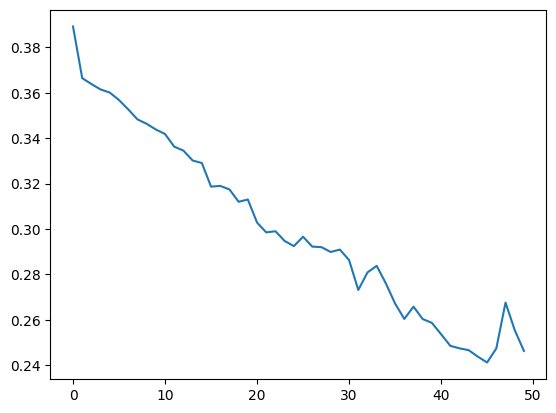

In [42]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## ノートを生成する

モデルを使用してノートを生成するには、まず、ノートの開始シーケンスを指定する必要があります。以下の関数は、ノートのシーケンスから 1 つのノートを生成します。

ノートのピッチについては、モデルが生成するノートのソフトマックス分布からサンプルが取り出され、最も高い確率ののノートが拾われるわけではありません。常に最も高い確率のノートを拾ってしまうと、生成されるノートのシーケンスが繰り返されてしまいます。

生成されるノートのランダム性を制御するには、`temperature` パラメータを使用できます。temperature の詳細については、[RNN によるテキスト生成](https://www.tensorflow.org/text/tutorials/text_generation)をご覧ください。

In [43]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

では、ノートを生成してみましょう。`next_notes` の temperature と開始シーケンスを変更しながら、どのような結果になるか確認します。

In [44]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


In [45]:
generated_notes.head(10)

pitch      step  duration     start       end
0     65  0.161684  0.321731  0.161684  0.483415
1     80  0.257403  0.701955  0.419087  1.121041
2     80  0.213925  0.771206  0.633012  1.404218
3     84  0.200068  0.753670  0.833080  1.586750
4     80  0.214805  0.810083  1.047885  1.857967
5     76  0.194228  0.761987  1.242113  2.004100
6     86  0.199985  0.791260  1.442097  2.233357
7     95  0.187514  0.765765  1.629612  2.395377
8     84  0.217245  0.803358  1.846857  2.650215
9     84  0.185344  0.762861  2.032201  2.795062

In [46]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


以下の 2 行を追加して、音声ファイルをダウンロードすることもできます。

```
from google.colab import files
files.download(out_file)
```

生成されたノートを視覚化します。

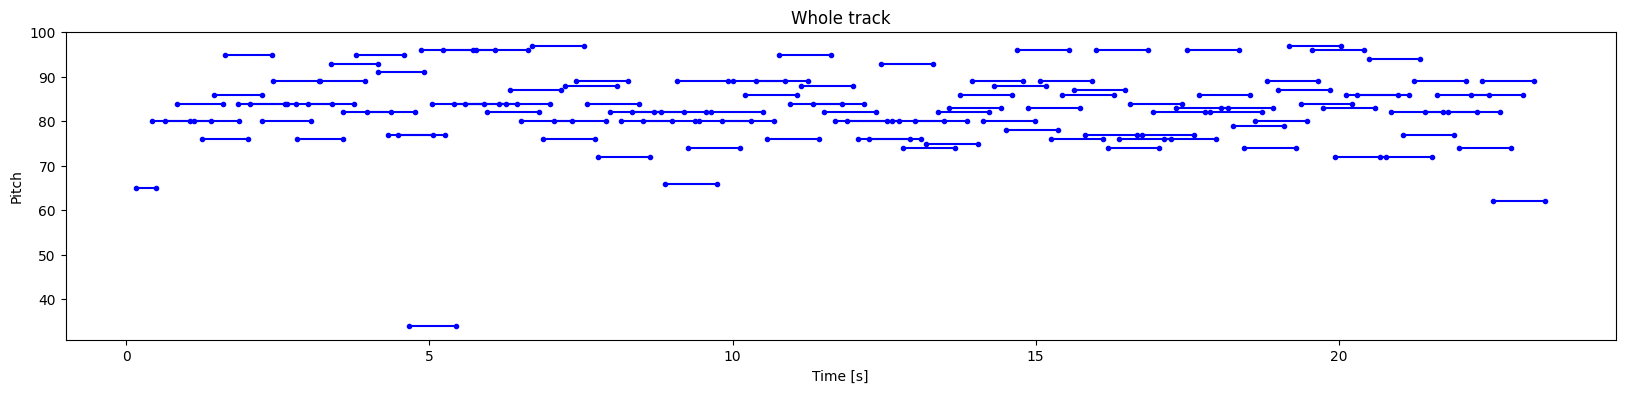

In [47]:
plot_piano_roll(generated_notes)

`pitch`、`step`、および `duration` の分布を確認します。

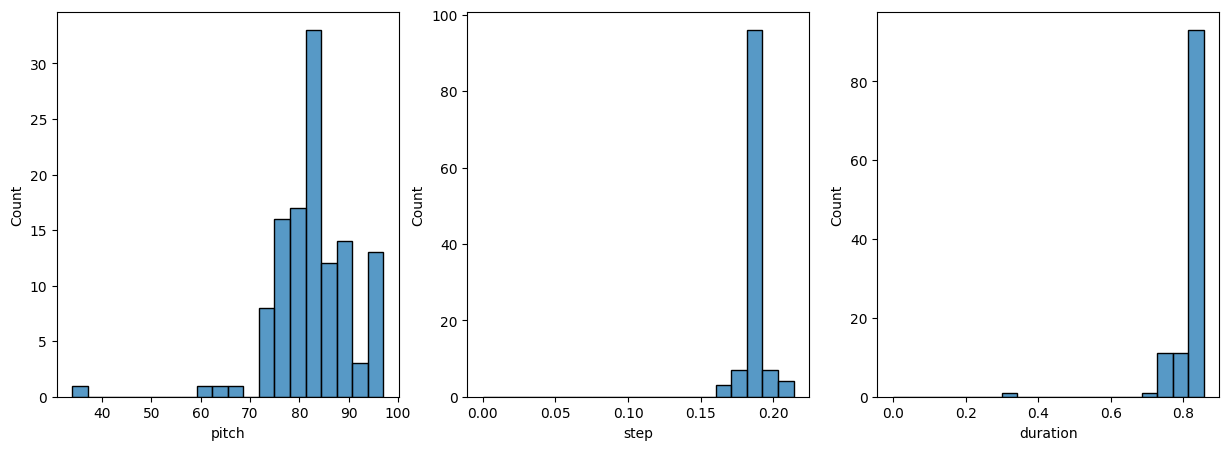

In [48]:
plot_distributions(generated_notes)

上記のプロットでは、ノート変数の分布の変化を確認できます。モデルの出力と入力の間にフィードバックループがあるため、モデルは、似たような出力のシーケンスを生成して損失を低下させる傾向にあります。これは特に、MSE 損失を使用する `step` と `duration` に関連しています。`pitch` については、`predict_next_note` の `temperature` を増加させて、ランダム性を高めることができます。


## 次のステップ

このチュートリアルでは、RNN を使用して、MIDI ファイルのデータセットからノートのシーケンスを生成する仕組みを説明しました。さらに詳しい内容については、関連性の高い [RNN によるテキスト生成](https://www.tensorflow.org/text/tutorials/text_generation)チュートリアルをご覧ください。追加のダイアグラムと説明が記載されています。

音楽生成では、RNN のほかに、GAN を使用することも可能です。GAN ベースのアプローチでは、オーディオを生成する代わりに、シーケンス全体を並行して生成することができます。Magenta チームは、[GANSynth](https://magenta.tensorflow.org/gansynth) を使用してこのアプローチで圧巻の取り組みを達成しています。[Magenta プロジェクトのウェブサイト](https://magenta.tensorflow.org/)には、素晴らしい音楽とアートのプロジェクトとオープンソースコードが多数掲載されています。